# Environment Setup

In [2]:
!python3.7 -m pip install numpy scikit-learn matplotlib seaborn  h5py==2.10.0 openpyxl mlxtend pot protobuf==3.20.2

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from typing import List, Dict, Tuple
from scipy.ndimage import gaussian_filter
from scipy.linalg import svd, sqrtm, inv, cholesky, cho_factor, cho_solve
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.linalg import svd

import os
import numpy as np
import random
np.random.seed(2023)
random.seed(2023)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import random
import pickle as pkl

from math import floor
from scipy.ndimage import gaussian_filter

from PIL import Image
from glob import glob
import pandas as pd
from pathlib import Path


# Data Utils

In [4]:
# Hardcoded values from the config
config = {
"sample_size" : 10000,
"num_experiments" : 1,
"image_shape" : [8, 8],
"image_scale" : 1,
"mean_data" : 0,
"var_data" : 0.5,
"smoothing_sigma" : 3,
"manipulation" : 1.0,
"pattern_scale": 1,
"whitening_methods" : ["symmetric_orthogonalization", "sphering", "partial_regression", "cholesky_whitening", "optimal_signal_preserving_whitening"],

"positions" : [[1, 1], [4, 5]],
"patterns" : ["t", "l"],

"parameterizations" : { 
    "linear": {
      "scenario": "linear",
      "manipulation_type": "additive",
      "pattern_scales": [1],
      "snrs": [[0.18],[0.0125],[]]
    },
    "multiplicative": {
      "scenario": "multiplicative",
      "manipulation_type": "multiplicative",
      "pattern_scales": [1],
      "snrs": [[0.7],[0.1]]
    },
    "translations_rotations": {
      "scenario": "translations_rotations",
      "manipulation_type": "additive",
      "pattern_scales": [1],
      "snrs": [[0.65],[0.2]]
    },
    "xor": {
      "scenario": "xor",
      "manipulation_type": "additive",
      "pattern_scales": [1],
      "snrs": [[0.35],[0.15]]
    }
}
}


# CHECKED
def normalise_data(patterns: np.array, backgrounds: np.array) -> Tuple[np.array, np.array]:
    patterns /= np.linalg.norm(patterns, ord='fro')
    d_norm = np.linalg.norm(backgrounds, ord='fro')
    distractor_term = backgrounds if 0 == d_norm else backgrounds / d_norm
    return patterns, distractor_term

# CHECKED ?? WHICH ONE SHOULD I USE
def scale_to_bound(row, scale):
    # scale = bound / np.max(np.abs(row))
    return row * scale

# CHECKED
def generate_backgrounds(sample_size: int, mean_data: int, var_data: float, image_shape: list=[8,8]) -> np.array:
    backgrounds = np.zeros((sample_size, image_shape[0] * image_shape[1]))

    for i in range(sample_size):
        samples = np.random.normal(mean_data, var_data, size=image_shape)
        backgrounds[i] = np.reshape(samples, (image_shape[0] * image_shape[1]))   

    return backgrounds

# CHECKED
def get_patterns(params: Dict) -> List:
    print(params)
    manip = params['manipulation']
    scale = params['pattern_scale']
    t = np.array([
            [manip,0],
            [manip,manip],
            [manip,0]
        ])
    
    l = np.array([
            [manip,0],
            [manip,0],
            [manip,manip]
        ])
    
    pattern_dict = {
        't': np.kron(t, np.ones((scale,scale))),
        'l': np.kron(l, np.ones((scale,scale))),
    }

    chosen_patterns = []
    for pattern_name in params['patterns']:
        chosen_patterns.append(pattern_dict[pattern_name])
    return chosen_patterns

# def generate_linear_pattern(cls=0):
#     if cls == 0:
#         params = {"patterns": ["t"]}
#     else:
#         params = {"patterns": ["l"]}
#     params['manipulation_type'] = 'additive'
#     params['manipulation'] = 1.0
#     params['pattern_scale'] = 1

#     chosen_pattern = get_patterns(params)
    
#     pos = positions[cls]

#     pattern = np.zeros((8,8))
#     pattern[pos[0]:pos[0]+chosen_pattern[0].shape[0], pos[1]:pos[1]+chosen_pattern[0].shape[1]] = chosen_pattern[0]
    
#     return gaussian_filter(pattern, 0.5)

# def generate_multiplicative_pattern(cls=0, snr=0.2):
#     if cls == 0:
#         params = {"patterns": ["t"]}
#     else:
#         params = {"patterns": ["l"]}

#     params['manipulation_type'] = 'additive'
#     params['pattern_scale'] = 1
#     params['manipulation'] = 1.0

#     chosen_pattern = get_patterns(params)
    
#     pos = positions[cls]
#     pattern = np.zeros((8,8))
#     pattern[pos[0]:pos[0]+chosen_pattern[0].shape[0], pos[1]:pos[1]+chosen_pattern[0].shape[1]] = chosen_pattern[0]
    
#     return gaussian_filter(pattern, 0.5)

# def generate_translations_rotations_pattern(cls=0):
#     if cls == 0:
#         params = {"patterns": ["t"]}
#     else:
#         params = {"patterns": ["l"]}
#     params['manipulation_type'] = 'additive'
#     params['manipulation'] = 1.0
#     params['pattern_scale'] = 1
#     pattern = get_patterns(params)[0]
#     pattern_adj = pattern
#     rand = np.random.randint(0, high=4)
#     if rand == 1:
#         pattern_adj = np.rot90(pattern)
#     elif rand == 2:
#         pattern_adj = np.rot90(np.rot90(pattern))
#     elif rand == 3:
#         pattern_adj = np.rot90(np.rot90(np.rot90(pattern)))
    
#     rand_y = np.random.randint(0, high= 8-pattern_adj.shape[0])
#     rand_x = np.random.randint(0, high= 8-pattern_adj.shape[1])
#     pos = (rand_y, rand_x)

#     pattern = np.zeros((8,8))
#     pattern[pos[0]:pos[0]+pattern_adj.shape[0], pos[1]:pos[1]+pattern_adj.shape[1]] = pattern_adj
    
#     return gaussian_filter(pattern, 0.5)

# def generate_xor_pattern(cls=0):
#     params = {"patterns": ["t","l"]}
#     params['manipulation_type'] = 'additive'
#     params['manipulation'] = 1.0
#     params['pattern_scale'] = 1
#     chosen_patterns  = get_patterns(params)
#     adj_signs = [-1, 1]
#     poses = positions

#     pattern = np.zeros((8,8))

#     if cls == 0:
#         rand_sign = random.sample(adj_signs, 1)
#         pattern[poses[0][0]:poses[0][0]+chosen_patterns[0].shape[0], poses[0][1]:poses[0][1]+chosen_patterns[0].shape[1]] = chosen_patterns[0] * rand_sign
#         pattern[poses[1][0]:poses[1][0]+chosen_patterns[1].shape[0], poses[1][1]:poses[1][1]+chosen_patterns[1].shape[1]] = chosen_patterns[1] * rand_sign
#     else:
#         rand_signs = random.sample(adj_signs, 2)
#         pattern[poses[0][0]:poses[0][0]+chosen_patterns[0].shape[0], poses[0][1]:poses[0][1]+chosen_patterns[0].shape[1]] = chosen_patterns[0] * rand_signs[0]
#         pattern[poses[1][0]:poses[1][0]+chosen_patterns[1].shape[0], poses[1][1]:poses[1][1]+chosen_patterns[1].shape[1]] = chosen_patterns[1] * rand_signs[1]
    
#     return gaussian_filter(pattern, 0.5)

def generate_fixed(params: Dict, image_shape: list):
    patterns = np.zeros((params['sample_size'], image_shape[0], image_shape[1]))
    chosen_patterns = get_patterns(params)
    j = 0
    for k, pattern in enumerate(chosen_patterns):
        pos = params['positions'][k]
        for i in range(int(params['sample_size']/len(params['patterns']))):
            patterns[j][pos[0]:pos[0]+pattern.shape[0], pos[1]:pos[1]+pattern.shape[1]] = pattern
            if params['pattern_scale'] > 3:
                patterns[j] = gaussian_filter(patterns[j], 1.5)
            j+=1 

    return np.reshape(patterns, (params['sample_size'], image_shape[0] * image_shape[1]))

def generate_translations_rotations(params: Dict, image_shape: list) -> np.array:
    patterns = np.zeros((params['sample_size'], image_shape[0], image_shape[1]))    
    chosen_patterns = get_patterns(params)

    j = 0
    for pattern in chosen_patterns:
        for i in range(int(params['sample_size']/len(params['patterns']))):                        
            pattern_adj = pattern

            rand = np.random.randint(0, high=4)
            if rand > 0:
                pattern_adj = np.rot90(pattern, k=rand)
        
            rand_y = np.random.randint(0, high= (image_shape[0])-pattern_adj.shape[0] + 1)
            rand_x = np.random.randint(0, high= (image_shape[0])-pattern_adj.shape[1] + 1)
            pos = (rand_y, rand_x)

            patterns[j][pos[0]:pos[0]+pattern_adj.shape[0], pos[1]:pos[1]+pattern_adj.shape[1]] = pattern_adj
            if params['pattern_scale'] > 3:
                patterns[j] = gaussian_filter(patterns[j], 1.5)
            j+=1     

    return np.reshape(patterns, (params['sample_size'], image_shape[0] * image_shape[1]))

def generate_xor(params: Dict, image_shape: list) -> np.array:
    patterns = np.zeros((params['sample_size'], image_shape[0], image_shape[1]))
    chosen_patterns = get_patterns(params)
    poses = params['positions']

    manips = [
        [1,1],
        [-1,-1],
        [1,-1],
        [-1,1],
    ]

    k = 0
    for ind in range(0, params['sample_size'], int(params['sample_size']/4)):
        pat = np.zeros((image_shape[0], image_shape[1]))
        pat[poses[0][0]:poses[0][0]+chosen_patterns[0].shape[0], poses[0][1]:poses[0][1]+chosen_patterns[0].shape[1]] = chosen_patterns[0] * manips[k][0]
        pat[poses[1][0]:poses[1][0]+chosen_patterns[1].shape[0], poses[1][1]:poses[1][1]+chosen_patterns[1].shape[1]] = chosen_patterns[1] * manips[k][1]
        patterns[ind:ind+int(params['sample_size']/4)] = pat
        k+=1
    
    for j, pattern in enumerate(patterns):
        if params['pattern_scale'] > 3:
            patterns[j] = gaussian_filter(pattern, 1.5)

    return np.reshape(patterns, (params['sample_size'], image_shape[0] * image_shape[1]))


In [5]:
backgrounds = generate_backgrounds(config["sample_size"], config["mean_data"], config["var_data"],config["image_shape"])
print(backgrounds.shape)

patterns_linear = generate_fixed(params=config, image_shape = config["image_shape"])
print(patterns_linear.shape)


# patterns_translations_rotations = generate_translations_rotations(params=config, image_shape = config["image_shape"])
# print(patterns_translations_rotations.shape)

# patterns_xor = generate_xor(params=config, image_shape = config["image_shape"])
# print(patterns_xor.shape)

(10000, 64)
{'sample_size': 10000, 'num_experiments': 1, 'image_shape': [8, 8], 'image_scale': 1, 'mean_data': 0, 'var_data': 0.5, 'smoothing_sigma': 3, 'manipulation': 1.0, 'pattern_scale': 1, 'whitening_methods': ['symmetric_orthogonalization', 'sphering', 'partial_regression', 'cholesky_whitening', 'optimal_signal_preserving_whitening'], 'positions': [[1, 1], [4, 5]], 'patterns': ['t', 'l'], 'parameterizations': {'linear': {'scenario': 'linear', 'manipulation_type': 'additive', 'pattern_scales': [1], 'snrs': [[0.18], [0.0125], []]}, 'multiplicative': {'scenario': 'multiplicative', 'manipulation_type': 'multiplicative', 'pattern_scales': [1], 'snrs': [[0.7], [0.1]]}, 'translations_rotations': {'scenario': 'translations_rotations', 'manipulation_type': 'additive', 'pattern_scales': [1], 'snrs': [[0.65], [0.2]]}, 'xor': {'scenario': 'xor', 'manipulation_type': 'additive', 'pattern_scales': [1], 'snrs': [[0.35], [0.15]]}}}
(10000, 64)


In [6]:
def symmetric_orthogonalise_helper(A, maintainMagnitudes=False, return_W=False):
    L = None
    W = None
    if maintainMagnitudes:
        D = np.diag(np.sqrt(np.diag(A.T @ A)))

        if return_W:
            Lnorm, W = symmetric_orthogonalise_helper(A @ D, maintainMagnitudes=False, return_W=True)
            if Lnorm is not None:
                L = Lnorm @ D
                W = D @ W @ D
        else:
            L = symmetric_orthogonalise_helper(A @ D, maintainMagnitudes=False, return_W=False) @ D
            W = None
    else:
        U, S, Vt = svd(A, full_matrices=False)
        tol = max(A.shape) * S[0] * np.finfo(A.dtype).eps
        r = np.sum(S > tol)
        if r >= A.shape[1]:
            L = U @ Vt
            if return_W:
                W = Vt.T @ np.diag(1.0 / S) @ Vt
            else:
                W = None
        else:
            print("Skipping. Matrix is not full rank.")

    return L, W


# TODO: figure out if I can add a param to control strength of whitening (try different epsilons)
def symmetric_orthogonalization(X, epsilon=1e-6):
    # Compute the covariance matrix
    covariance_matrix = np.dot(X.T, X) / X.shape[0]
    
    # Add regularization to the covariance matrix to ensure it's full rank
    covariance_matrix += epsilon * np.eye(X.shape[1])

    L, P = symmetric_orthogonalise_helper(covariance_matrix, maintainMagnitudes=True, return_W=True)
    if P is not None:
        X = X @ P.T 
        return X, P
    else:
        P = np.eye(X.shape[0])  # dummy transformation matrix
        print(f"Applied symmetric orthogonalization (dummy transformation). Matrix shape: {X.shape}")
        return X, P

def sphering(X, epsilon=1e-6):
    # Compute the covariance matrix
    covariance_matrix = np.dot(X.T, X) / X.shape[0]
    
    # Add regularization to the covariance matrix to ensure it's full rank
    covariance_matrix += epsilon * np.eye(X.shape[1])

    # Compute inverse square root of covariance matrix
    P1 = np.linalg.inv(sqrtm(covariance_matrix))

    # Transpose X before multiplication and then transpose the result
    X1 = (P1 @ X.T).T   
    
    print(f"Applied sphering. Matrix shape: {X1.shape}")
    return X1, P1

def cholesky_whitening(X, epsilon=1e-6):
    # Compute covariance matrix of X's transpose
    cov = np.cov(X.T, ddof=0) + epsilon * np.eye(X.shape[1])
    
    # Compute the inverse Cholesky decomposition
    P4 = np.linalg.cholesky(np.linalg.inv(cov))
    
    # Apply the transformation
    X4 = X @ P4.T  # Note the transpose here to match matrix multiplication dimensions
    print(f"Applied Cholesky whitening. Matrix shape: {X4.shape}")
    
    return X4, P4

def partial_regression(X):
    nsamples, nfeatures = X.shape
    X3 = np.empty_like(X)
    for ii in range(nfeatures):
        xin = X[:, ii]
        xout = X[:, [j for j in range(nfeatures) if j != ii]]
        
        # Compute the weights to regress xin on xout
        weights = np.linalg.pinv(xout) @ xin
        
        # Compute the residuals of the regression
        residuals = xin - xout @ weights
        
        X3[:, ii] = residuals
        
    P = np.eye(nfeatures)  # dummy transformation matrix
    return X3, P

def optimal_signal_preserving_whitening(X, epsilon=1e-6):
    # Compute the correlation matrix of X's transpose
    corr = np.corrcoef(X.T) + epsilon * np.eye(X.shape[1])
    
    # Compute transformation matrix P5
    P5 = np.linalg.inv(sqrtm(corr)) @ np.diag(1 / np.sqrt(np.var(X, axis=0)))
    
    # Apply the transformation
    X5 = X @ P5.T  # Note the transpose here to match matrix multiplication dimensions
    
    return X5, P5

In [8]:
whitening_methods = {
    "symmetric_orthogonalization": symmetric_orthogonalization,
    "sphering": sphering,
    "partial_regression": partial_regression,
    "cholesky_whitening": cholesky_whitening,
    "optimal_signal_preserving_whitening": optimal_signal_preserving_whitening  # Remains unchanged
}

scenario_dict = {
    'linear': generate_fixed,
    'multiplicative': generate_fixed,
    'translations_rotations': generate_translations_rotations,
    'xor': generate_xor
}

    
captured_data = {
}

def whitened_data_generation(config: Dict):
    image_shape = np.array(config["image_shape"]) * config["image_scale"]
    
    # Apply each whitening transformation and save the dataset separately
    for method in config["whitening_methods"]:
        print(f"Applying whitening method {method}")
        for i in range(config['num_experiments']): 
            backgrounds = generate_backgrounds(config['sample_size'], config['mean_data'], config['var_data'], image_shape)
           
            # Iterate over config
            for scenario, params in config['parameterizations'].items():

                for pattern_scale in params['pattern_scales']:

                    config['pattern_scale'] = pattern_scale

                    patterns = scenario_dict.get(scenario)(params=config, image_shape=list(image_shape))

                    for correlated in ['uncorrelated', 'correlated']:
     
                        copy_backgrounds = np.zeros((config['sample_size'], image_shape[0] * image_shape[1]))
                        
                        params['correlated_background'] = correlated
                        if correlated == 'correlated':
                            for j, background in enumerate(backgrounds.copy()):
                                copy_backgrounds[j] = gaussian_filter(np.reshape(background, (image_shape[0], image_shape[1])), config['smoothing_sigma']).reshape((image_shape[0] * image_shape[1]))
                            alpha_ind = 1
                        else:
                            copy_backgrounds = backgrounds.copy()
                            alpha_ind = 0

                        for alpha in params['snrs'][alpha_ind]:
                            print(f'Generating scenario {scenario} with {correlated} background and alpha={alpha}')
                            
                            # Captured data for this combination of parameters
                            captured_data[f'experiment_{i}_original_background_{scenario}_{correlated}_alpha={alpha}'] = copy_backgrounds.copy()
                            
                            copy_patterns = patterns.copy()
                            if params['manipulation_type'] == 'multiplicative':
                                copy_patterns = 1 - alpha * copy_patterns

                            normalised_patterns, normalised_backgrounds = normalise_data(copy_patterns, copy_backgrounds)

                            captured_data[f'experiment_{i}_normalized_background_{scenario}_{correlated}_alpha={alpha}'] = normalised_backgrounds.copy()

                            if params['manipulation_type'] == 'multiplicative':
                                x = normalised_patterns * normalised_backgrounds
                            else:
                                x = alpha * normalised_patterns.copy() + (1 - alpha) * normalised_backgrounds.copy()

                            # Capture combined data
                            captured_data[f'experiment_{i}_pattern_plus_background_{scenario}_{correlated}_alpha={alpha}'] = x.copy()

                            # Apply whitening transformation
                            print("x", x.shape)
                            whitened_x, _ = whitening_methods[method](x.copy())
                            print(f"Applied whitening method {method}. Matrix shape: {whitened_x.shape}")
                            whitened_x = np.apply_along_axis(scale_to_bound, 1, whitened_x, 1)
                            print(f"something along axis? {method}. Matrix shape: {whitened_x.shape}")

                            # Capture whitened data
                            captured_data[f'experiment_{i}_whitened_pattern_plus_background_{method}_{scenario}_{correlated}_alpha={alpha}'] = whitened_x.copy()
                           
whitened_data_generation(config)

Applying whitening method symmetric_orthogonalization
{'sample_size': 10000, 'num_experiments': 1, 'image_shape': [8, 8], 'image_scale': 1, 'mean_data': 0, 'var_data': 0.5, 'smoothing_sigma': 3, 'manipulation': 1.0, 'pattern_scale': 1, 'whitening_methods': ['symmetric_orthogonalization', 'sphering', 'partial_regression', 'cholesky_whitening', 'optimal_signal_preserving_whitening'], 'positions': [[1, 1], [4, 5]], 'patterns': ['t', 'l'], 'parameterizations': {'linear': {'scenario': 'linear', 'manipulation_type': 'additive', 'pattern_scales': [1], 'snrs': [[0.18], [0.0125], []], 'correlated_background': 'correlated'}, 'multiplicative': {'scenario': 'multiplicative', 'manipulation_type': 'multiplicative', 'pattern_scales': [1], 'snrs': [[0.7], [0.1]], 'correlated_background': 'correlated'}, 'translations_rotations': {'scenario': 'translations_rotations', 'manipulation_type': 'additive', 'pattern_scales': [1], 'snrs': [[0.65], [0.2]], 'correlated_background': 'correlated'}, 'xor': {'scenari

In [9]:
for key, value in captured_data.items():
    print(key, value.shape)

experiment_0_original_background_linear_uncorrelated_alpha=0.18 (10000, 64)
experiment_0_normalized_background_linear_uncorrelated_alpha=0.18 (10000, 64)
experiment_0_pattern_plus_background_linear_uncorrelated_alpha=0.18 (10000, 64)
experiment_0_whitened_pattern_plus_background_symmetric_orthogonalization_linear_uncorrelated_alpha=0.18 (10000, 64)
experiment_0_original_background_linear_correlated_alpha=0.0125 (10000, 64)
experiment_0_normalized_background_linear_correlated_alpha=0.0125 (10000, 64)
experiment_0_pattern_plus_background_linear_correlated_alpha=0.0125 (10000, 64)
experiment_0_whitened_pattern_plus_background_symmetric_orthogonalization_linear_correlated_alpha=0.0125 (10000, 64)
experiment_0_original_background_multiplicative_uncorrelated_alpha=0.7 (10000, 64)
experiment_0_normalized_background_multiplicative_uncorrelated_alpha=0.7 (10000, 64)
experiment_0_pattern_plus_background_multiplicative_uncorrelated_alpha=0.7 (10000, 64)
experiment_0_whitened_pattern_plus_backgrou

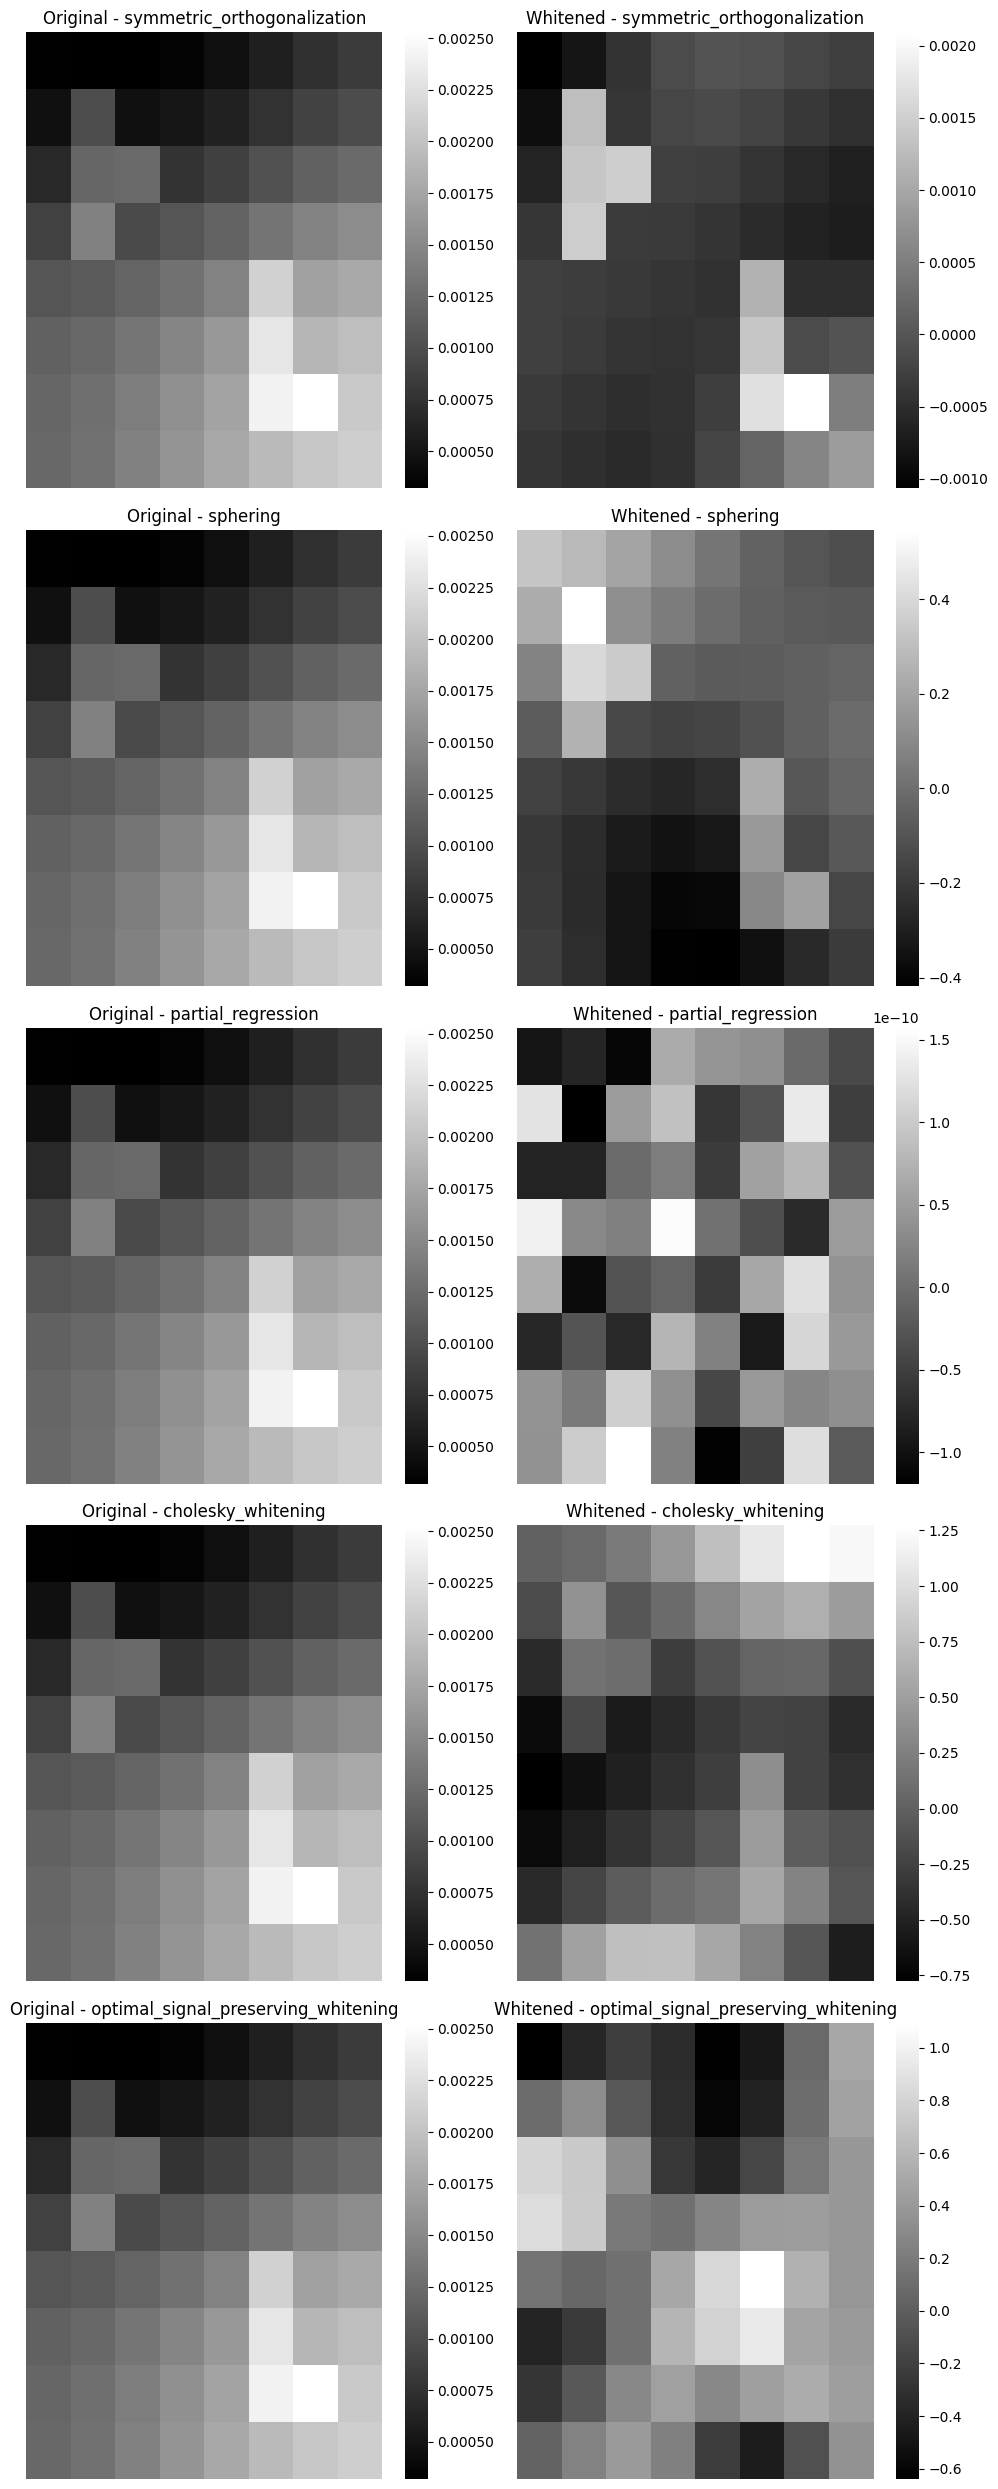

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmaps(experiment_number, scenario, background_type, alpha):
    fig, axs = plt.subplots(5, 2, figsize=(10, 25))  # 5 rows for 5 whitening methods, 2 columns for original and whitened images
    
    whitening_methods = [
        "symmetric_orthogonalization",
        "sphering",
        "partial_regression",
        "cholesky_whitening",
        "optimal_signal_preserving_whitening"
    ]
    
    for i, method in enumerate(whitening_methods):
        # Construct the keys to access the data in the captured_data dictionary
        original_key = f'experiment_{experiment_number}_pattern_plus_background_{scenario}_{background_type}_alpha={alpha}'
        whitened_key = f'experiment_{experiment_number}_whitened_pattern_plus_background_{method}_{scenario}_{background_type}_alpha={alpha}'
        
        # Extract the data (assuming here index 0, adjust as needed)
        original_image = np.real(captured_data[original_key][0].reshape(8, 8))  # Take the real part
        whitened_image = np.real(captured_data[whitened_key][0].reshape(8, 8))  # Take the real part
        
        # Plot the original image
        sns.heatmap(original_image, ax=axs[i, 0], cmap='gray', cbar=True)
        axs[i, 0].set_title(f'Original - {method}')
        axs[i, 0].axis('off')  # Hide the axis
        
        # Plot the whitened image
        sns.heatmap(whitened_image, ax=axs[i, 1], cmap='gray', cbar=True)
        axs[i, 1].set_title(f'Whitened - {method}')
        axs[i, 1].axis('off')  # Hide the axis
    
    plt.tight_layout()
    plt.show()

# Call the function with the desired parameters
plot_heatmaps(0, 'xor', 'correlated', 0.15)


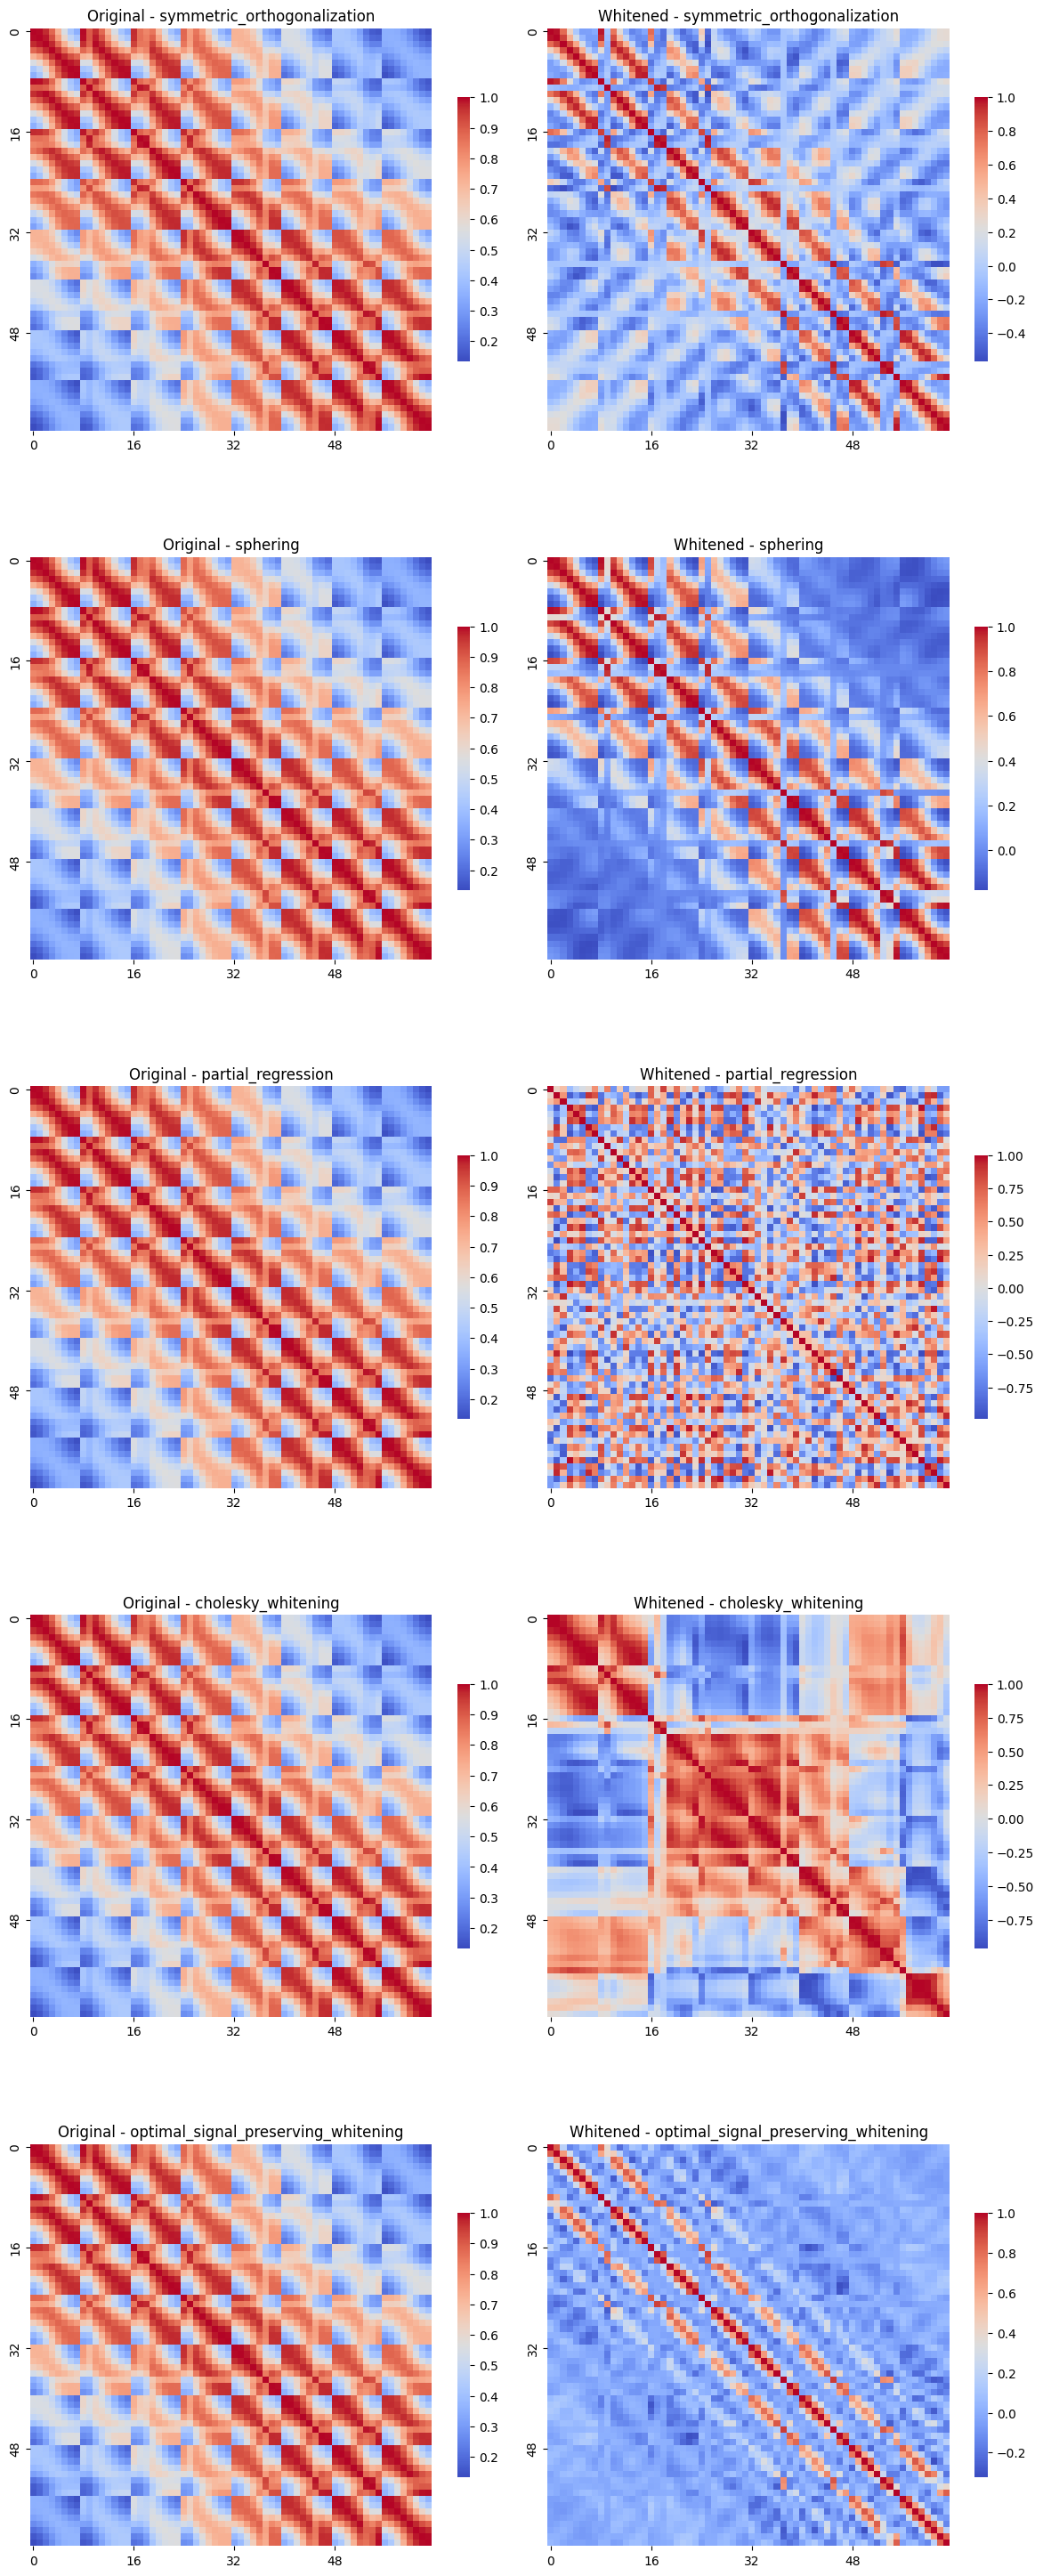

In [26]:
def plot_all_correlation_matrices(experiment_number, scenario, background_type, alpha):
    methods = list(whitening_methods.keys())  # Get the list of whitening methods
    n_methods = len(methods)  # Number of whitening methods
    
    # Set up the matplotlib figure
    fig, axs = plt.subplots(n_methods, 2, figsize=(12, 6 * n_methods))
    
    # Iterate through each whitening method
    for i, method in enumerate(methods):
        # Get the keys for original and whitened data
        original_key = f'experiment_{experiment_number}_pattern_plus_background_{scenario}_{background_type}_alpha={alpha}'
        whitened_key = f'experiment_{experiment_number}_whitened_pattern_plus_background_{method}_{scenario}_{background_type}_alpha={alpha}'

        # Retrieve the original and whitened data
        original_data = captured_data[original_key]
        whitened_data = captured_data[whitened_key]

        # Ensure the data is real before computing the correlation
        whitened_data = np.real(whitened_data)

        # Compute the correlation matrices
        original_corr_matrix = np.corrcoef(original_data, rowvar=False)
        whitened_corr_matrix = np.corrcoef(whitened_data, rowvar=False)

        # Draw the heatmaps
        sns.heatmap(original_corr_matrix, ax=axs[i, 0], cmap='coolwarm', annot=False, cbar=True, square=True, cbar_kws={"shrink": .5}, xticklabels=16, yticklabels=16)
        axs[i, 0].set_title(f'Original - {method}')

        sns.heatmap(whitened_corr_matrix, ax=axs[i, 1], cmap='coolwarm', annot=False, cbar=True, square=True, cbar_kws={"shrink": .5}, xticklabels=16, yticklabels=16)
        axs[i, 1].set_title(f'Whitened - {method}')
    
    plt.tight_layout()
    plt.show()

# Call the function with the desired parameters
plot_all_correlation_matrices(0, 'xor', 'correlated', 0.15)


0 symmetric_orthogonalization
1 sphering
2 partial_regression
3 cholesky_whitening
4 optimal_signal_preserving_whitening


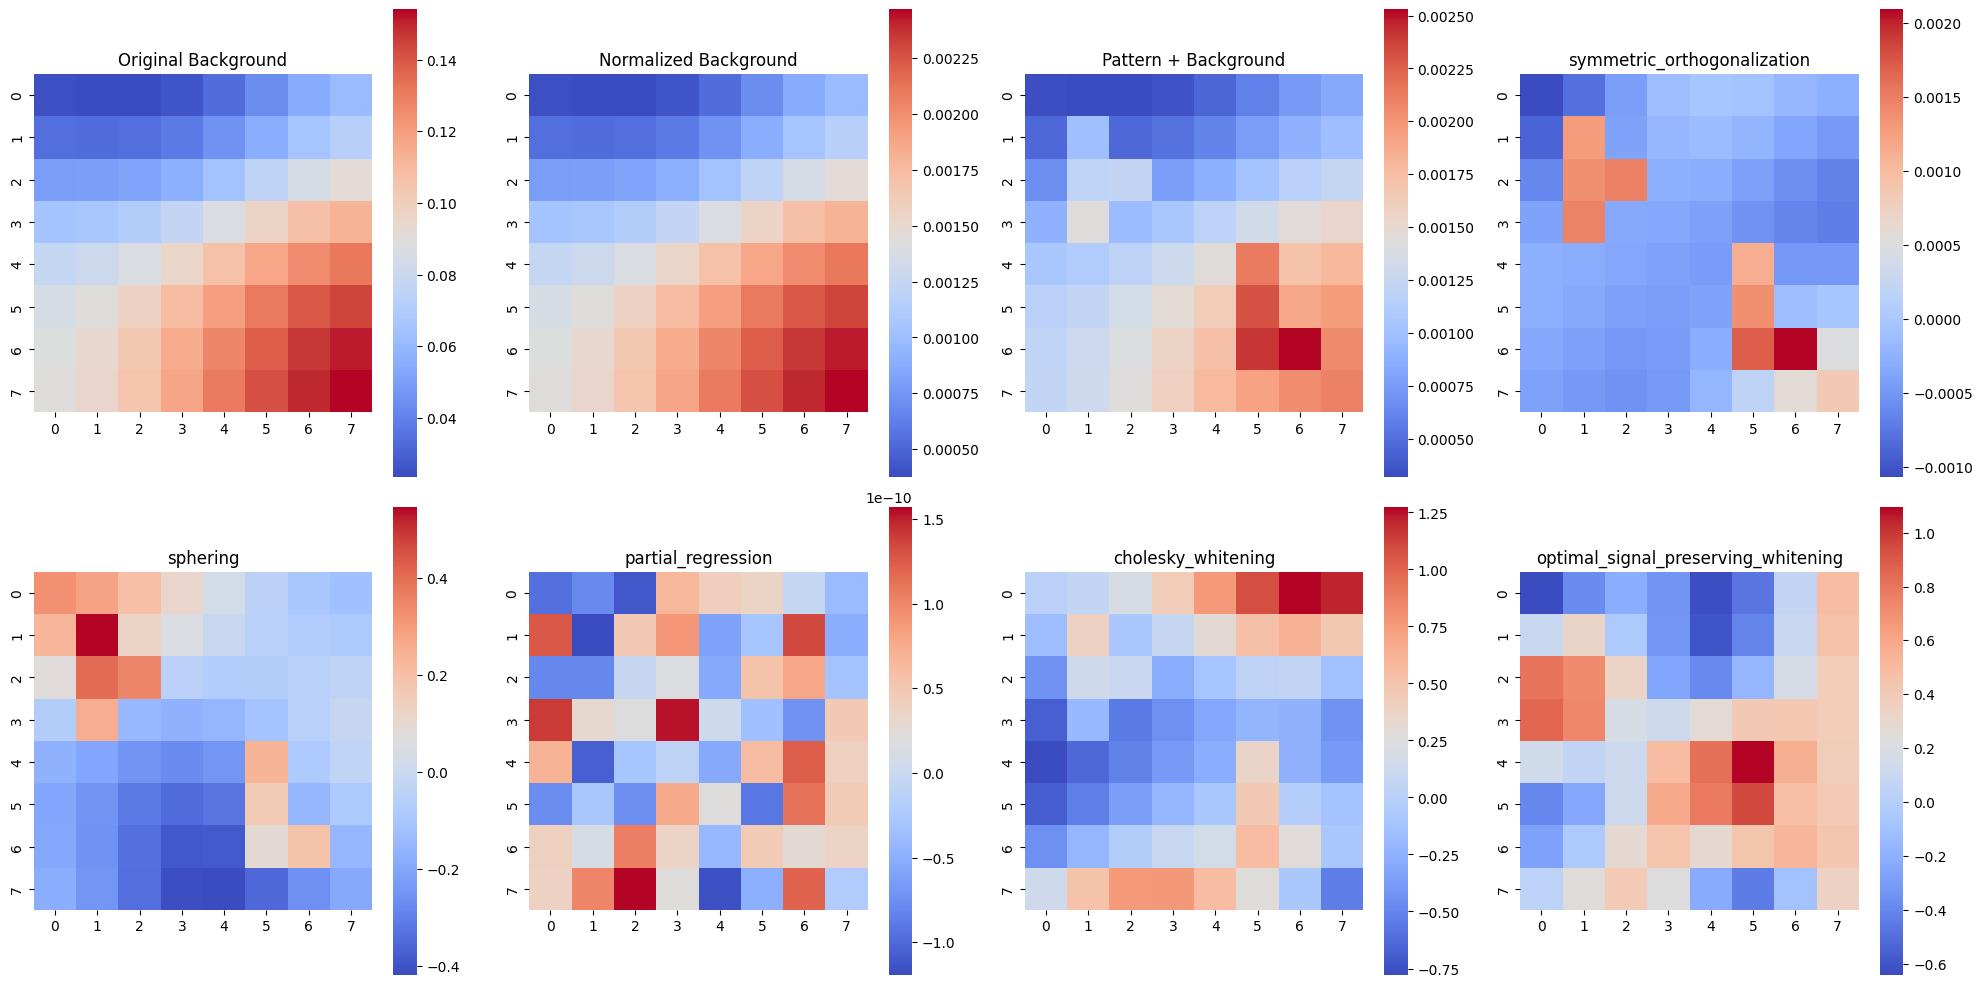

In [39]:
def plot_heatmaps(experiment_number, scenario, background_type, alpha):
    methods = list(whitening_methods.keys())  # Get the list of whitening methods
    
    # Set up the matplotlib figure
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    
    # Get the keys for original, normalized, and pattern data
    original_key = f'experiment_{experiment_number}_original_background_{scenario}_{background_type}_alpha={alpha}'
    normalized_key = f'experiment_{experiment_number}_normalized_background_{scenario}_{background_type}_alpha={alpha}'
    pattern_key = f'experiment_{experiment_number}_pattern_plus_background_{scenario}_{background_type}_alpha={alpha}'
    
    # Retrieve the original, normalized, and pattern data
    original_data = captured_data[original_key][0].reshape(8, 8)
    normalized_data = captured_data[normalized_key][0].reshape(8, 8)
    pattern_data = captured_data[pattern_key][0].reshape(8, 8)
    
    # Draw the heatmaps for original, normalized, and pattern data
    sns.heatmap(original_data, ax=axs[0, 0], cmap='coolwarm', cbar=True, square=True)
    axs[0, 0].set_title('Original Background')
    
    sns.heatmap(normalized_data, ax=axs[0, 1], cmap='coolwarm', cbar=True, square=True)
    axs[0, 1].set_title('Normalized Background')
    
    sns.heatmap(pattern_data, ax=axs[0, 2], cmap='coolwarm', cbar=True, square=True)
    axs[0, 2].set_title('Pattern + Background')
    
    # Iterate through each whitening method and draw the heatmaps
    for i, method in enumerate(methods):
        whitened_key = f'experiment_{experiment_number}_whitened_pattern_plus_background_{method}_{scenario}_{background_type}_alpha={alpha}'
        whitened_data = captured_data[whitened_key][0].reshape(8, 8)
        # Handle complex number issue by taking the real part
        whitened_data = np.real(whitened_data)
        row_idx = 1 if i > 0 else 0  # Determine the row index for subplots
        col_idx = i - 1 if i > 0 else 3  # Determine the column index for subplots
        sns.heatmap(whitened_data, ax=axs[row_idx, col_idx], cmap='coolwarm', cbar=True, square=True)
        axs[row_idx, col_idx].set_title(f'{method}')
    
    plt.tight_layout()
    plt.show()

# Call the function with the desired parameters
plot_heatmaps(0, 'xor', 'correlated', 0.15)


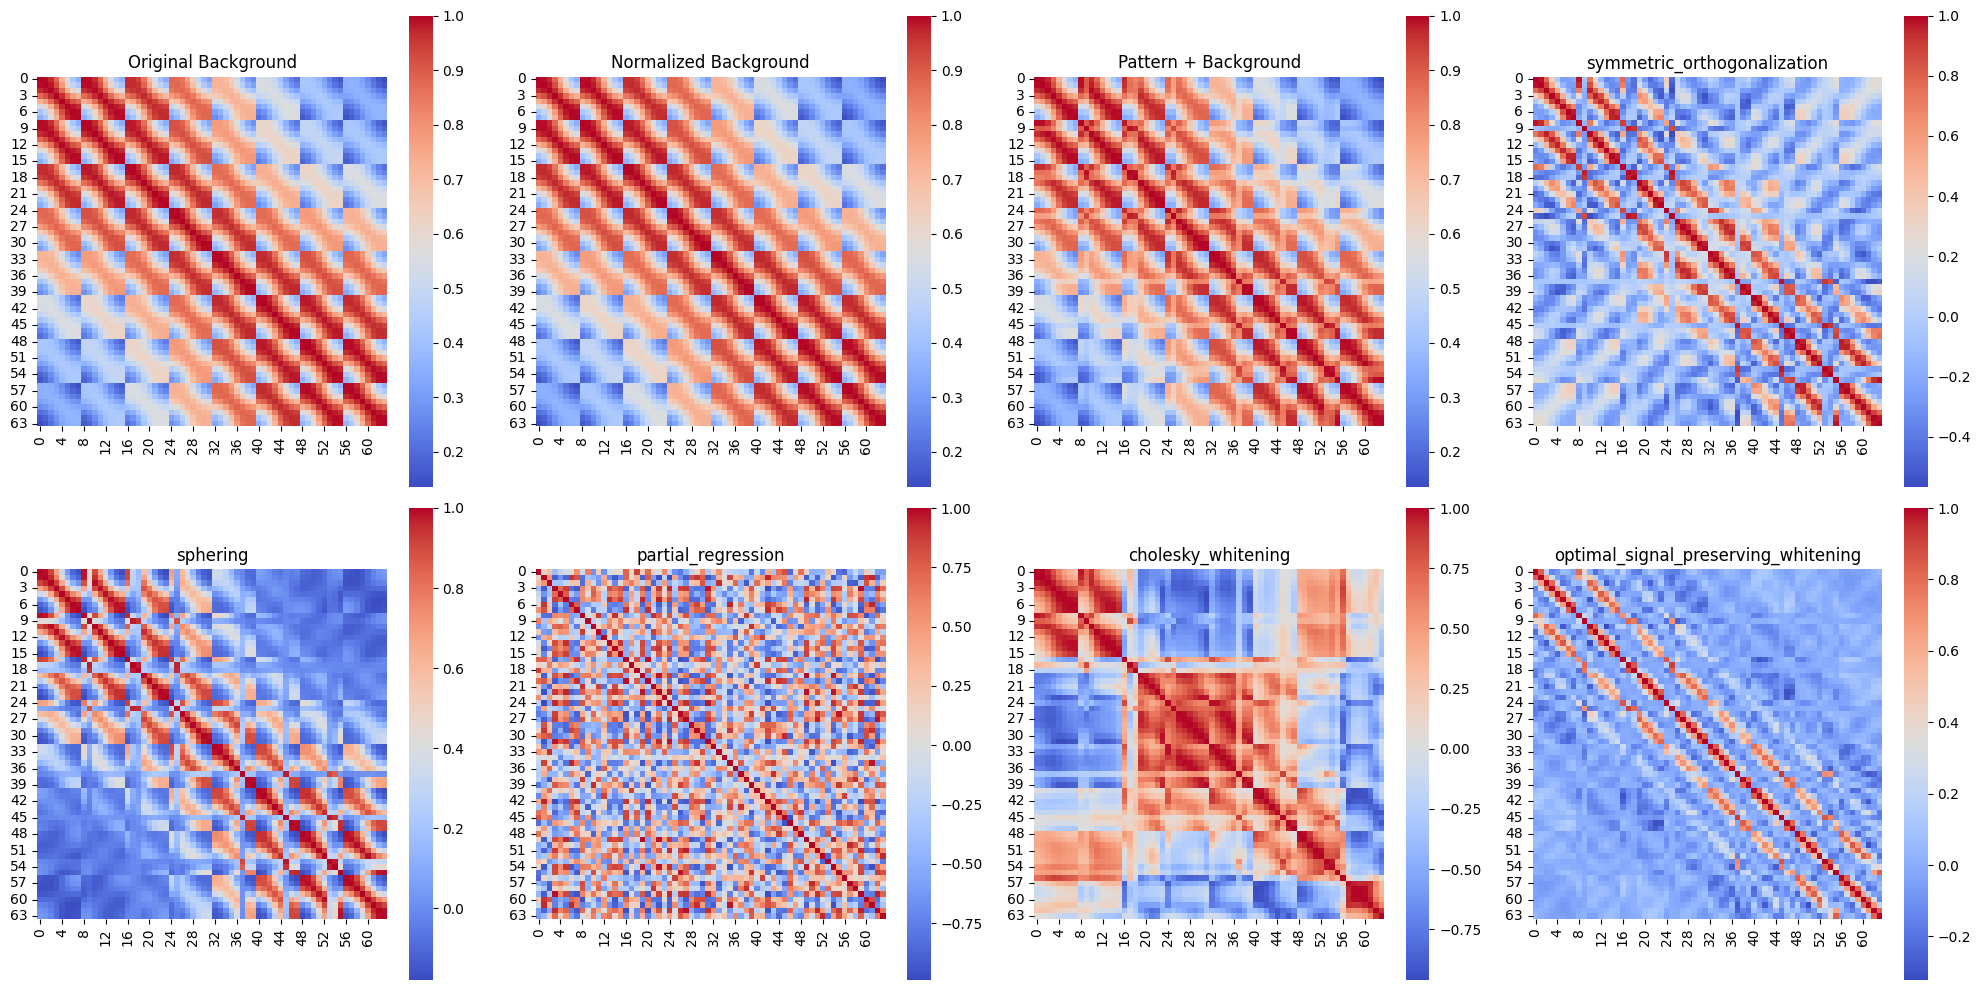

In [40]:
def plot_correlation_matrices(experiment_number, scenario, background_type, alpha):
    methods = list(whitening_methods.keys())  # Get the list of whitening methods
    
    # Set up the matplotlib figure
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    
    # Get the keys for original, normalized, and pattern data
    original_key = f'experiment_{experiment_number}_original_background_{scenario}_{background_type}_alpha={alpha}'
    normalized_key = f'experiment_{experiment_number}_normalized_background_{scenario}_{background_type}_alpha={alpha}'
    pattern_key = f'experiment_{experiment_number}_pattern_plus_background_{scenario}_{background_type}_alpha={alpha}'
    
    # Retrieve the original, normalized, and pattern data
    original_data = captured_data[original_key]
    normalized_data = captured_data[normalized_key]
    pattern_data = captured_data[pattern_key]
    
    # Draw the correlation matrices for original, normalized, and pattern data
    sns.heatmap(np.corrcoef(original_data, rowvar=False), ax=axs[0, 0], cmap='coolwarm', cbar=True, square=True)
    axs[0, 0].set_title('Original Background')
    
    sns.heatmap(np.corrcoef(normalized_data, rowvar=False), ax=axs[0, 1], cmap='coolwarm', cbar=True, square=True)
    axs[0, 1].set_title('Normalized Background')
    
    sns.heatmap(np.corrcoef(pattern_data, rowvar=False), ax=axs[0, 2], cmap='coolwarm', cbar=True, square=True)
    axs[0, 2].set_title('Pattern + Background')
    
    # Iterate through each whitening method and draw the correlation matrices
    for i, method in enumerate(methods):
        whitened_key = f'experiment_{experiment_number}_whitened_pattern_plus_background_{method}_{scenario}_{background_type}_alpha={alpha}'
        whitened_data = captured_data[whitened_key]
        # Handle complex number issue by taking the real part
        whitened_data = np.real(whitened_data)
        row_idx = 1 if i > 0 else 0  # Determine the row index for subplots
        col_idx = i - 1 if i > 0 else 3  # Determine the column index for subplots
        sns.heatmap(np.corrcoef(whitened_data, rowvar=False), ax=axs[row_idx, col_idx], cmap='coolwarm', cbar=True, square=True)
        axs[row_idx, col_idx].set_title(f'{method}')
    
    plt.tight_layout()
    plt.show()

# Call the function with the desired parameters
plot_correlation_matrices(0, 'xor', 'correlated', 0.15)


In [ ]:
# # Integrating the second set of functions and hardcoding values from the config

# # Hardcoded values from the config
# sample_size = 10000
# image_shape = [8, 8]
# mean_data = 0
# var_data = 0.5
# positions = [[1, 1], [4, 5]]
# patterns_list = ["t", "l"]

# # Modified and Integrated functions

# def get_patterns(params: dict) -> list:
#     manip = params['manipulation']
#     scale = params['pattern_scale']
#     t = np.array([
#         [manip, 0],
#         [manip, manip],
#         [manip, 0]
#     ])
#     l = np.array([
#         [manip, 0],
#         [manip, 0],
#         [manip, manip]
#     ])
#     pattern_dict = {
#         't': np.kron(t, np.ones((scale, scale))),
#         'l': np.kron(l, np.ones((scale, scale))),
#     }
#     chosen_patterns = [pattern_dict[pattern_name] for pattern_name in params['patterns']]
#     return chosen_patterns

# def scale_to_bound(row, scale):
#     return row * scale

# def generate_backgrounds() -> np.array:
#     backgrounds = np.zeros((sample_size, image_shape[0] * image_shape[1]))
#     for i in range(sample_size):
#         samples = np.random.normal(mean_data, var_data, size=image_shape)
#         backgrounds[i] = np.reshape(samples, (image_shape[0] * image_shape[1]))   
#     return backgrounds

# # Note: We won't implement the generate_imagenet function as it references files and paths we don't have access to.

# def generate_fixed(params: dict) -> np.array:
#     patterns = np.zeros((params['sample_size'], image_shape[0], image_shape[1]))
#     chosen_patterns = get_patterns(params)
#     j = 0
#     for k, pattern in enumerate(chosen_patterns):
#         pos = positions[k]
#         for i in range(int(params['sample_size'] / len(params['patterns']))):
#             patterns[j][pos[0]:pos[0]+pattern.shape[0], pos[1]:pos[1]+pattern.shape[1]] = pattern
#             if params['pattern_scale'] > 3:
#                 patterns[j] = gaussian_filter(patterns[j], 1.5)
#             j += 1 
#     return np.reshape(patterns, (params['sample_size'], image_shape[0] * image_shape[1]))

# def generate_translations_rotations(params: dict) -> np.array:
#     patterns = np.zeros((params['sample_size'], image_shape[0], image_shape[1]))    
#     chosen_patterns = get_patterns(params)
#     j = 0
#     for pattern in chosen_patterns:
#         for i in range(int(params['sample_size']/len(params['patterns']))):                        
#             pattern_adj = pattern
#             rand = np.random.randint(0, high=4)
#             if rand > 0:
#                 pattern_adj = np.rot90(pattern, k=rand)
#             rand_y = np.random.randint(0, high= image_shape[0]-pattern_adj.shape[0])
#             rand_x = np.random.randint(0, high= image_shape[0]-pattern_adj.shape[1])
#             pos = (rand_y, rand_x)
#             patterns[j][pos[0]:pos[0]+pattern_adj.shape[0], pos[1]:pos[1]+pattern_adj.shape[1]] = pattern_adj
#             if params['pattern_scale'] > 3:
#                 patterns[j] = gaussian_filter(patterns[j], 1.5)
#             j += 1     
#     return np.reshape(patterns, (params['sample_size'], image_shape[0] * image_shape[1]))

# def generate_xor(params: dict) -> np.array:
#     patterns = np.zeros((params['sample_size'], image_shape[0], image_shape[1]))
#     chosen_patterns = get_patterns(params)
#     manips = [[1, 1], [-1, -1], [1, -1], [-1, 1]]
#     k = 0
#     for ind in range(0, params['sample_size'], int(params['sample_size'] / 4)):
#         pat = np.zeros((image_shape[0], image_shape[1]))
#         pat[positions[0][0]:positions[0][0]+chosen_patterns[0].shape[0], positions[0][1]:positions[0][1]+chosen_patterns[0].shape[1]] = chosen_patterns[0] * manips[k][0]
#         pat[positions[1][0]:positions[1][0]+chosen_patterns[1].shape[0], positions[1][1]:positions[1][1]+chosen_patterns[1].shape[1]] = chosen_patterns[1] * manips[k][1]
#         patterns[ind:ind+int(params['sample_size']/4)] = pat
#         k += 1
#     for j, pattern in enumerate(patterns):
#         if params['pattern_scale'] > 3:
#             patterns[j] = gaussian_filter(pattern, 1.5)
#     return np.reshape(patterns, (params['sample_size'], image_shape[0] * image_shape[1]))

# Whtening

In [36]:
def symmetric_orthogonalise_helper(A, maintainMagnitudes=False, return_W=False):
    L = None
    W = None
    if maintainMagnitudes:
        D = np.diag(np.sqrt(np.diag(A.T @ A)))

        if return_W:
            Lnorm, W = symmetric_orthogonalise_helper(A @ D, maintainMagnitudes=False, return_W=True)
            if Lnorm is not None:
                L = Lnorm @ D
                W = D @ W @ D
        else:
            L = symmetric_orthogonalise_helper(A @ D, maintainMagnitudes=False, return_W=False) @ D
            W = None
    else:
        U, S, Vt = svd(A, full_matrices=False)
        tol = max(A.shape) * S[0] * np.finfo(A.dtype).eps
        r = np.sum(S > tol)
        if r >= A.shape[1]:
            L = U @ Vt
            if return_W:
                W = Vt.T @ np.diag(1.0 / S) @ Vt
            else:
                W = None
        else:
            print("Skipping. Matrix is not full rank.")

    return L, W


# TODO: figure out if I can add a param to control strength of whitening (try different epsilons)
def symmetric_orthogonalization(X, epsilon=1e-6):
    # Compute the covariance matrix
    covariance_matrix = np.dot(X.T, X) / X.shape[0]
    
    # Add regularization to the covariance matrix to ensure it's full rank
    covariance_matrix += epsilon * np.eye(X.shape[1])

    L, P = symmetric_orthogonalise_helper(covariance_matrix, maintainMagnitudes=True, return_W=True)
    if P is not None:
        X = X @ P.T 
        return X, P
    else:
        P = np.eye(X.shape[0])  # dummy transformation matrix
        print(f"Applied symmetric orthogonalization (dummy transformation). Matrix shape: {X.shape}")
        return X, P

def sphering(X, epsilon=1e-6):
    # Compute the covariance matrix
    covariance_matrix = np.dot(X.T, X) / X.shape[0]
    
    # Add regularization to the covariance matrix to ensure it's full rank
    covariance_matrix += epsilon * np.eye(X.shape[1])

    # Compute inverse square root of covariance matrix
    P1 = np.linalg.inv(sqrtm(covariance_matrix))

    # Transpose X before multiplication and then transpose the result
    X1 = (P1 @ X.T).T   
    
    print(f"Applied sphering. Matrix shape: {X1.shape}")
    return X1, P1

def cholesky_whitening(X, epsilon=1e-6):
    # Compute covariance matrix of X's transpose
    cov = np.cov(X.T, ddof=0) + epsilon * np.eye(X.shape[1])
    
    # Compute the inverse Cholesky decomposition
    P4 = np.linalg.cholesky(np.linalg.inv(cov))
    
    # Apply the transformation
    X4 = X @ P4.T  # Note the transpose here to match matrix multiplication dimensions
    print(f"Applied Cholesky whitening. Matrix shape: {X4.shape}")
    
    return X4, P4

def partial_regression(X):
    nsamples, nfeatures = X.shape
    X3 = np.empty_like(X)
    for ii in range(nfeatures):
        xin = X[:, ii]
        xout = X[:, [j for j in range(nfeatures) if j != ii]]
        
        # Compute the weights to regress xin on xout
        weights = np.linalg.pinv(xout) @ xin
        
        # Compute the residuals of the regression
        residuals = xin - xout @ weights
        
        X3[:, ii] = residuals
        
    P = np.eye(nfeatures)  # dummy transformation matrix
    return X3, P

def optimal_signal_preserving_whitening(X, epsilon=1e-6):
    # Compute the correlation matrix of X's transpose
    corr = np.corrcoef(X.T) + epsilon * np.eye(X.shape[1])
    
    # Compute transformation matrix P5
    P5 = np.linalg.inv(sqrtm(corr)) @ np.diag(1 / np.sqrt(np.var(X, axis=0)))
    
    # Apply the transformation
    X5 = X @ P5.T  # Note the transpose here to match matrix multiplication dimensions
    
    return X5, P5

## Validating the Whitening Methods

(10000, 64)
Applied sphering. Matrix shape: (10000, 64)
Applied Cholesky whitening. Matrix shape: (10000, 64)
{'Original': (1.0, 0.09850558976779228), 'Sphering': (1.0, 2.0768206438080922e-07), 'Symmetric Orthogonalization': (1.0, 0.45390634661771595), 'Partial Regression': (1.0, 0.45551183374803866), 'Cholesky Whitening': (1.0, 0.4865101921292013), 'Optimal Signal Preserving Whitening': (1.0, 2.4925293193103987e-05)}


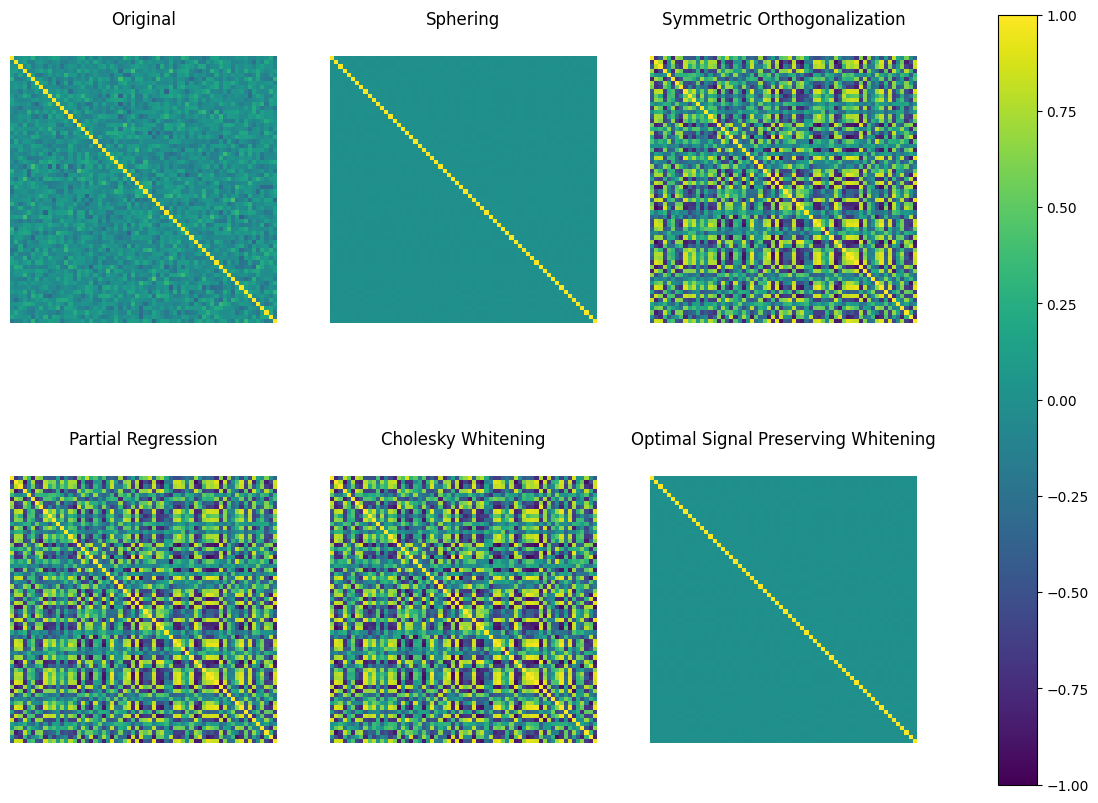

In [5]:
nfeatures = 64
nsamples = 10000

M = np.random.randn(nfeatures, nfeatures)
X = (M @ np.random.randn(nfeatures, nsamples)**2)
X = X - np.mean(X, axis=1, keepdims=True)

# Transpose the synthetic data to have shape (samples, features)
X = X.T
print(X.shape)

X1, P1 = sphering(X)
X2, P2 = symmetric_orthogonalization(X)
X3, P3 = partial_regression(X)
X4, P4 = cholesky_whitening(X)
X5, P5 = optimal_signal_preserving_whitening(X)


correlation_matrices = {
    "Original": np.corrcoef(X, rowvar=False),
    "Sphering": np.corrcoef(X1, rowvar=False),
    "Symmetric Orthogonalization": np.corrcoef(X2, rowvar=False),
    "Partial Regression": np.corrcoef(X3, rowvar=False),
    "Cholesky Whitening": np.corrcoef(X4, rowvar=False),
    "Optimal Signal Preserving Whitening": np.corrcoef(X5, rowvar=False)
}

whitened_data = {
    "Sphering": X1,
    "Symmetric Orthogonalization": X2,
    "Partial Regression": X3,
    "Cholesky Whitening": X4,
    "Optimal Signal Preserving Whitening": X5
}


def compute_correlation_metrics(data):
    """Computes the mean diagonal and mean absolute off-diagonal of a correlation matrix."""
    corr_matrix = np.corrcoef(data, rowvar=False)
    mean_diag = np.mean(np.diag(corr_matrix))
    mean_off_diag = np.mean(np.abs(corr_matrix - np.diag(np.diag(corr_matrix))))
    return mean_diag, mean_off_diag

results = {}

results["Original"] = compute_correlation_metrics(X)

for label, data in whitened_data.items():
    results[label] = compute_correlation_metrics(data)

print(results)

# Plot correlation matrices
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for ax, (label, corr_matrix) in zip(axs.ravel(), correlation_matrices.items()):
    cax = ax.matshow(corr_matrix, cmap="viridis", vmin=-1, vmax=1)
    ax.set_title(label)
    ax.axis('off')
fig.colorbar(cax, ax=axs.ravel().tolist(), orientation='vertical', pad=0.07)
plt.show()

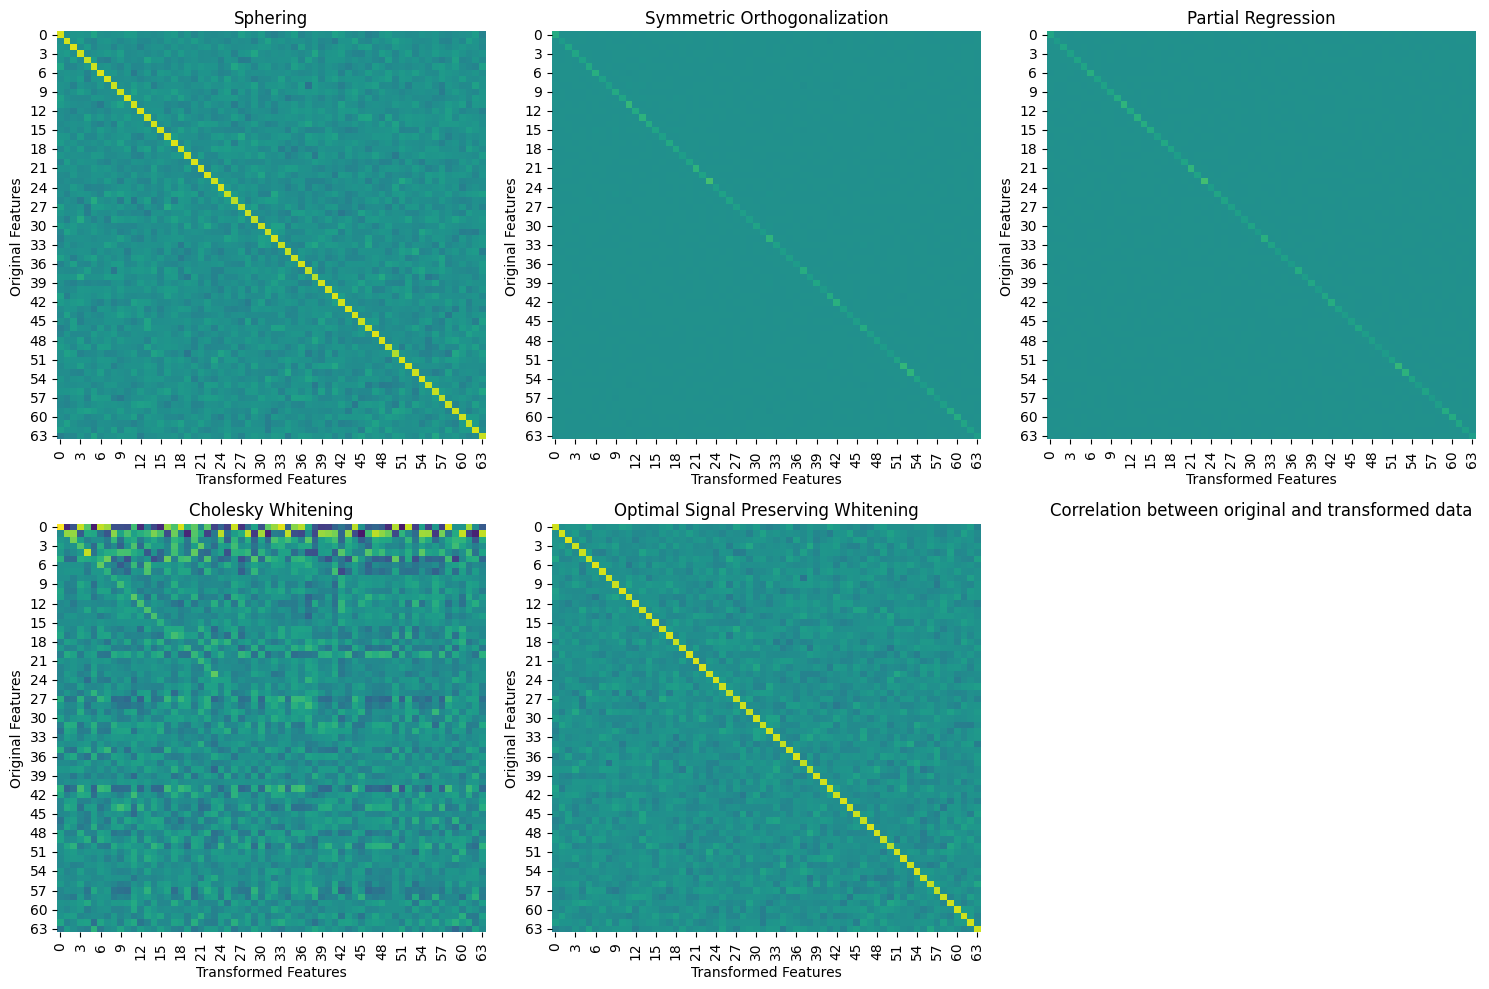

In [6]:
import seaborn as sns

# Function to compute correlation between original and transformed data
def original_transformed_correlation(original, transformed):
    return np.corrcoef(original.T, transformed.T)[:original.shape[1], original.shape[1]:]

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for ax, (label, data) in zip(axs.ravel(), whitened_data.items()):
    corr_ot = original_transformed_correlation(X, data)
    sns.heatmap(corr_ot, ax=ax, cmap='viridis', vmin=-1, vmax=1, cbar=False)
    ax.set_title(label)
    ax.set_xlabel("Transformed Features")
    ax.set_ylabel("Original Features")

# Remove the last empty subplot
axs[1, 2].axis('off')
plt.tight_layout()
plt.title("Correlation between original and transformed data")
plt.show()

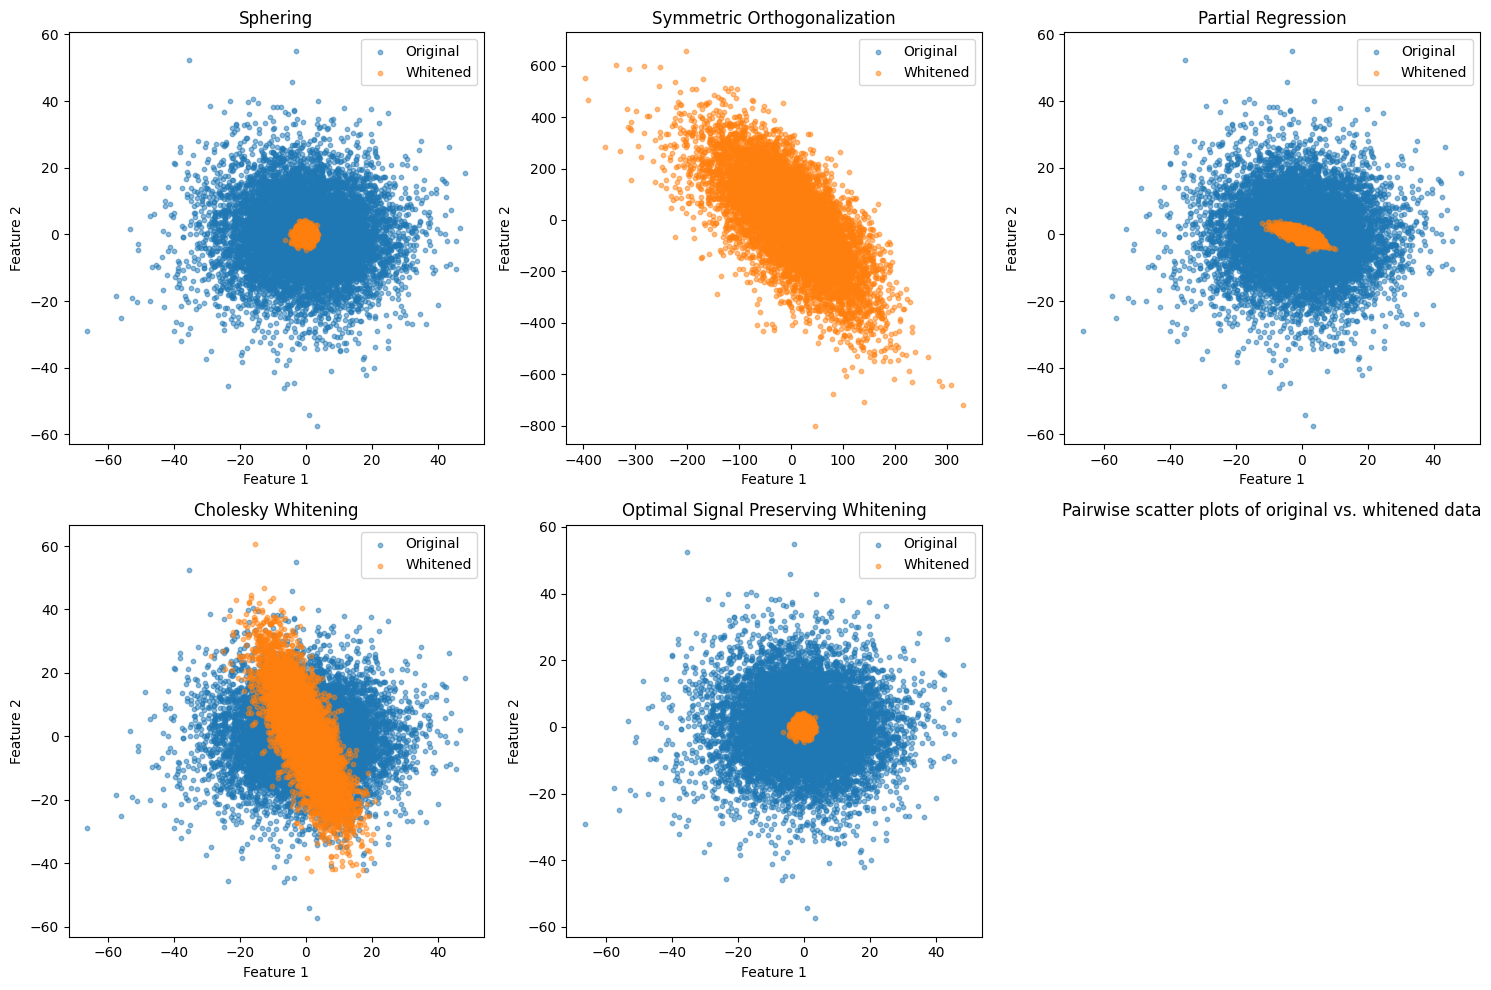

In [7]:
# Plot pairwise scatter plots of original vs. whitened data for each method
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for ax, (label, data) in zip(axs.ravel(), whitened_data.items()):
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original', s=10)
    ax.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Whitened', s=10)
    ax.set_title(label)
    ax.legend()
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

# Remove the last empty subplot
axs[1, 2].axis('off')
plt.tight_layout()
plt.title("Pairwise scatter plots of original vs. whitened data")
plt.show()


# Data Generation

In [8]:
snrs = [0.5, 0.4, 0.5, 0.825, 0.825, 0.825, 0.5, 0.2, 0.5, 0.6, 0.2, 0.6] # 1 = pefect signal; 0= just background, no signal

def generate_n_examples_with_whitening(n=4, snrs=snrs, whitening_method=None):
    backgrounds = [generate_background(), generate_background()]
    smoothed_backgrounds = [gaussian_filter(backgrounds[0].copy(), 3), gaussian_filter(backgrounds[1].copy(), 3)]
    
    linear_0, linear_1 = generate_linear_pattern(cls=0), generate_linear_pattern(cls=1)
    mult_0, mult_1 = generate_multiplicative_pattern(cls=0, snr=0.725), generate_multiplicative_pattern(cls=1, snr=0.725)
    tr_0, tr_1 = generate_translations_rotations_pattern(cls=0), generate_translations_rotations_pattern(cls=1)
    xor_0, xor_1 = generate_xor_pattern(cls=0), generate_xor_pattern(cls=1)
    
    patterns = {
        'Linear': [linear_0, linear_1],
        'Multiplicative': [mult_0, mult_1],
        'Translations_Rotations': [tr_0, tr_1],
        'XOR': [xor_0, xor_1]
    }
    
    backgrounds_dict = {
        'Correlated': smoothed_backgrounds,
        'Uncorrelated': backgrounds,
    }
    
    keys = ['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated',
            'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated','XOR Uncorrelated', 'XOR Correlated']
    
    data_dict = {}
    whitened_data_dict = {}
    for snr_ind, key in enumerate(keys):
        data = np.zeros((n,64))
        scenario, background_type = key.split(' ')
        bg = backgrounds_dict[background_type]
        ind = 0
        for j in range(2):
            for i in range(2):
                if 'XOR' in key and i == 1:
                    scalar = -1
                else:
                    scalar = 1
                pat = patterns[scenario][j] * scalar
                back = bg[i]
                if 'Multiplicative' in key:
                    pat_copy = 1 - snrs[snr_ind] * pat.copy()
                else:
                    pat_copy = pat.copy()
                
                normalised_patterns, normalised_backgrounds = normalise_data(np.reshape(pat_copy,(8,8)), np.reshape(back, (8,8)))
                if 'Multiplicative' in key:
                    data[ind] = np.reshape(normalised_patterns * normalised_backgrounds, (64))
                else:
                    data[ind] = np.reshape(snrs[snr_ind] * normalised_patterns + (1 - snrs[snr_ind]) * normalised_backgrounds, (64))
                data[ind] = scale_to_bound(data[ind], 1)
                
                ind += 1
        data_dict[key] = data

        # Whitening the data if a whitening method is provided
        if whitening_method:
            whitened_data, _ = whitening_method(data.copy())
            whitened_data_dict[key] = whitened_data
    return data_dict, whitened_data_dict

    # # Dictionary to hold transformation matrices for each scenario
    # transformation_matrices = {}
    
    # # Whitening each scenario separately
    # for key in data_dict:
    #     if whitening_method:
    #         whitened_data, transformation_matrix = whitening_method(data_dict[key])
    #         data_dict[key] = whitened_data
    #         transformation_matrices[key] = transformation_matrix

    # return data_dict, transformation_matrices

## Symmetric Orthogonalization

dict_keys(['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated']) dict_keys(['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated'])


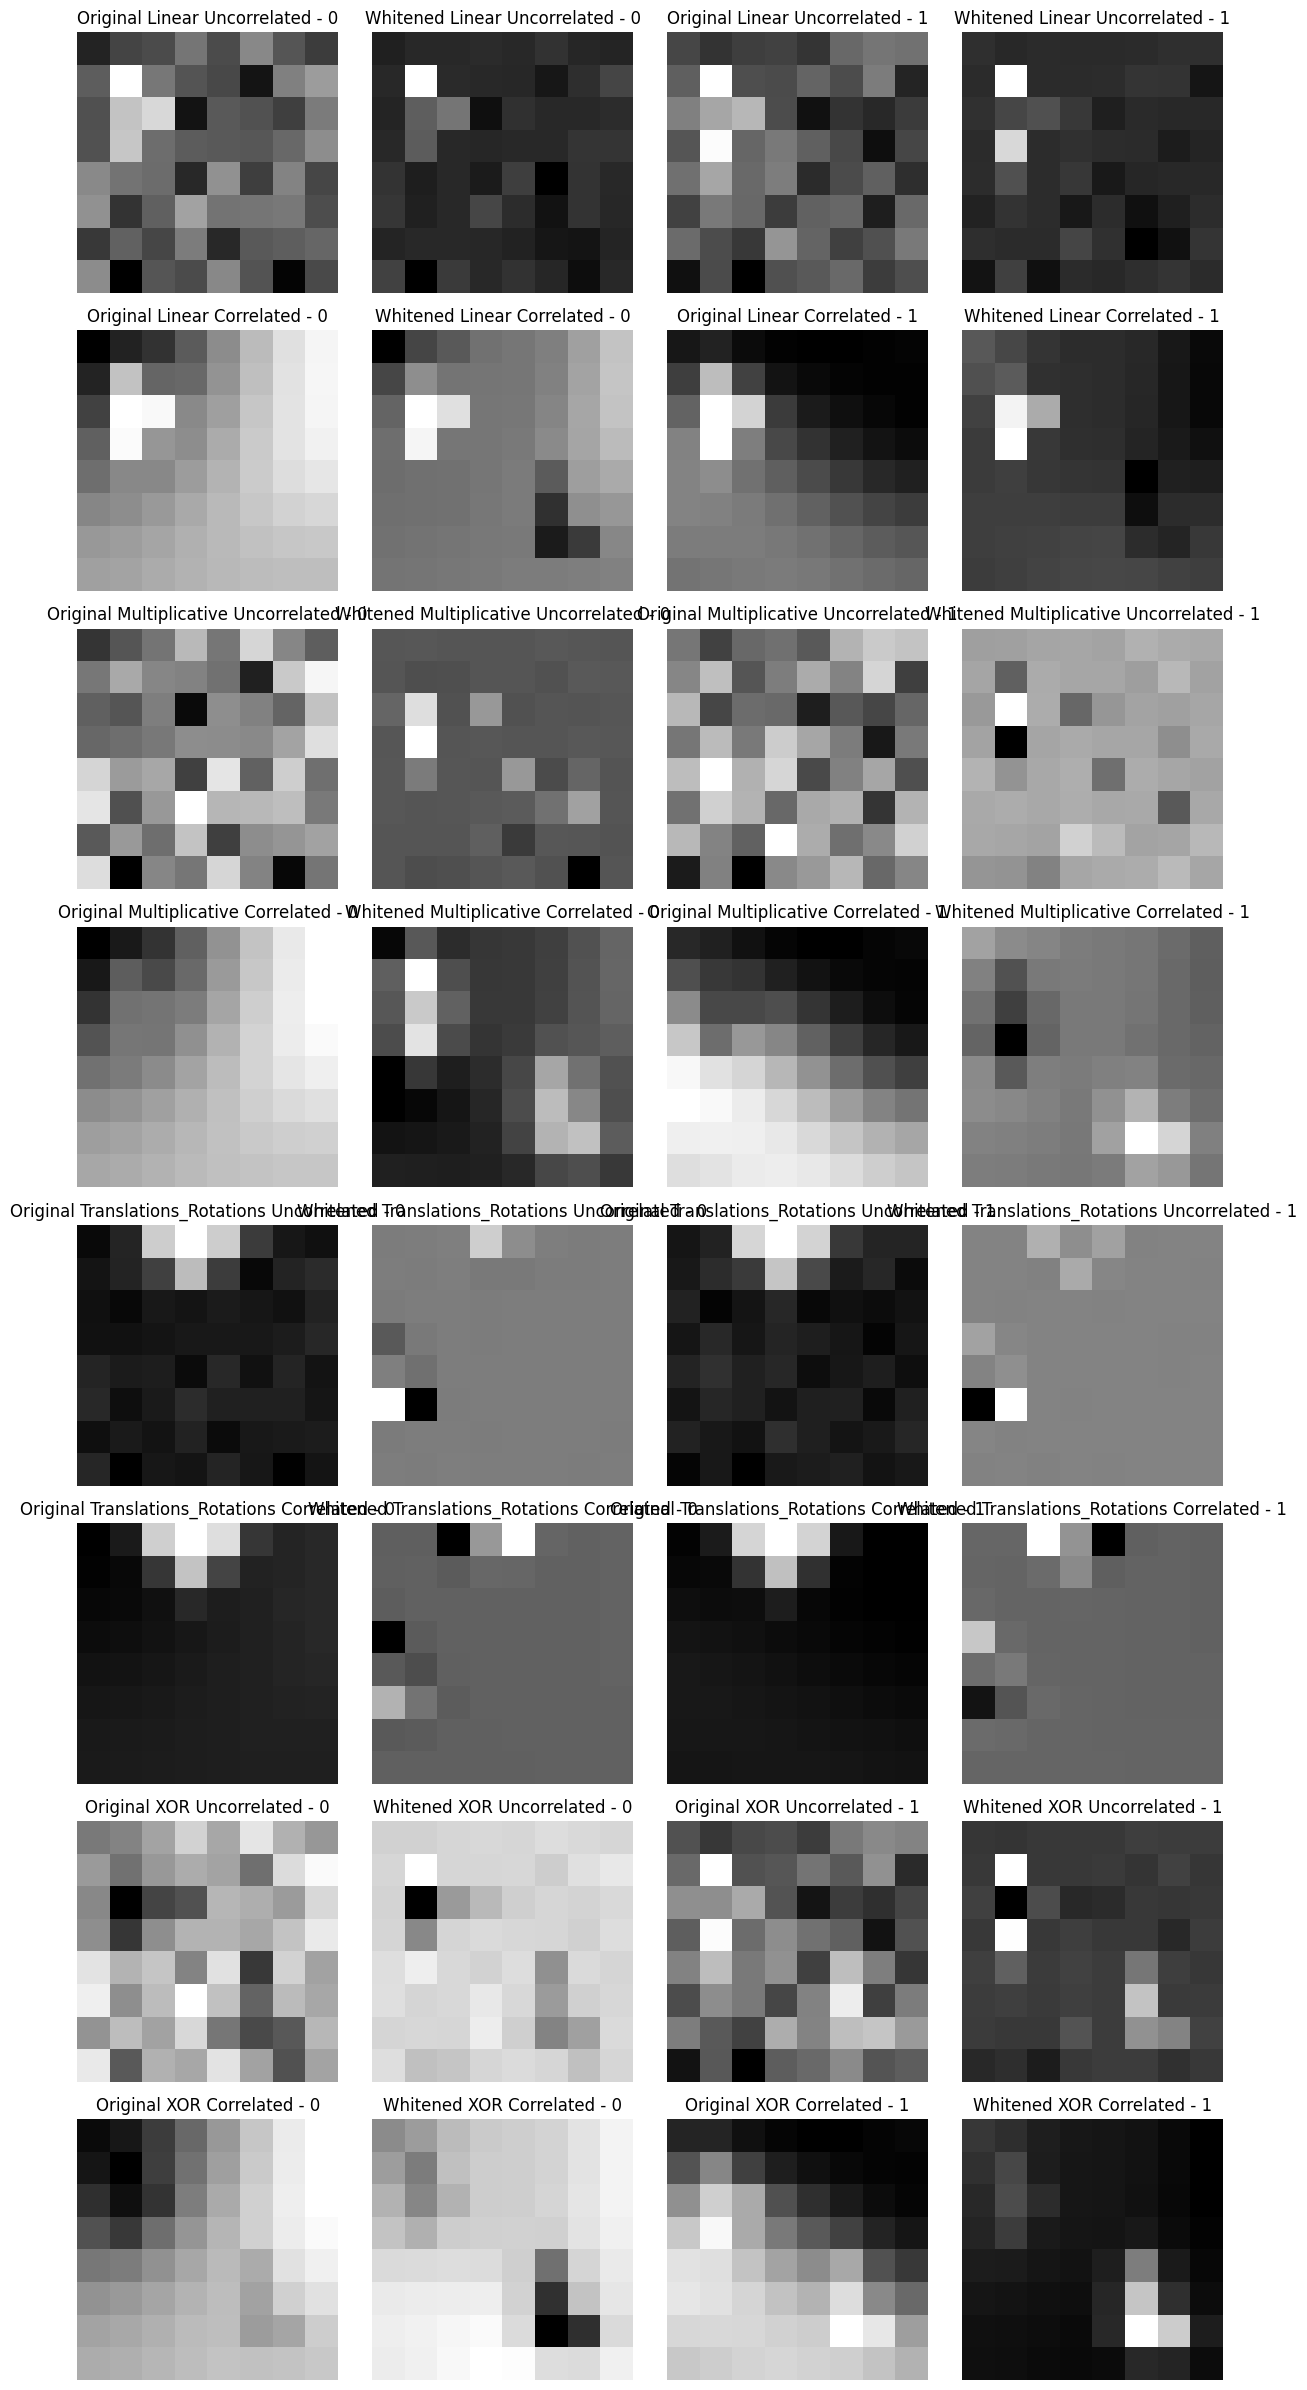

In [19]:
# Generate data using the provided function
original_data, whitened_data = generate_n_examples_with_whitening(whitening_method=symmetric_orthogonalization)
print(original_data.keys(), whitened_data.keys())

# Visualize the original and whitened data side by side for each scenario-background combination
fig, axes = plt.subplots(len(original_data.keys()), 4, figsize=(12, 24))

for i, key in enumerate(original_data.keys()):
    # Original data
    ax = axes[i, 0]
    ax.imshow(original_data[key][0].reshape(8, 8), cmap='gray')
    ax.set_title(f"Original {key} - 0")
    ax.axis('off')
    
    ax = axes[i, 1]
    ax.imshow(whitened_data[key][0].reshape(8, 8), cmap='gray')
    ax.set_title(f"Whitened {key} - 0")
    ax.axis('off')
    
    # Whitened data
    ax = axes[i, 2]
    ax.imshow(original_data[key][1].reshape(8, 8), cmap='gray')
    ax.set_title(f"Original {key} - 1")
    ax.axis('off')
    
    ax = axes[i, 3]
    ax.imshow(whitened_data[key][1].reshape(8, 8), cmap='gray')
    ax.set_title(f"Whitened {key} - 1")
    ax.axis('off')

plt.tight_layout()
plt.show()

# The first column shows one example from the original data for each scenario.
# The second column shows the corresponding whitened version of the example from the first column.
# The third column shows another example from the original data for each scenario.
# The fourth column shows the whitened version of the example from the third column.

In [21]:
import numpy as np
import pandas as pd
keys = ['Linear Uncorrelated', 'Linear Correlated', 
        'Multiplicative Uncorrelated', 'Multiplicative Correlated',
        'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated',
        'XOR Uncorrelated', 'XOR Correlated']

# Compute the mean absolute off-diagonal value for both original and whitened data
mean_abs_off_diag_original = []
mean_abs_off_diag_whitened = []

for key in keys:
    # Original Data
    corr_matrix_original = np.corrcoef(original_data[key].T)
    off_diag_original = corr_matrix_original[np.triu_indices(corr_matrix_original.shape[0], k=1)]
    mean_abs_off_diag_original.append(np.mean(np.abs(off_diag_original)))
    
    # Whitened Data
    corr_matrix_whitened = np.corrcoef(whitened_data[key].T)
    off_diag_whitened = corr_matrix_whitened[np.triu_indices(corr_matrix_whitened.shape[0], k=1)]
    mean_abs_off_diag_whitened.append(np.mean(np.abs(off_diag_whitened)))

# Constructing the table
table_data = {
    'Scenario-Background Combination': keys,
    'Mean Absolute Off-Diagonal (Original)': mean_abs_off_diag_original,
    'Mean Absolute Off-Diagonal (Whitened)': mean_abs_off_diag_whitened
}

table_df = pd.DataFrame(table_data)
table_df


Scenario-Background Combination  Mean Absolute Off-Diagonal (Original)  \
0                  Linear Uncorrelated                               0.706365   
1                    Linear Correlated                               0.653977   
2          Multiplicative Uncorrelated                               0.937938   
3            Multiplicative Correlated                               0.894061   
4  Translations_Rotations Uncorrelated                               0.658103   
5    Translations_Rotations Correlated                               0.662159   
6                     XOR Uncorrelated                               0.822769   
7                       XOR Correlated                               0.873078   

   Mean Absolute Off-Diagonal (Whitened)  
0                               0.781345  
1                               0.727436  
2                               0.609354  
3                               0.601444  
4                               0.940751  
5                               0.940018  
6                               0.677668  
7                               0.685692

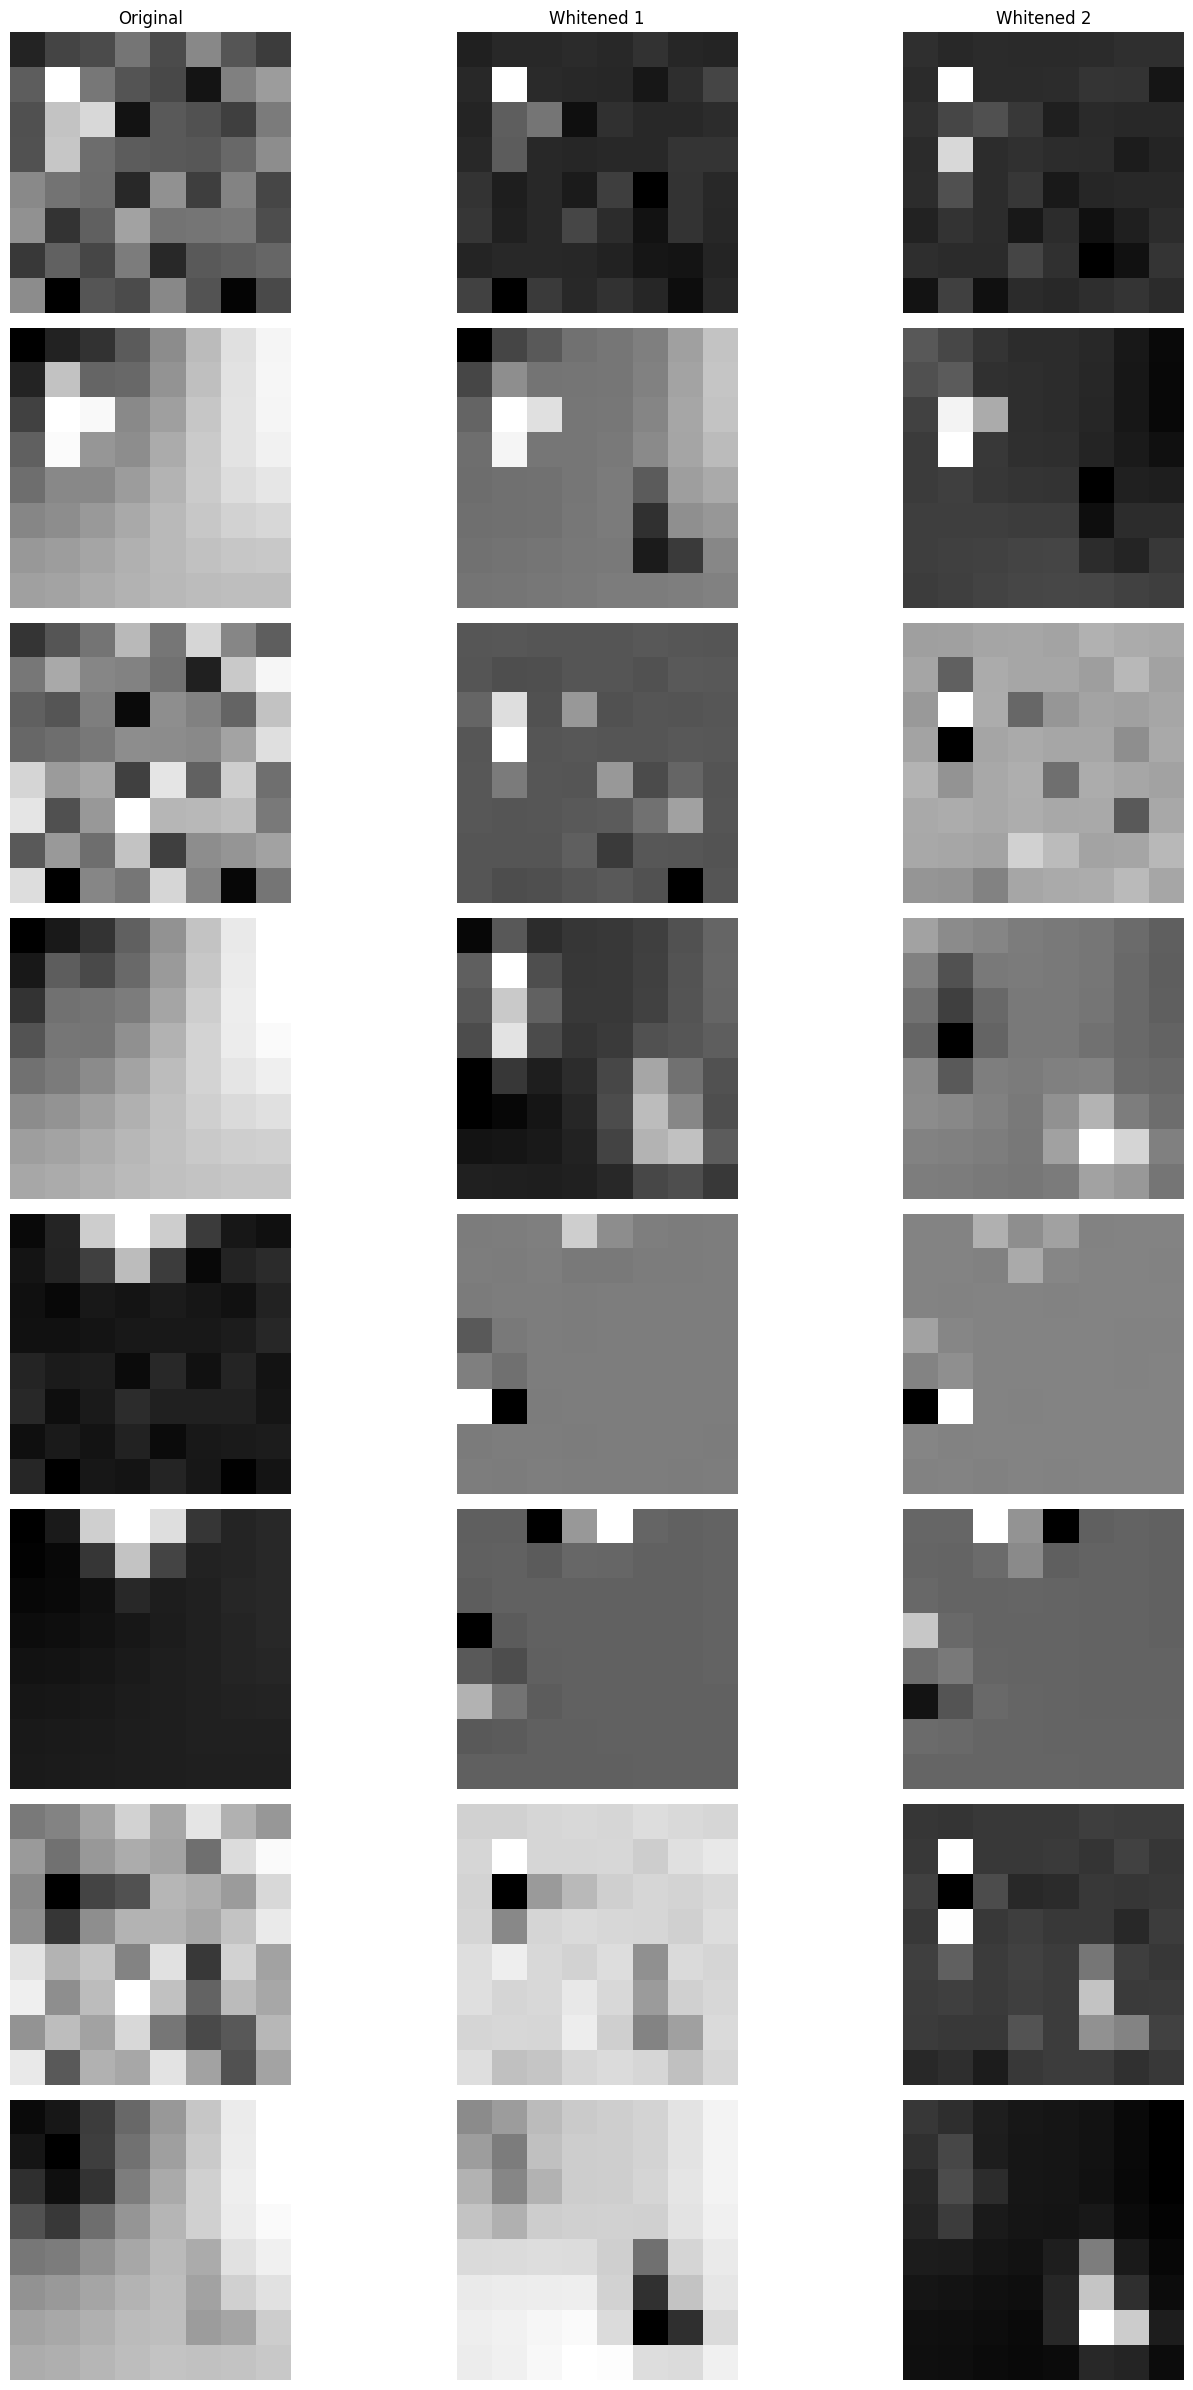

In [22]:
import matplotlib.pyplot as plt

# Visualize the tetromino data in the specified grid format
fig, axes = plt.subplots(8, 3, figsize=(15, 24))

for idx, key in enumerate(keys):
    # Original image
    axes[idx, 0].imshow(original_data[key][0].reshape(8, 8), cmap='gray')
    axes[idx, 0].axis('off')
    if idx == 0:
        axes[idx, 0].set_title('Original')
    
    # Whitened images
    for j in range(2):
        axes[idx, j+1].imshow(whitened_data[key][j].reshape(8, 8), cmap='gray')
        axes[idx, j+1].axis('off')
        if idx == 0:
            axes[idx, j+1].set_title(f'Whitened {j+1}')
    
    axes[idx, 0].set_ylabel(key, fontsize=12)

plt.tight_layout()
plt.show()


/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


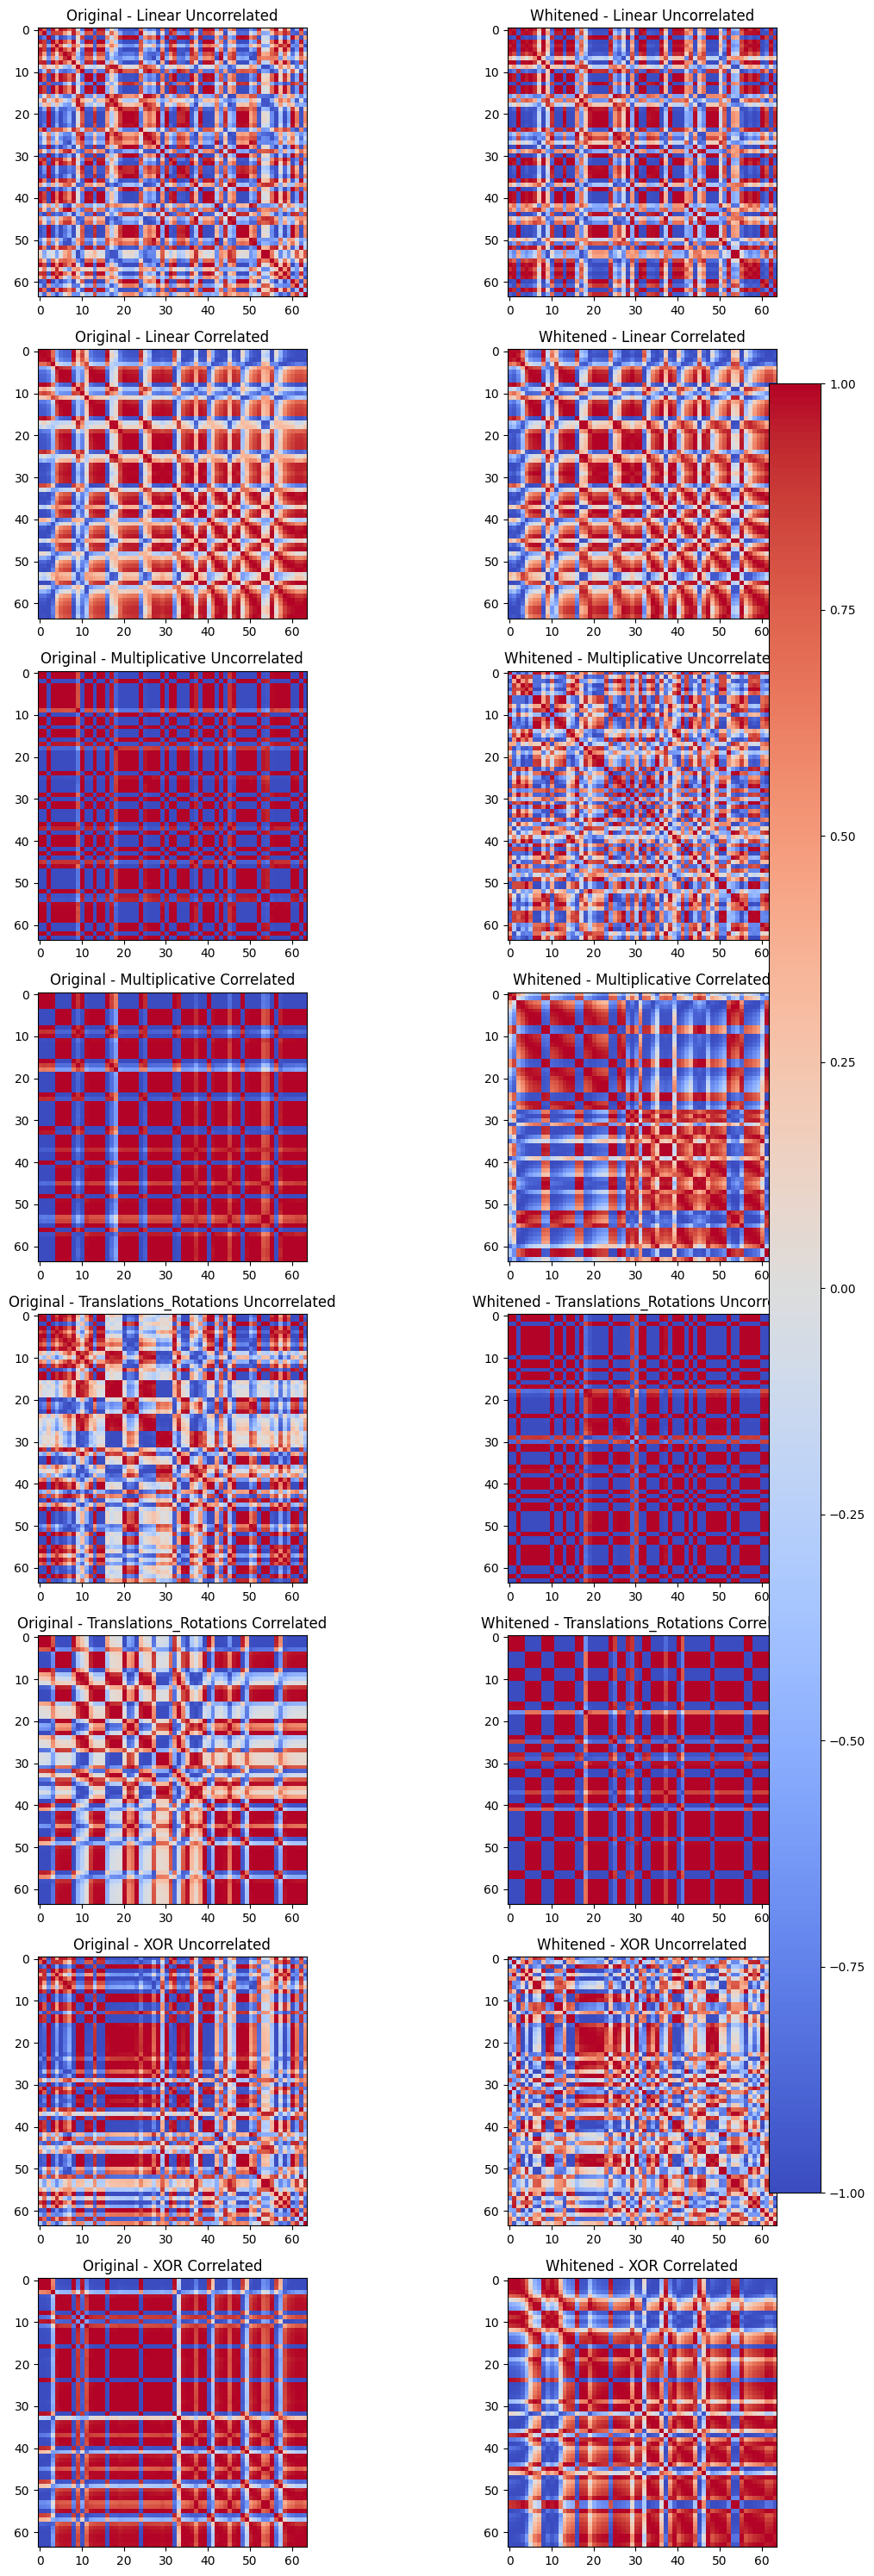

In [10]:
keys = ['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 
        'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 
        'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated']
        
# Plot the correlation matrices for original and whitened data
fig, axs = plt.subplots(8, 2, figsize=(12, 30))
cmap = "coolwarm"

for idx, key in enumerate(keys):
    # Original data correlation
    corr_orig = np.corrcoef(original_data[key].T)
    im1 = axs[idx, 0].imshow(corr_orig, vmin=-1, vmax=1, cmap=cmap)
    axs[idx, 0].set_title(f"Original - {key}")
    
    # Whitened data correlation
    corr_white = np.corrcoef(whitened_data[key].T)
    im2 = axs[idx, 1].imshow(corr_white, vmin=-1, vmax=1, cmap=cmap)
    axs[idx, 1].set_title(f"Whitened - {key}")

# Add colorbar and labels
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)

plt.tight_layout()
plt.show()

In [11]:
mean_diagonal_original = {}
mean_off_diagonal_original = {}

mean_diagonal_whitened = {}
mean_off_diagonal_whitened = {}

for key in keys:
    # Original data
    corr_matrix_original = np.corrcoef(original_data[key].T)
    mean_diagonal_original[key] = np.mean(np.diag(corr_matrix_original))
    mean_off_diagonal_original[key] = np.mean(np.abs(corr_matrix_original - np.diag(np.diag(corr_matrix_original))))
    
    # Whitened data
    corr_matrix_whitened = np.corrcoef(whitened_data[key].T)
    mean_diagonal_whitened[key] = np.mean(np.diag(corr_matrix_whitened))
    mean_off_diagonal_whitened[key] = np.mean(np.abs(corr_matrix_whitened - np.diag(np.diag(corr_matrix_whitened))))

mean_diagonal_original, mean_off_diagonal_original, mean_diagonal_whitened, mean_off_diagonal_whitened


({'Linear Uncorrelated': 1.0,
  'Linear Correlated': 1.0,
  'Multiplicative Uncorrelated': 1.0,
  'Multiplicative Correlated': 1.0,
  'Translations_Rotations Uncorrelated': 1.0,
  'Translations_Rotations Correlated': 1.0,
  'XOR Uncorrelated': 1.0,
  'XOR Correlated': 1.0},
 {'Linear Uncorrelated': 0.6601689145174179,
  'Linear Correlated': 0.6181854239651168,
  'Multiplicative Uncorrelated': 0.9632791496491693,
  'Multiplicative Correlated': 0.9386740858493343,
  'Translations_Rotations Uncorrelated': 0.6275292102896368,
  'Translations_Rotations Correlated': 0.6264558677076499,
  'XOR Uncorrelated': 0.7046959217842166,
  'XOR Correlated': 0.8384395665742941},
 {'Linear Uncorrelated': 1.0,
  'Linear Correlated': 1.0,
  'Multiplicative Uncorrelated': 1.0,
  'Multiplicative Correlated': 1.0,
  'Translations_Rotations Uncorrelated': 1.0,
  'Translations_Rotations Correlated': 1.0,
  'XOR Uncorrelated': 1.0,
  'XOR Correlated': 1.0},
 {'Linear Uncorrelated': 0.7217210622533752,
  'Linear 

## Partial Regression

dict_keys(['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated']) dict_keys(['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated'])


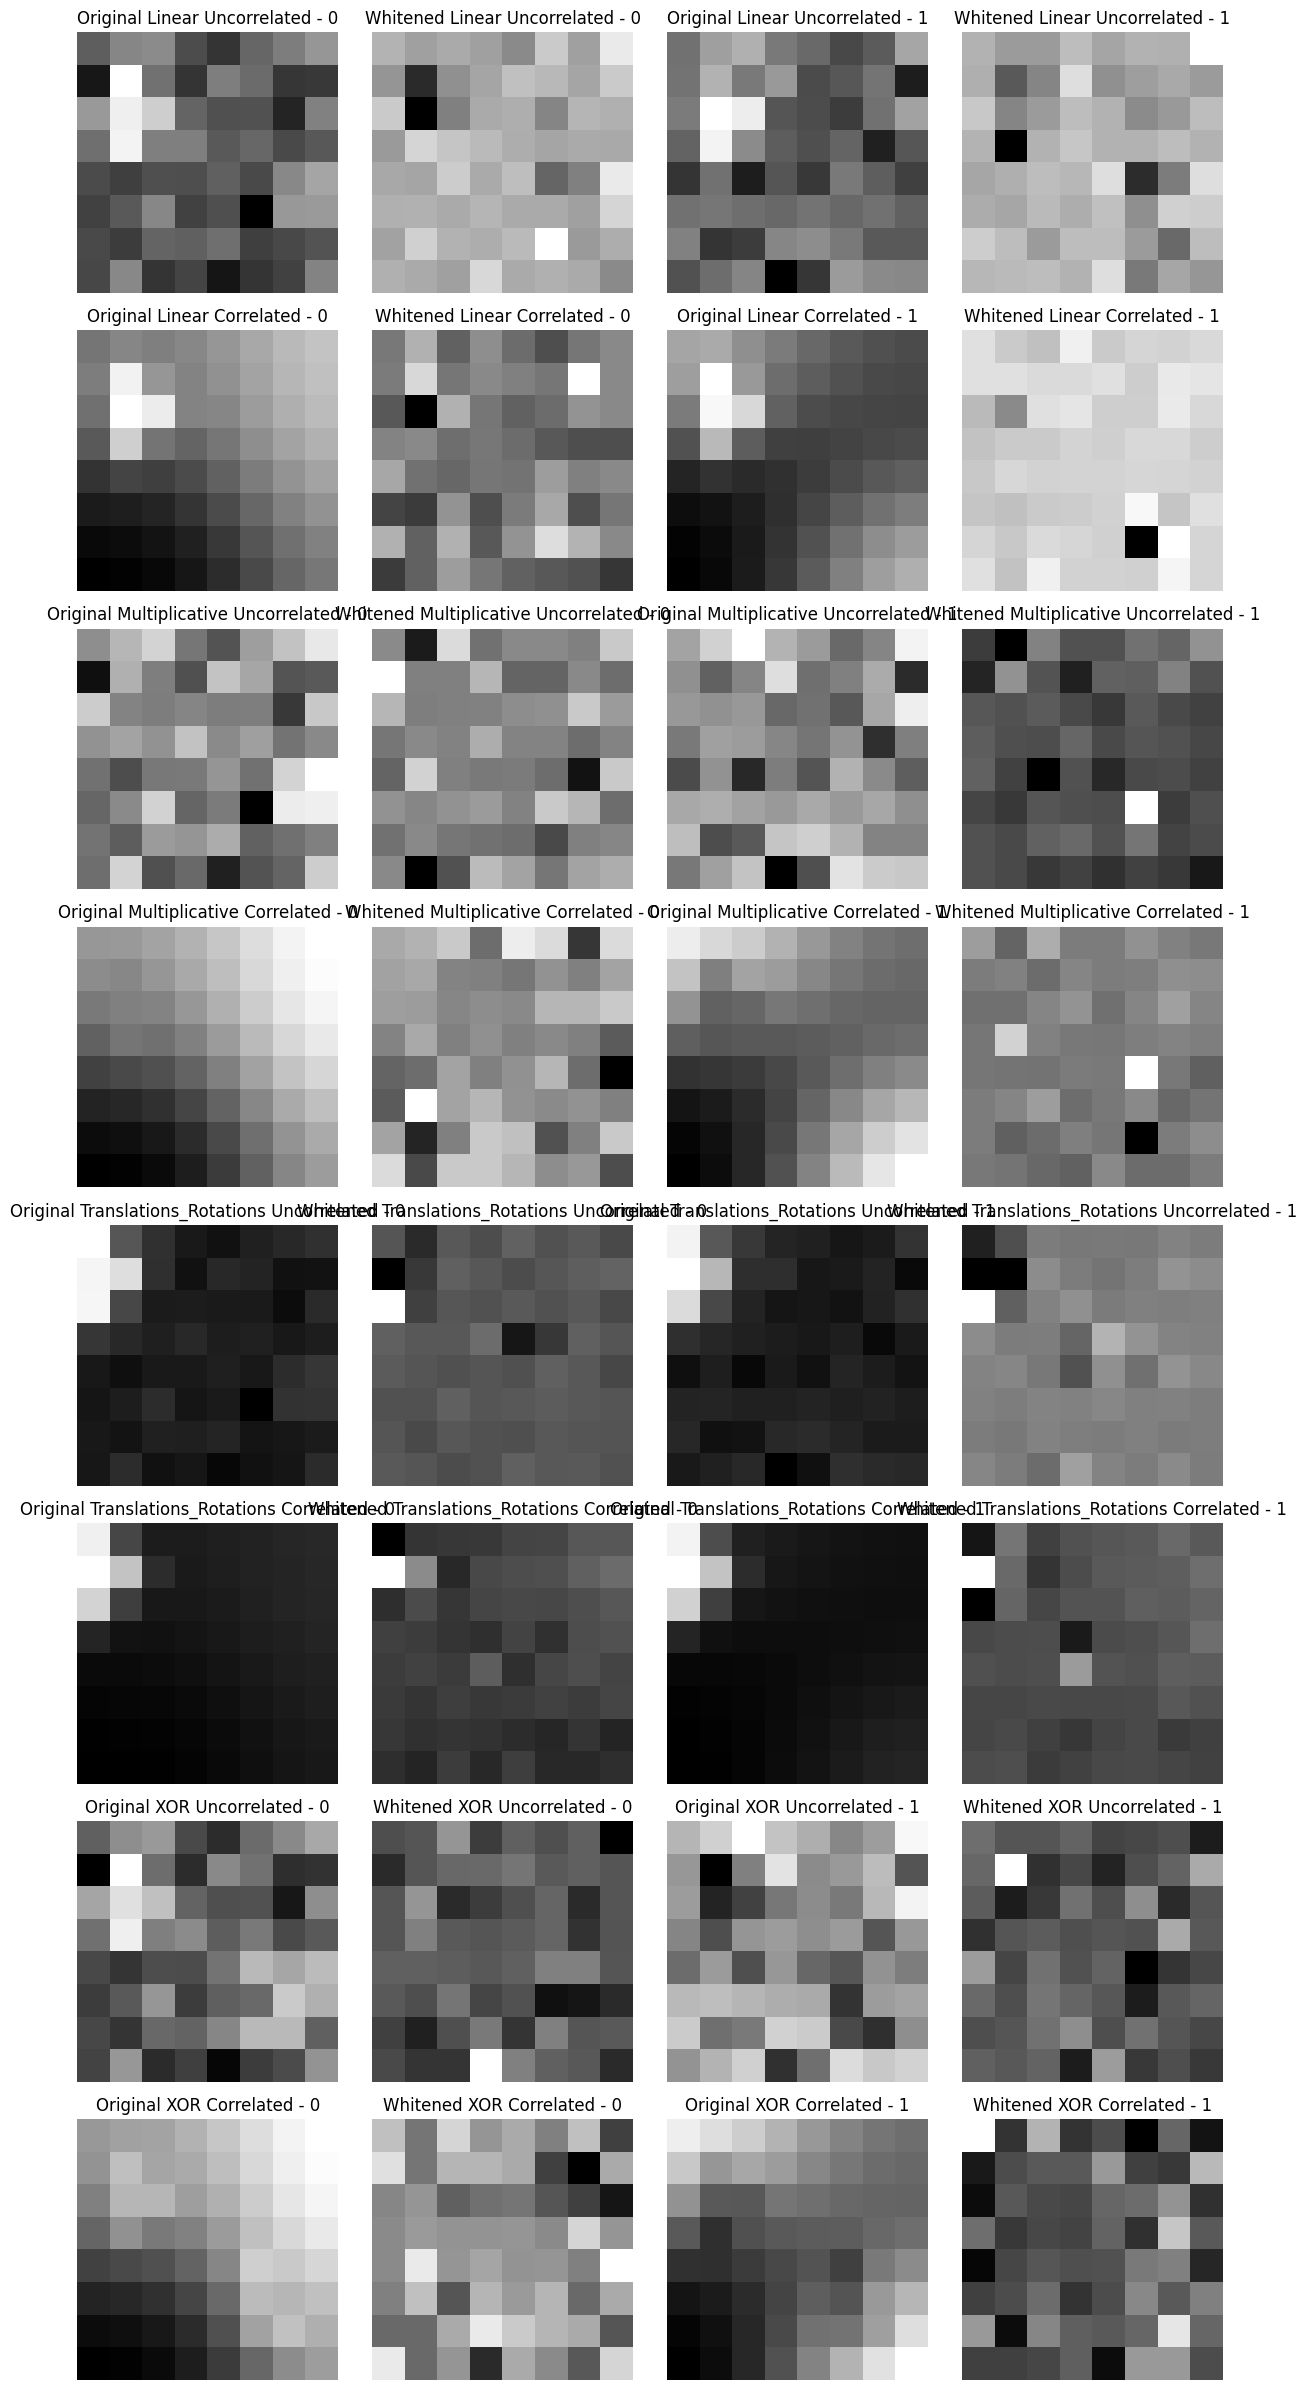

In [12]:
# Generate data using the provided function
original_data, whitened_data = generate_n_examples_with_whitening(whitening_method=partial_regression)
print(original_data.keys(), whitened_data.keys())

# Visualize the original and whitened data side by side for each scenario-background combination
fig, axes = plt.subplots(len(original_data.keys()), 4, figsize=(12, 24))

for i, key in enumerate(original_data.keys()):
    # Original data
    ax = axes[i, 0]
    ax.imshow(original_data[key][0].reshape(8, 8), cmap='gray')
    ax.set_title(f"Original {key} - 0")
    ax.axis('off')
    
    ax = axes[i, 1]
    ax.imshow(whitened_data[key][0].reshape(8, 8), cmap='gray')
    ax.set_title(f"Whitened {key} - 0")
    ax.axis('off')
    
    # Whitened data
    ax = axes[i, 2]
    ax.imshow(original_data[key][1].reshape(8, 8), cmap='gray')
    ax.set_title(f"Original {key} - 1")
    ax.axis('off')
    
    ax = axes[i, 3]
    ax.imshow(whitened_data[key][1].reshape(8, 8), cmap='gray')
    ax.set_title(f"Whitened {key} - 1")
    ax.axis('off')

plt.tight_layout()
plt.show()

# The first column shows one example from the original data for each scenario.
# The second column shows the corresponding whitened version of the example from the first column.
# The third column shows another example from the original data for each scenario.
# The fourth column shows the whitened version of the example from the third column.

/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


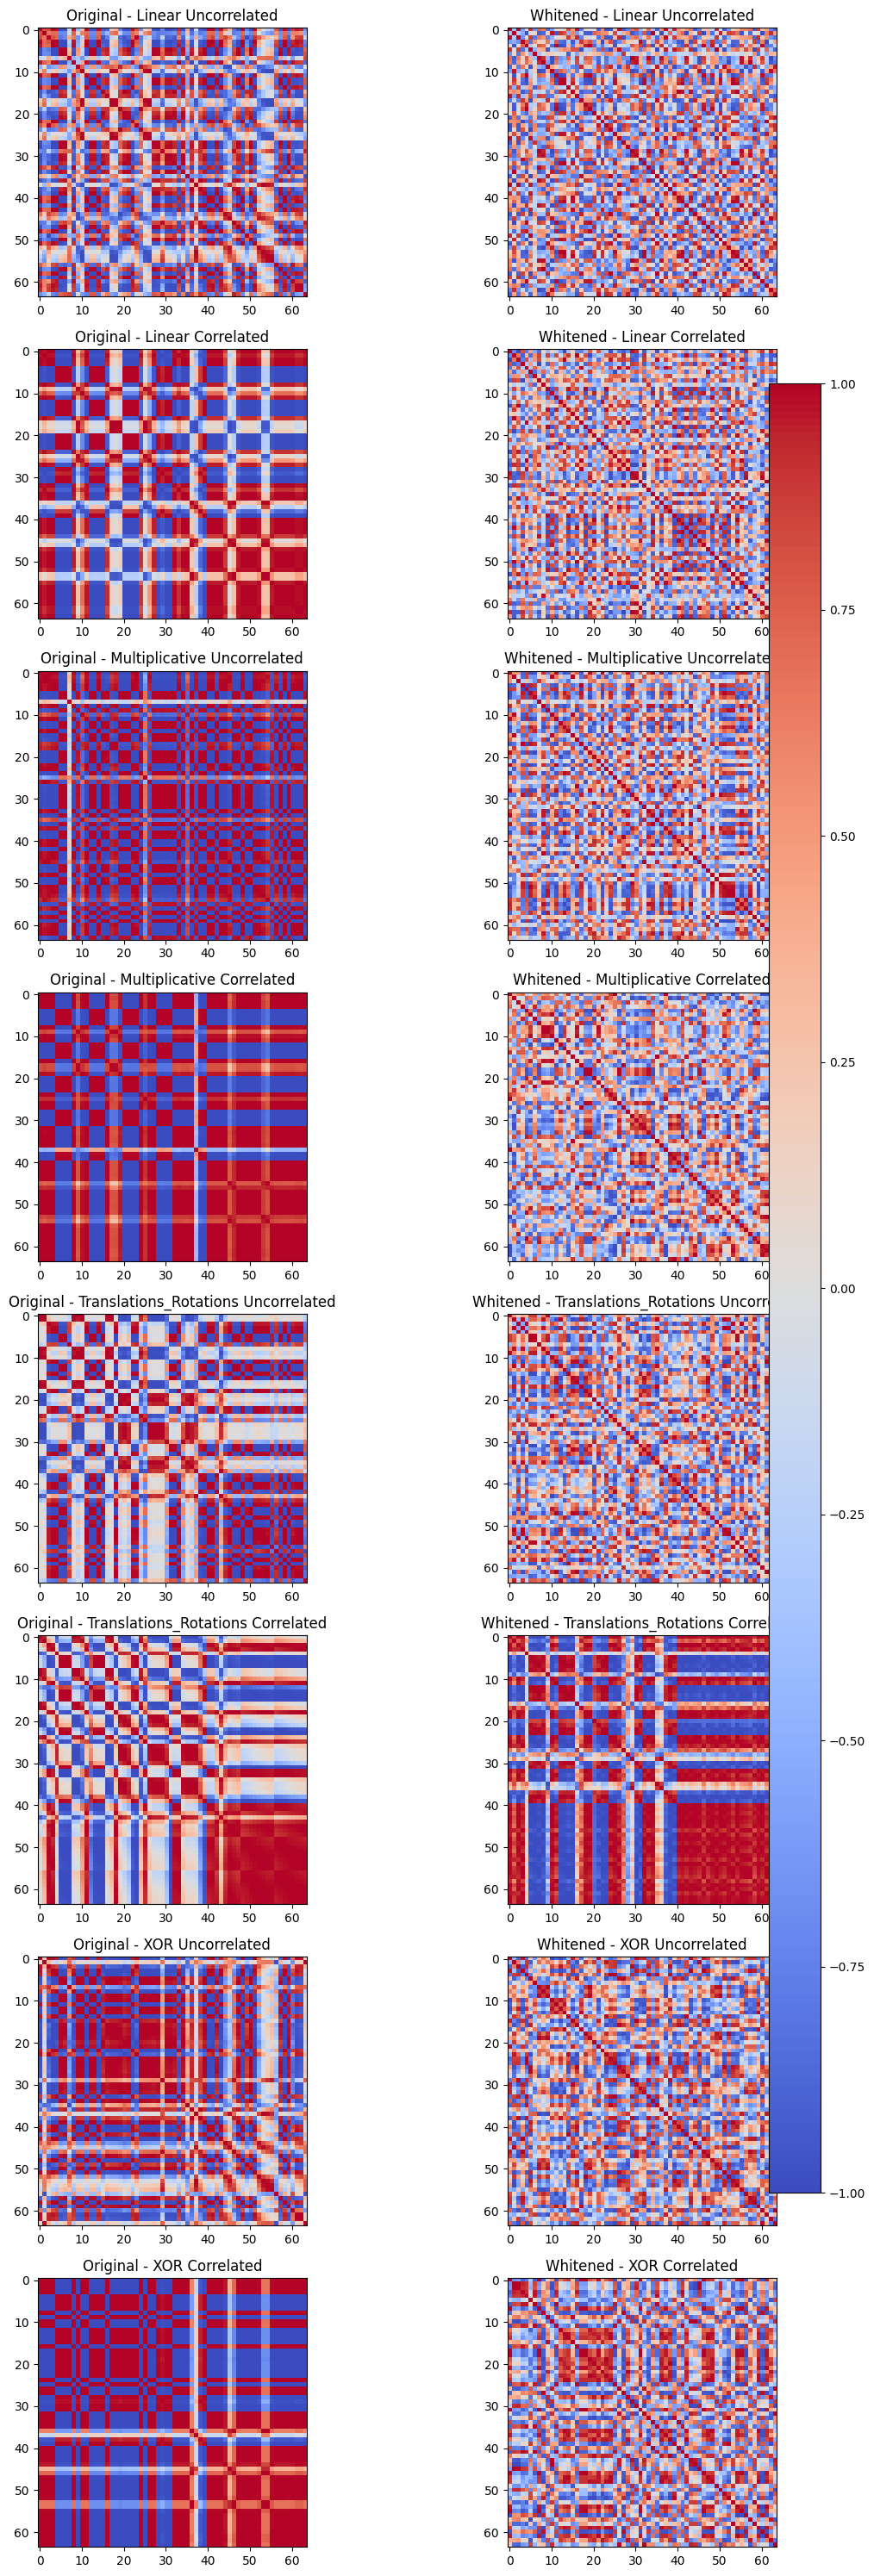

In [13]:
keys = ['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 
        'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 
        'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated']
        
# Plot the correlation matrices for original and whitened data
fig, axs = plt.subplots(8, 2, figsize=(12, 30))
cmap = "coolwarm"

for idx, key in enumerate(keys):
    # Original data correlation
    corr_orig = np.corrcoef(original_data[key].T)
    im1 = axs[idx, 0].imshow(corr_orig, vmin=-1, vmax=1, cmap=cmap)
    axs[idx, 0].set_title(f"Original - {key}")
    
    # Whitened data correlation
    corr_white = np.corrcoef(whitened_data[key].T)
    im2 = axs[idx, 1].imshow(corr_white, vmin=-1, vmax=1, cmap=cmap)
    axs[idx, 1].set_title(f"Whitened - {key}")

# Add colorbar and labels
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)

plt.tight_layout()
plt.show()

In [14]:
mean_diagonal_original = {}
mean_off_diagonal_original = {}

mean_diagonal_whitened = {}
mean_off_diagonal_whitened = {}

for key in keys:
    # Original data
    corr_matrix_original = np.corrcoef(original_data[key].T)
    mean_diagonal_original[key] = np.mean(np.diag(corr_matrix_original))
    mean_off_diagonal_original[key] = np.mean(np.abs(corr_matrix_original - np.diag(np.diag(corr_matrix_original))))
    
    # Whitened data
    corr_matrix_whitened = np.corrcoef(whitened_data[key].T)
    mean_diagonal_whitened[key] = np.mean(np.diag(corr_matrix_whitened))
    mean_off_diagonal_whitened[key] = np.mean(np.abs(corr_matrix_whitened - np.diag(np.diag(corr_matrix_whitened))))

mean_diagonal_original, mean_off_diagonal_original, mean_diagonal_whitened, mean_off_diagonal_whitened


({'Linear Uncorrelated': 1.0,
  'Linear Correlated': 1.0,
  'Multiplicative Uncorrelated': 1.0,
  'Multiplicative Correlated': 1.0,
  'Translations_Rotations Uncorrelated': 1.0,
  'Translations_Rotations Correlated': 1.0,
  'XOR Uncorrelated': 1.0,
  'XOR Correlated': 1.0},
 {'Linear Uncorrelated': 0.6614325094105773,
  'Linear Correlated': 0.7271276072668771,
  'Multiplicative Uncorrelated': 0.9248352308673976,
  'Multiplicative Correlated': 0.9245881554722784,
  'Translations_Rotations Uncorrelated': 0.612252895436346,
  'Translations_Rotations Correlated': 0.6119635666202938,
  'XOR Uncorrelated': 0.7248095999110522,
  'XOR Correlated': 0.8993479166387541},
 {'Linear Uncorrelated': 1.0,
  'Linear Correlated': 1.0,
  'Multiplicative Uncorrelated': 1.0,
  'Multiplicative Correlated': 1.0,
  'Translations_Rotations Uncorrelated': 1.0,
  'Translations_Rotations Correlated': 1.0,
  'XOR Uncorrelated': 1.0,
  'XOR Correlated': 1.0},
 {'Linear Uncorrelated': 0.572840038859608,
  'Linear Co

## Cholesky

Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
dict_keys(['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated']) dict_keys(['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated'])


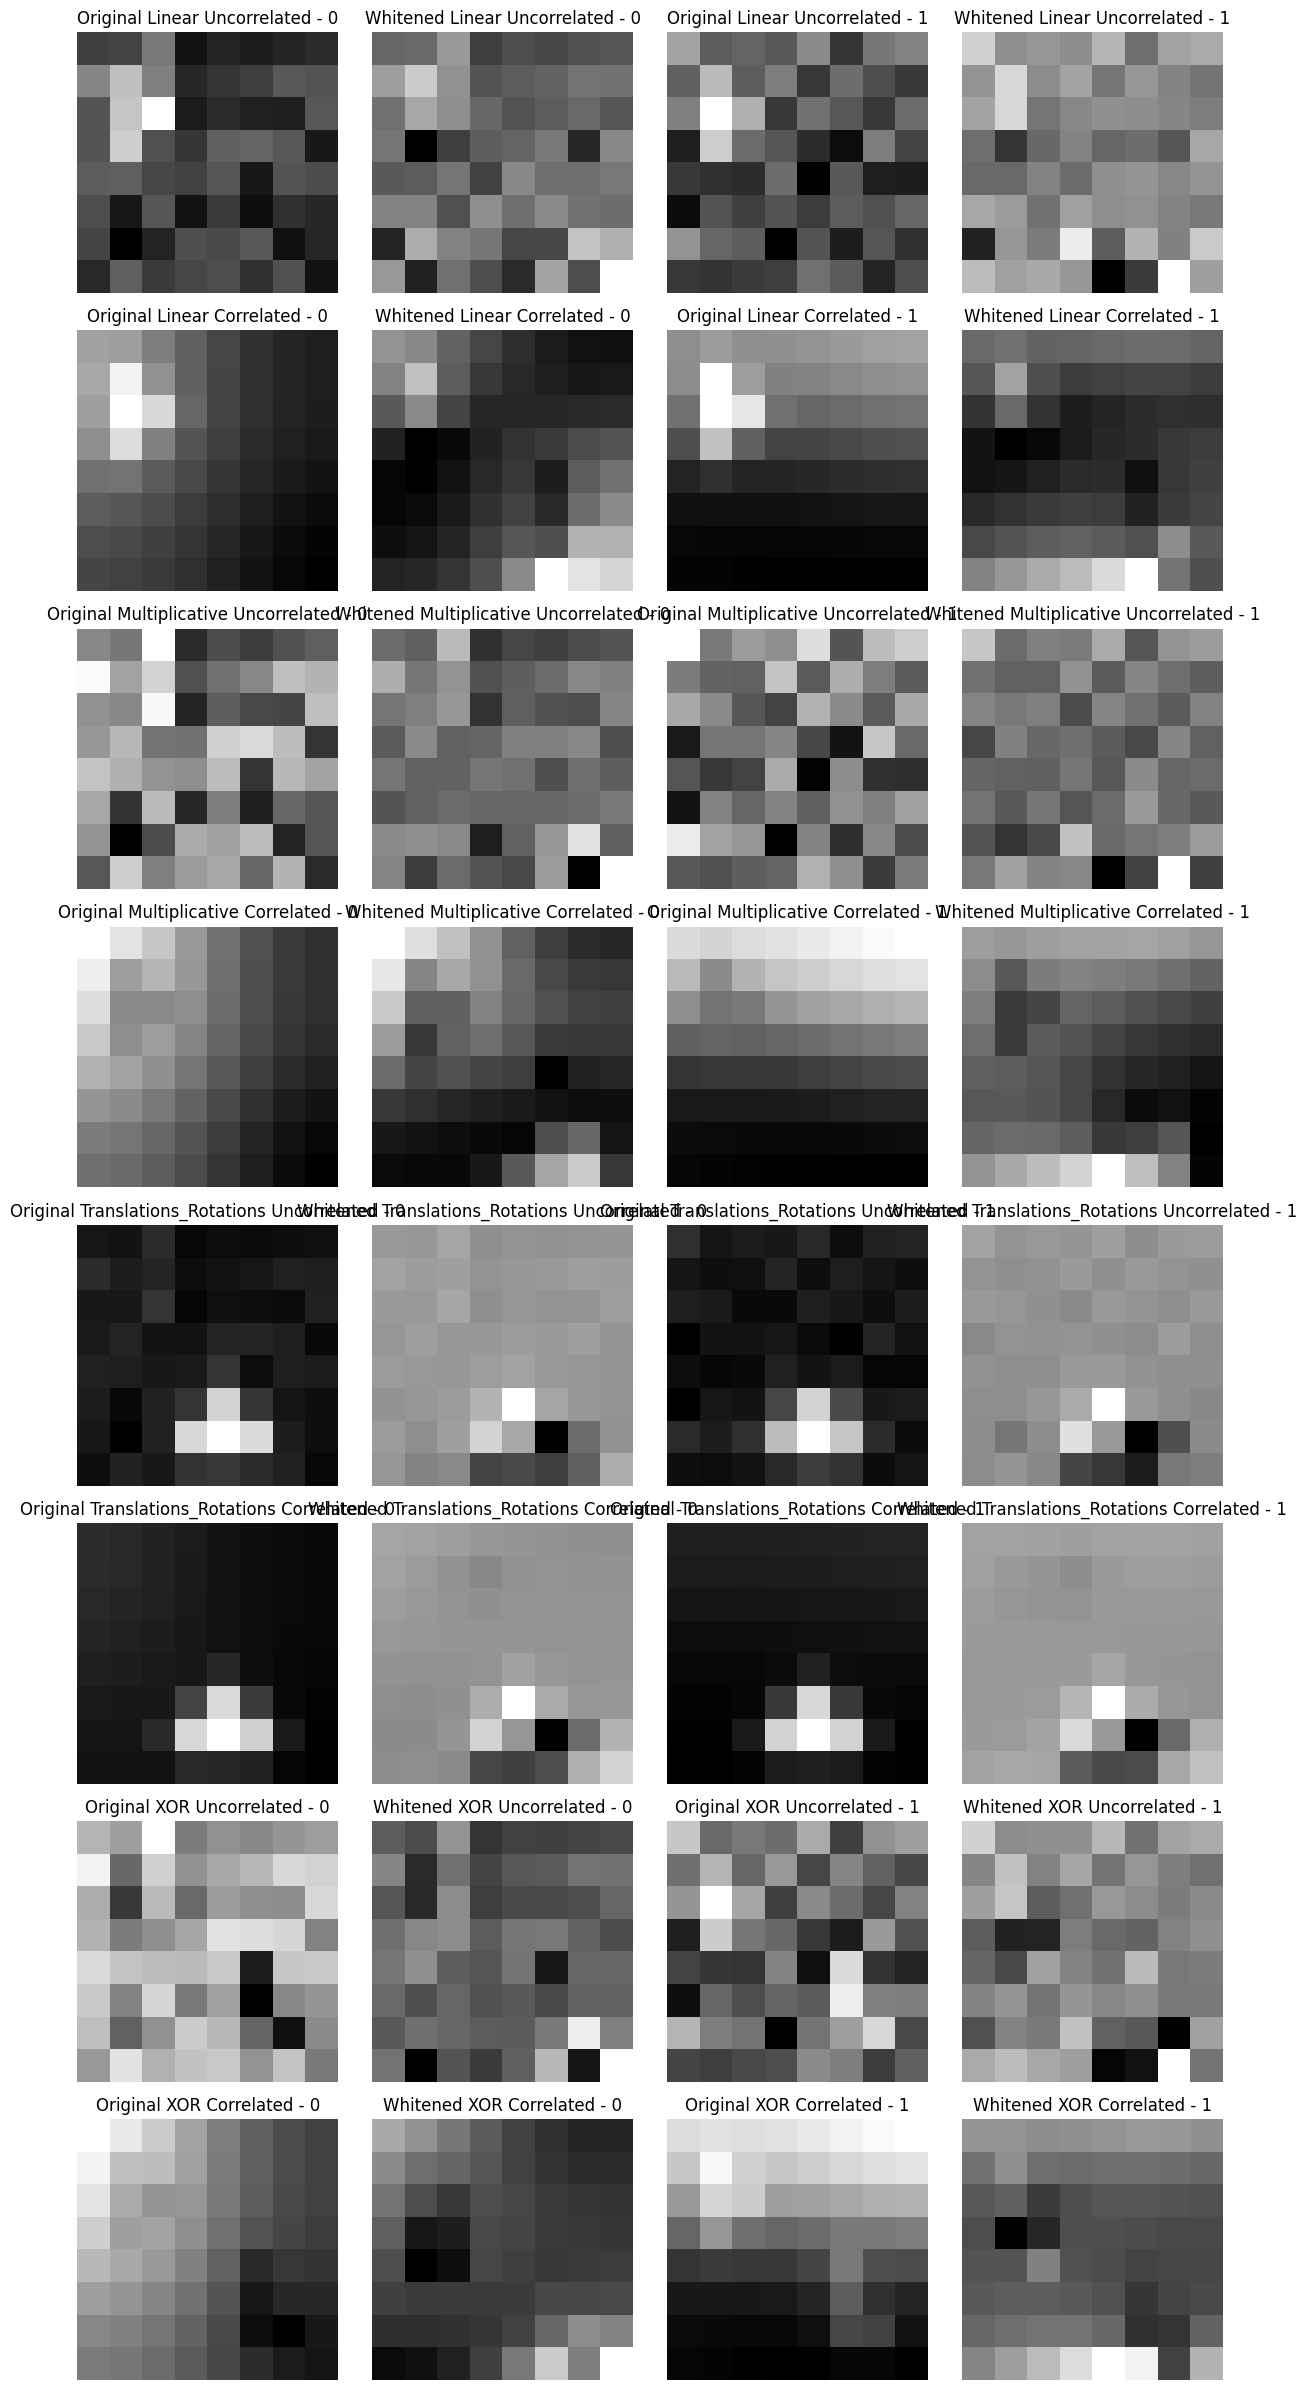

In [15]:
# Generate data using the provided function
original_data, whitened_data = generate_n_examples_with_whitening(whitening_method=cholesky_whitening)
print(original_data.keys(), whitened_data.keys())

# Visualize the original and whitened data side by side for each scenario-background combination
fig, axes = plt.subplots(len(original_data.keys()), 4, figsize=(12, 24))

for i, key in enumerate(original_data.keys()):
    # Original data
    ax = axes[i, 0]
    ax.imshow(original_data[key][0].reshape(8, 8), cmap='gray')
    ax.set_title(f"Original {key} - 0")
    ax.axis('off')
    
    ax = axes[i, 1]
    ax.imshow(whitened_data[key][0].reshape(8, 8), cmap='gray')
    ax.set_title(f"Whitened {key} - 0")
    ax.axis('off')
    
    # Whitened data
    ax = axes[i, 2]
    ax.imshow(original_data[key][1].reshape(8, 8), cmap='gray')
    ax.set_title(f"Original {key} - 1")
    ax.axis('off')
    
    ax = axes[i, 3]
    ax.imshow(whitened_data[key][1].reshape(8, 8), cmap='gray')
    ax.set_title(f"Whitened {key} - 1")
    ax.axis('off')

plt.tight_layout()
plt.show()

# The first column shows one example from the original data for each scenario.
# The second column shows the corresponding whitened version of the example from the first column.
# The third column shows another example from the original data for each scenario.
# The fourth column shows the whitened version of the example from the third column.

/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


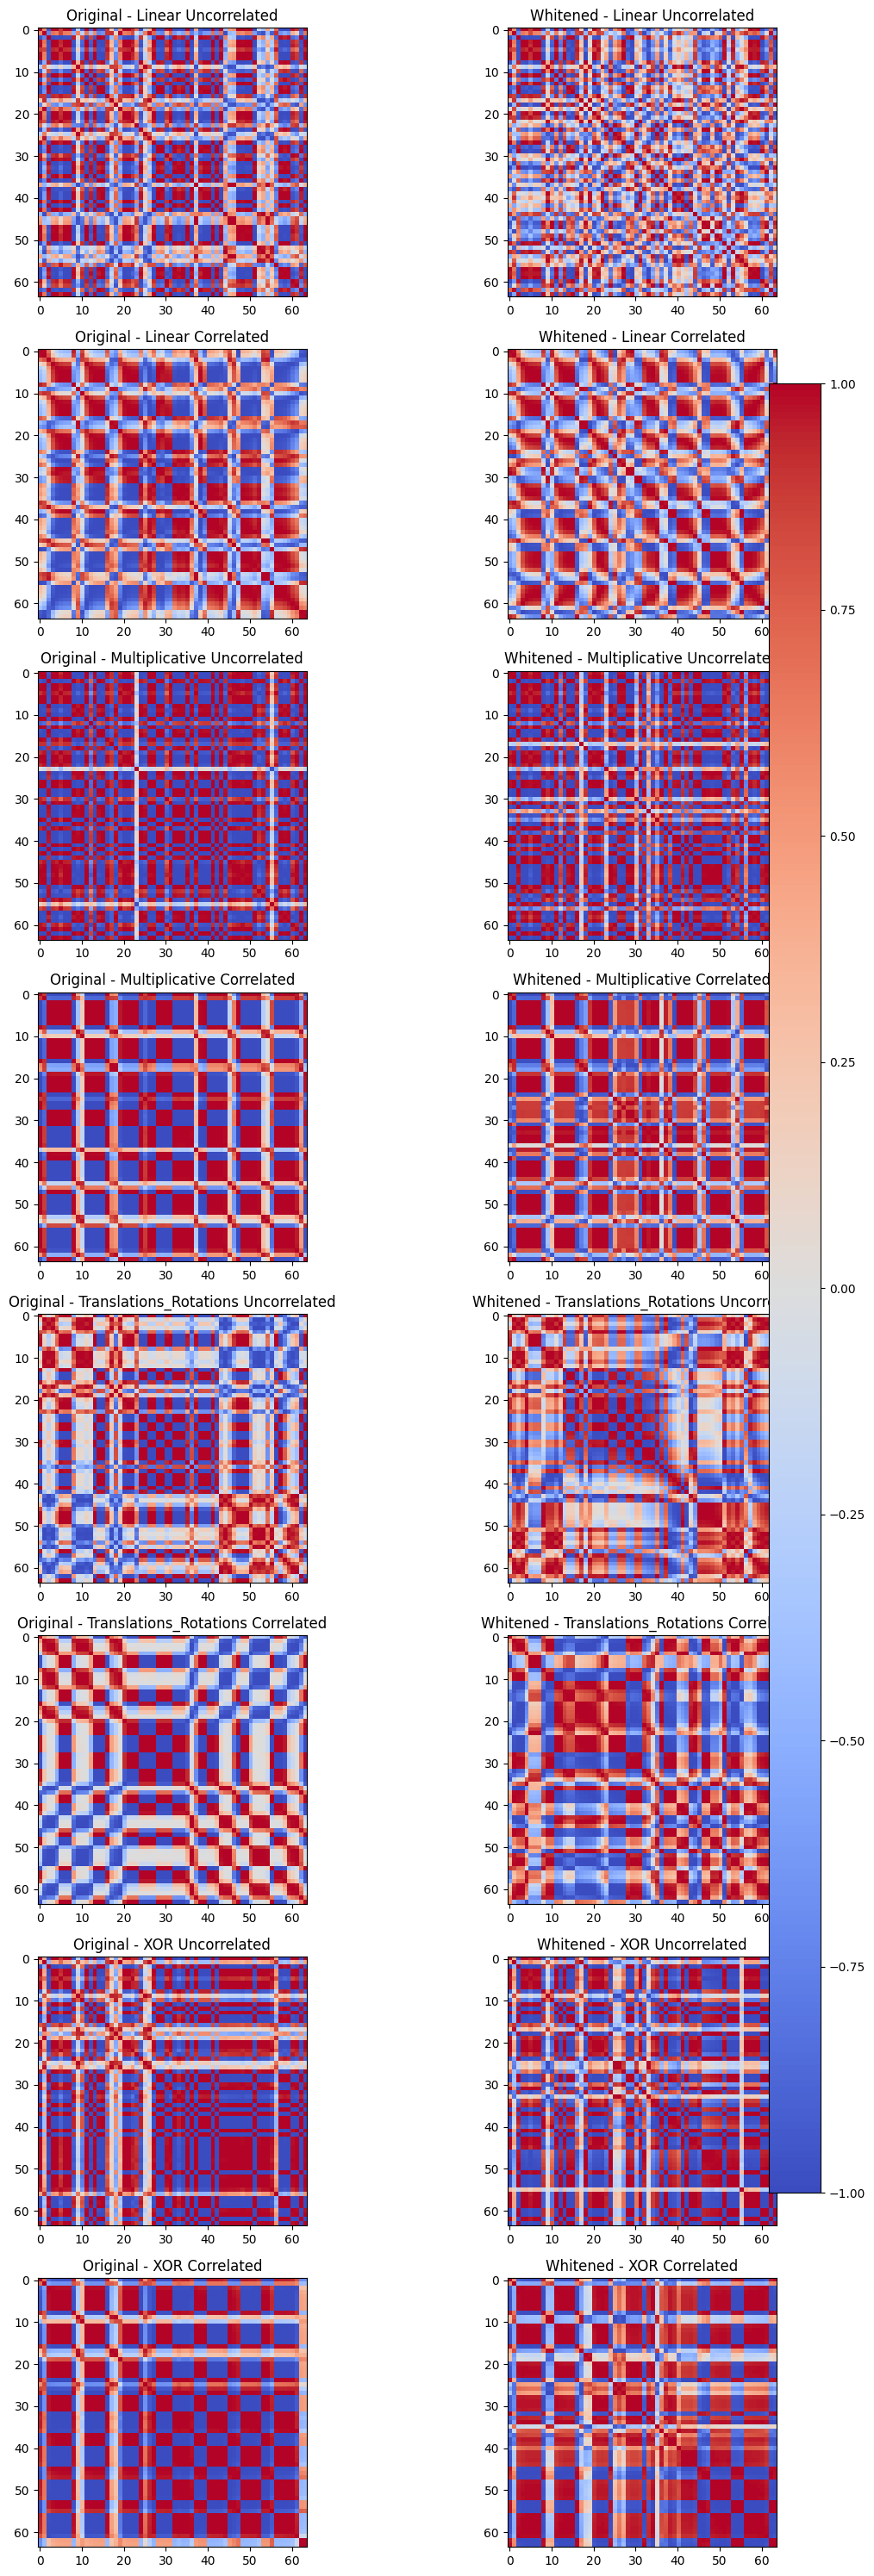

In [16]:
keys = ['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 
        'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 
        'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated']
        
# Plot the correlation matrices for original and whitened data
fig, axs = plt.subplots(8, 2, figsize=(12, 30))
cmap = "coolwarm"

for idx, key in enumerate(keys):
    # Original data correlation
    corr_orig = np.corrcoef(original_data[key].T)
    im1 = axs[idx, 0].imshow(corr_orig, vmin=-1, vmax=1, cmap=cmap)
    axs[idx, 0].set_title(f"Original - {key}")
    
    # Whitened data correlation
    corr_white = np.corrcoef(whitened_data[key].T)
    im2 = axs[idx, 1].imshow(corr_white, vmin=-1, vmax=1, cmap=cmap)
    axs[idx, 1].set_title(f"Whitened - {key}")

# Add colorbar and labels
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)

plt.tight_layout()
plt.show()

In [17]:
mean_diagonal_original = {}
mean_off_diagonal_original = {}

mean_diagonal_whitened = {}
mean_off_diagonal_whitened = {}

for key in keys:
    # Original data
    corr_matrix_original = np.corrcoef(original_data[key].T)
    mean_diagonal_original[key] = np.mean(np.diag(corr_matrix_original))
    mean_off_diagonal_original[key] = np.mean(np.abs(corr_matrix_original - np.diag(np.diag(corr_matrix_original))))
    
    # Whitened data
    corr_matrix_whitened = np.corrcoef(whitened_data[key].T)
    mean_diagonal_whitened[key] = np.mean(np.diag(corr_matrix_whitened))
    mean_off_diagonal_whitened[key] = np.mean(np.abs(corr_matrix_whitened - np.diag(np.diag(corr_matrix_whitened))))

mean_diagonal_original, mean_off_diagonal_original, mean_diagonal_whitened, mean_off_diagonal_whitened


({'Linear Uncorrelated': 1.0,
  'Linear Correlated': 1.0,
  'Multiplicative Uncorrelated': 1.0,
  'Multiplicative Correlated': 1.0,
  'Translations_Rotations Uncorrelated': 1.0,
  'Translations_Rotations Correlated': 1.0,
  'XOR Uncorrelated': 1.0,
  'XOR Correlated': 1.0},
 {'Linear Uncorrelated': 0.7288498153989938,
  'Linear Correlated': 0.6781354896330563,
  'Multiplicative Uncorrelated': 0.9045306446822209,
  'Multiplicative Correlated': 0.7975323571374969,
  'Translations_Rotations Uncorrelated': 0.6288917844481856,
  'Translations_Rotations Correlated': 0.5907554297851799,
  'XOR Uncorrelated': 0.8073058175817271,
  'XOR Correlated': 0.8404455729230365},
 {'Linear Uncorrelated': 1.0,
  'Linear Correlated': 1.0,
  'Multiplicative Uncorrelated': 1.0,
  'Multiplicative Correlated': 1.0,
  'Translations_Rotations Uncorrelated': 1.0,
  'Translations_Rotations Correlated': 1.0,
  'XOR Uncorrelated': 1.0,
  'XOR Correlated': 1.0},
 {'Linear Uncorrelated': 0.6281205383342123,
  'Linear 

## Optimal Signal Preserving

Applied sphering. Matrix shape: (4, 64)
Applied sphering. Matrix shape: (4, 64)
Applied sphering. Matrix shape: (4, 64)
Applied sphering. Matrix shape: (4, 64)
Applied sphering. Matrix shape: (4, 64)
Applied sphering. Matrix shape: (4, 64)
Applied sphering. Matrix shape: (4, 64)
Applied sphering. Matrix shape: (4, 64)
dict_keys(['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated']) dict_keys(['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated'])


TypeError: Image data of dtype complex128 cannot be converted to float

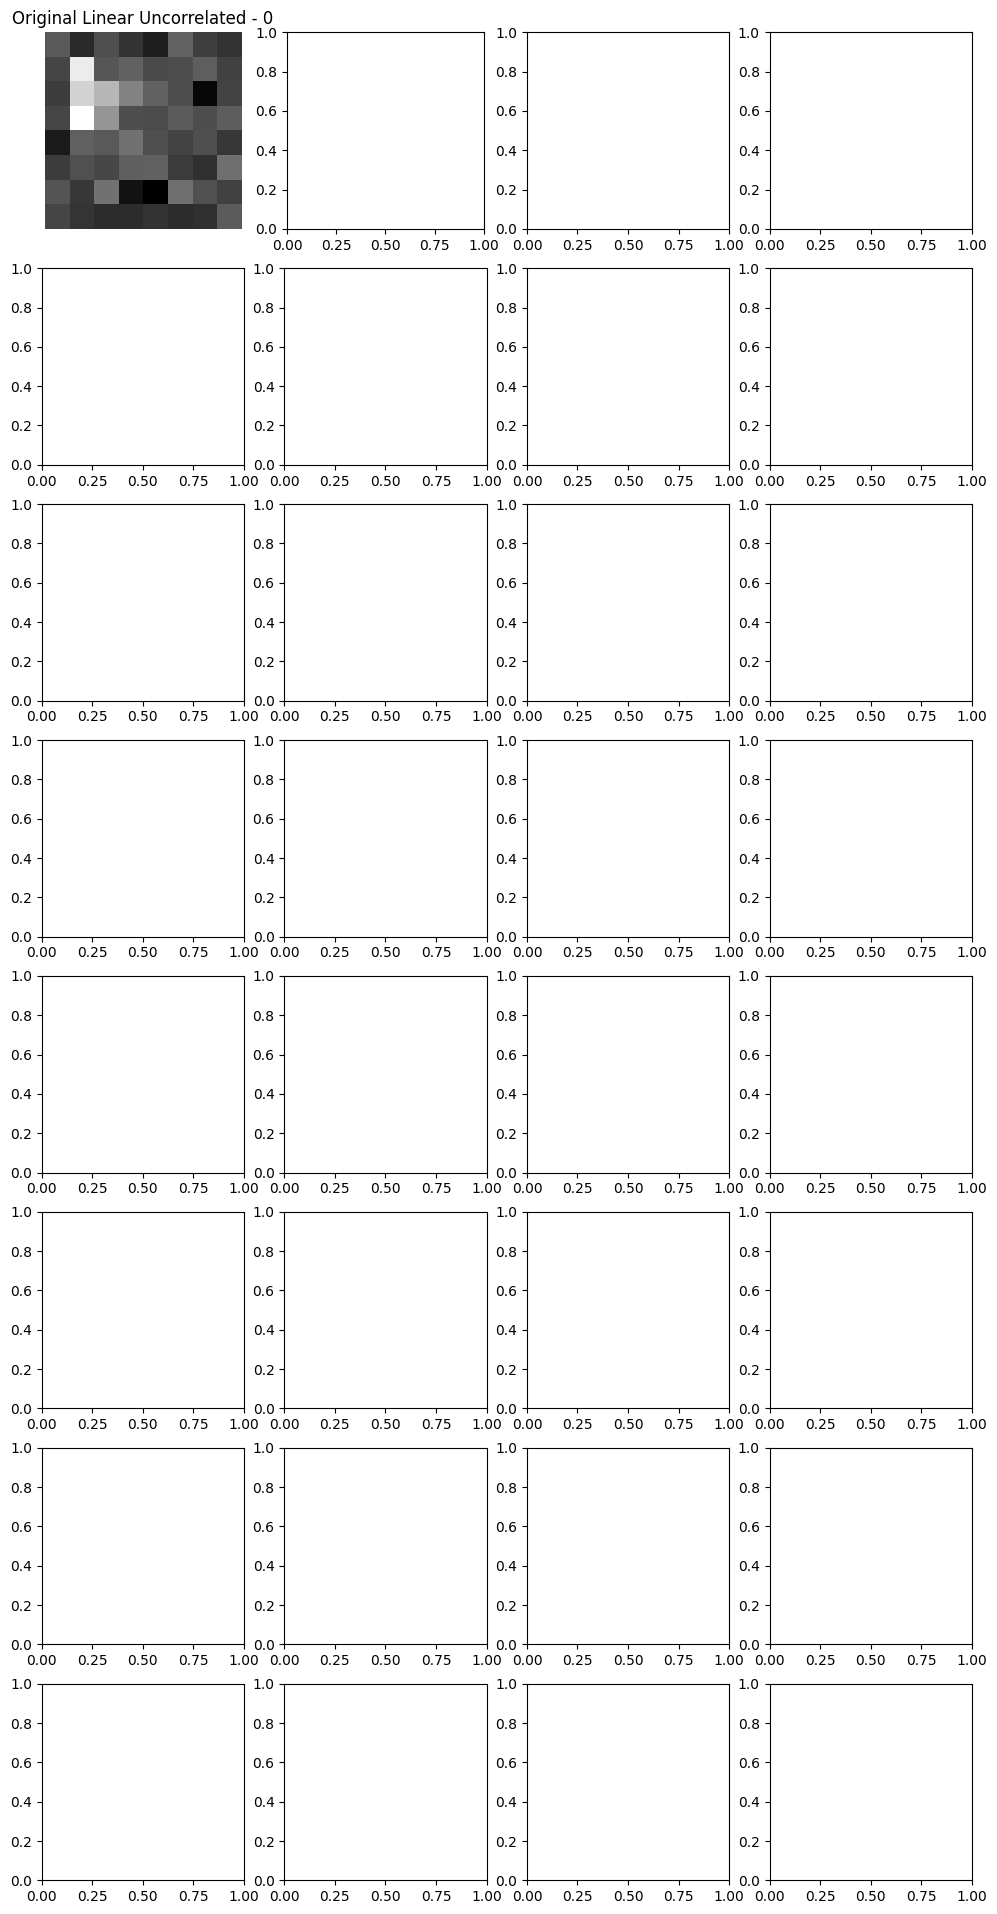

In [18]:
# Generate data using the provided function
original_data, whitened_data = generate_n_examples_with_whitening(whitening_method=sphering)
print(original_data.keys(), whitened_data.keys())

# Visualize the original and whitened data side by side for each scenario-background combination
fig, axes = plt.subplots(len(original_data.keys()), 4, figsize=(12, 24))

for i, key in enumerate(original_data.keys()):
    # Original data
    ax = axes[i, 0]
    ax.imshow(original_data[key][0].reshape(8, 8), cmap='gray')
    ax.set_title(f"Original {key} - 0")
    ax.axis('off')
    
    ax = axes[i, 1]
    ax.imshow(whitened_data[key][0].reshape(8, 8), cmap='gray')
    ax.set_title(f"Whitened {key} - 0")
    ax.axis('off')
    
    # Whitened data
    ax = axes[i, 2]
    ax.imshow(original_data[key][1].reshape(8, 8), cmap='gray')
    ax.set_title(f"Original {key} - 1")
    ax.axis('off')
    
    ax = axes[i, 3]
    ax.imshow(whitened_data[key][1].reshape(8, 8), cmap='gray')
    ax.set_title(f"Whitened {key} - 1")
    ax.axis('off')

plt.tight_layout()
plt.show()

# The first column shows one example from the original data for each scenario.
# The second column shows the corresponding whitened version of the example from the first column.
# The third column shows another example from the original data for each scenario.
# The fourth column shows the whitened version of the example from the third column.

In [ ]:
mean_diagonal_original = {}
mean_off_diagonal_original = {}

mean_diagonal_whitened = {}
mean_off_diagonal_whitened = {}

for key in keys:
    # Original data
    corr_matrix_original = np.corrcoef(original_data[key].T)
    mean_diagonal_original[key] = np.mean(np.diag(corr_matrix_original))
    mean_off_diagonal_original[key] = np.mean(np.abs(corr_matrix_original - np.diag(np.diag(corr_matrix_original))))
    
    # Whitened data
    corr_matrix_whitened = np.corrcoef(whitened_data[key].T)
    mean_diagonal_whitened[key] = np.mean(np.diag(corr_matrix_whitened))
    mean_off_diagonal_whitened[key] = np.mean(np.abs(corr_matrix_whitened - np.diag(np.diag(corr_matrix_whitened))))

mean_diagonal_original, mean_off_diagonal_original, mean_diagonal_whitened, mean_off_diagonal_whitened


({'Linear Uncorrelated': 1.0,
  'Linear Correlated': 1.0,
  'Multiplicative Uncorrelated': 1.0,
  'Multiplicative Correlated': 1.0,
  'Translations_Rotations Uncorrelated': 1.0,
  'Translations_Rotations Correlated': 1.0,
  'XOR Uncorrelated': 1.0,
  'XOR Correlated': 1.0},
 {'Linear Uncorrelated': 0.6953284660926969,
  'Linear Correlated': 0.6437583779296833,
  'Multiplicative Uncorrelated': 0.9232830868565356,
  'Multiplicative Correlated': 0.8800913242488797,
  'Translations_Rotations Uncorrelated': 0.6478202547483781,
  'Translations_Rotations Correlated': 0.6518129254269258,
  'XOR Uncorrelated': 0.8099134489842752,
  'XOR Correlated': 0.8594364260548044},
 {'Linear Uncorrelated': (1+0j),
  'Linear Correlated': (1+0j),
  'Multiplicative Uncorrelated': (1+0j),
  'Multiplicative Correlated': (1+0j),
  'Translations_Rotations Uncorrelated': (1+0j),
  'Translations_Rotations Correlated': (1+0j),
  'XOR Uncorrelated': (1+0j),
  'XOR Correlated': (1+0j)},
 {'Linear Uncorrelated': 0.7016

Validating whitening for Linear Uncorrelated:
Mean: [ 1.00663506e-02  1.91071872e-02  1.82425263e-03  6.01282022e-04
  1.81541306e-03  2.34266155e-03 -7.68470397e-04  1.49518815e-03
  7.50727222e-05  1.26254358e-01 -6.39236439e-03 -2.21027702e-04
  9.38602953e-04 -9.50557069e-03 -1.02257938e-03  7.78858021e-03
  1.42958550e-02  1.34426635e-01  1.13933849e-01  2.63679693e-03
 -5.01878801e-02 -1.10356329e-04 -2.04746310e-04  7.36061122e-04
  2.36430844e-04  2.91426516e-01  3.79767560e-03  5.21694550e-03
 -1.37828373e-04  1.54864088e-04  1.96013295e-05 -2.36418573e-04
 -3.76094470e-04  8.34559543e-04  3.66897290e-04  9.39241005e-05
  2.06136465e-04  9.45568313e-02 -9.01051378e-05  3.23407455e-03
  3.41291226e-04  9.25787958e-03 -3.69719706e-05 -5.65481516e-04
 -1.89172903e-03  4.19780272e-02  1.77520110e-03 -5.77955816e-03
 -5.32721391e-04  6.80192883e-06  4.18243672e-04 -2.18057666e-03
  9.65752179e-03  1.40129777e-01  4.12659449e-01  2.59309196e-03
  3.45337883e-04 -1.02431206e-03  7.78

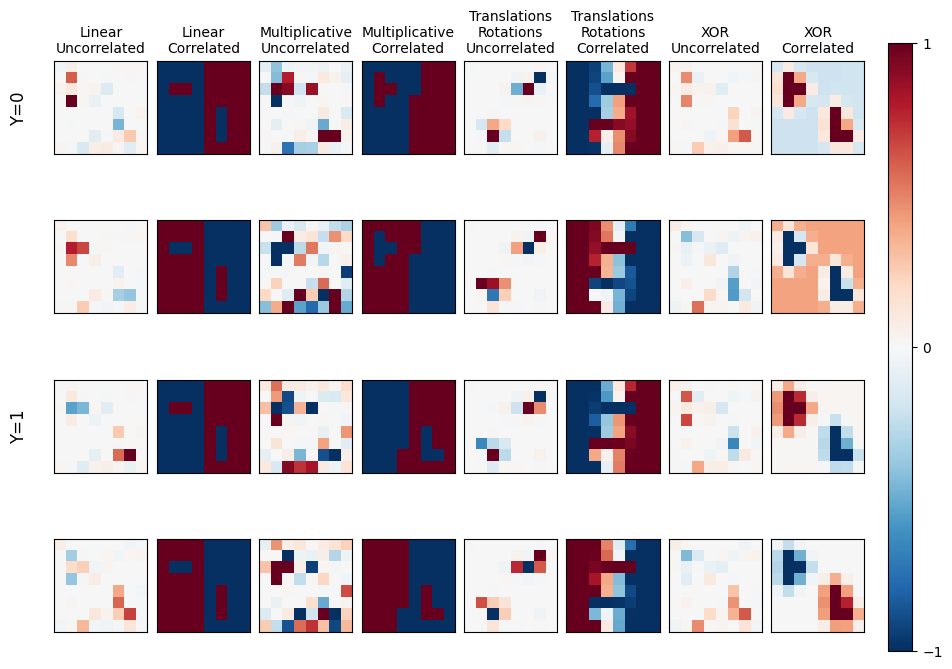

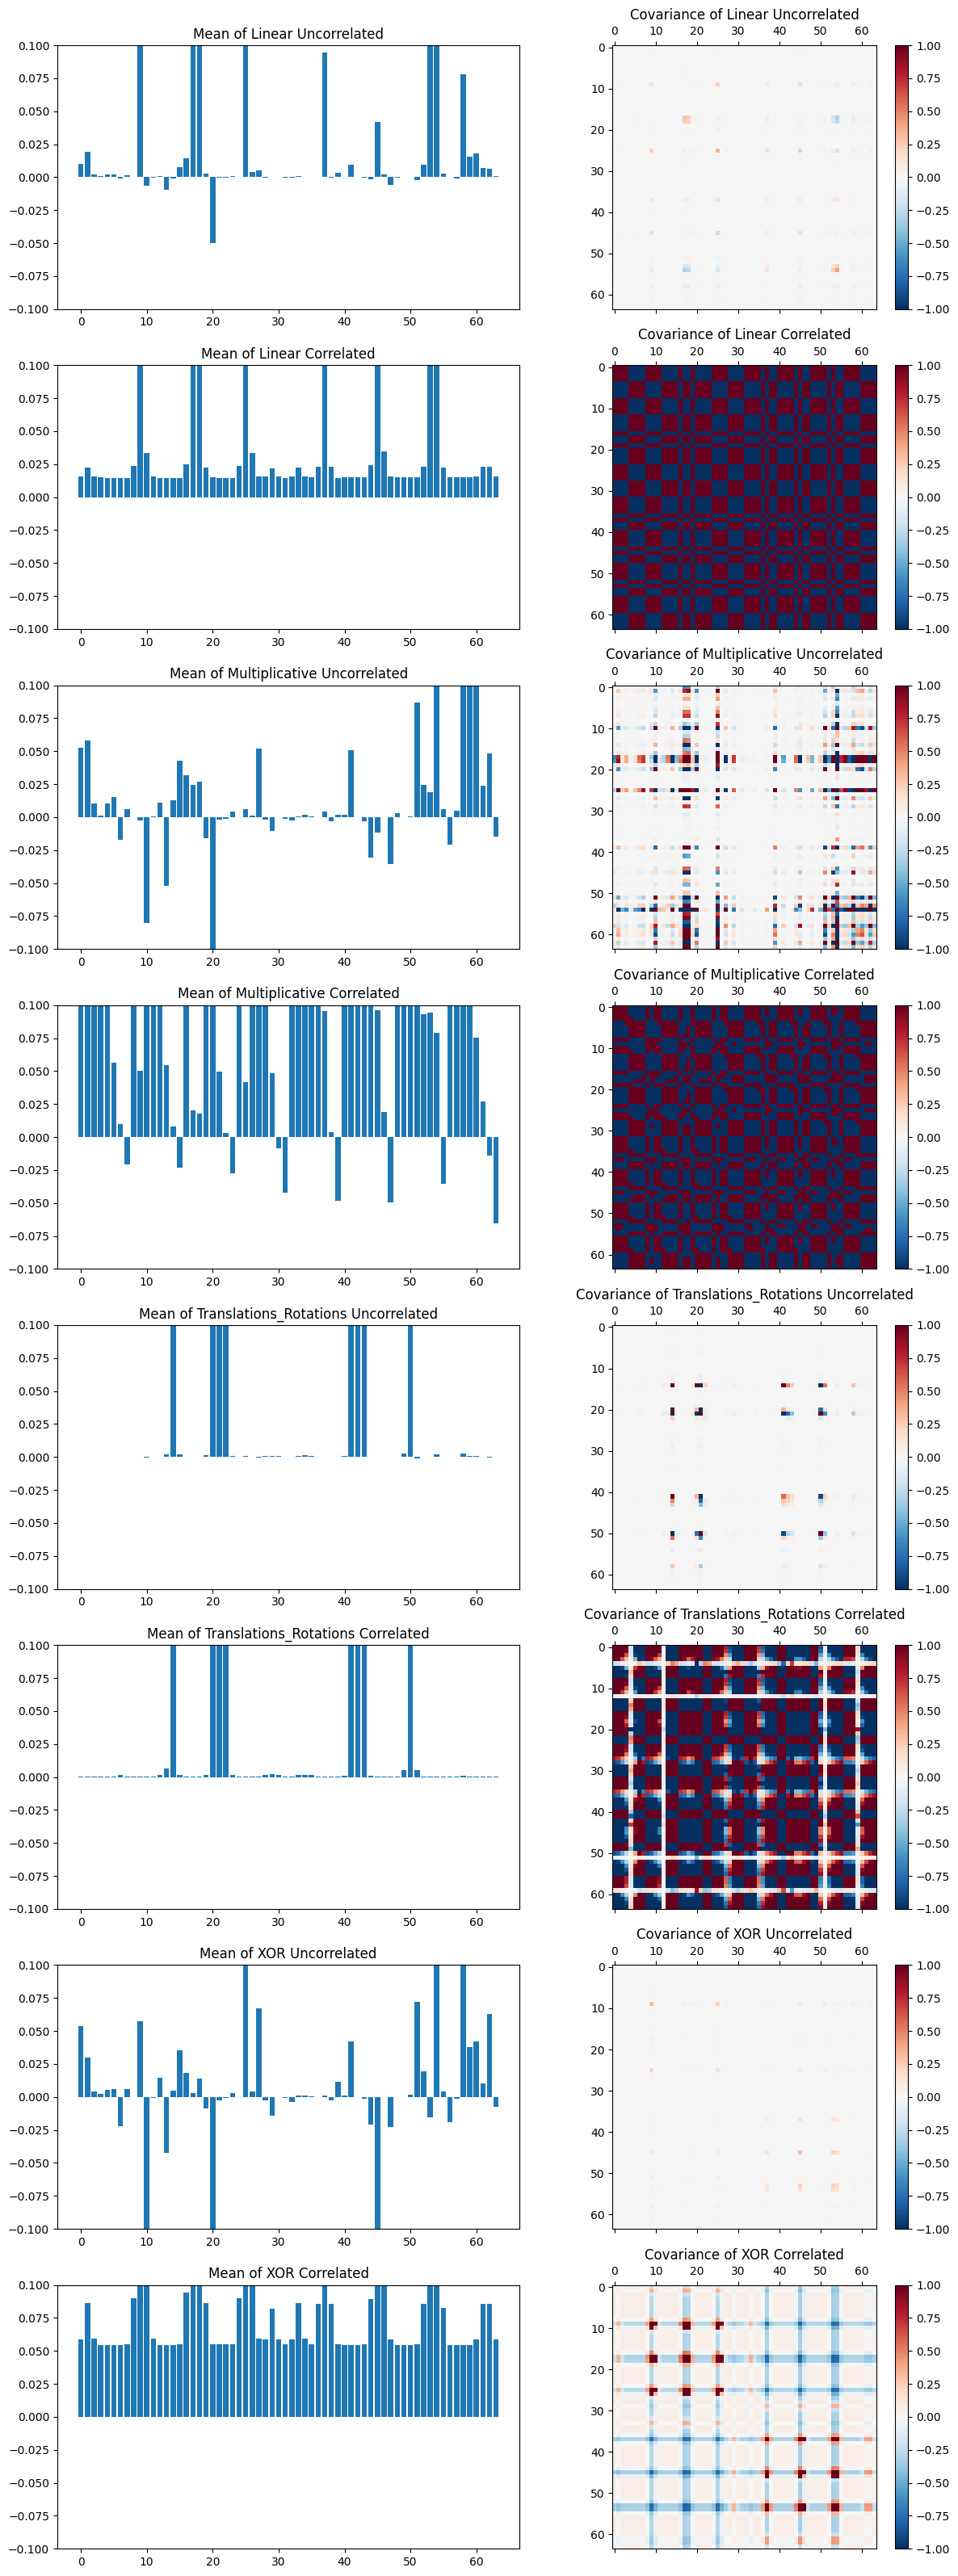

In [ ]:
snrs = [0.5, 0.4, 0.5, 0.825, 0.825, 0.825, 0.5, 0.2, 0.5, 0.6, 0.2, 0.6]

def generate_n_examples_with_whitening(n=4, snrs=snrs, whitening_method=None):
    backgrounds = [generate_background(), generate_background()]
    smoothed_backgrounds = [gaussian_filter(backgrounds[0].copy(), 10), gaussian_filter(backgrounds[1].copy(), 10)]
    
    linear_0, linear_1 = generate_linear_pattern(cls=0), generate_linear_pattern(cls=1)
    mult_0, mult_1 = generate_multiplicative_pattern(cls=0, snr=0.725), generate_multiplicative_pattern(cls=1, snr=0.725)
    tr_0, tr_1 = generate_translations_rotations_pattern(cls=0), generate_translations_rotations_pattern(cls=1)
    xor_0, xor_1 = generate_xor_pattern(cls=0), generate_xor_pattern(cls=1)
    
    patterns = {
        'Linear': [linear_0, linear_1],
        'Multiplicative': [mult_0, mult_1],
        'Translations_Rotations': [tr_0, tr_1],
        'XOR': [xor_0, xor_1]
    }
    
    backgrounds_dict = {
        'Correlated': smoothed_backgrounds,
        'Uncorrelated': backgrounds,
    }
    
    keys = ['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated',
            'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated','XOR Uncorrelated', 'XOR Correlated']
    
    data_dict = {}
    for snr_ind, key in enumerate(keys):
        data = np.zeros((n,64))
        scenario, background_type = key.split(' ')
        bg = backgrounds_dict[background_type]
        ind = 0
        for j in range(2):
            for i in range(2):
                if 'XOR' in key and i == 1:
                    scalar = -1
                else:
                    scalar = 1
                pat = patterns[scenario][j] * scalar
                back = bg[i]
                if 'Multiplicative' in key:
                    pat_copy = 1 - snrs[snr_ind] * pat.copy()
                else:
                    pat_copy = pat.copy()
                
                normalised_patterns, normalised_backgrounds = normalise_data(np.reshape(pat_copy,(8,8)), np.reshape(back, (8,8)))
                if 'Multiplicative' in key:
                    data[ind] = np.reshape(normalised_patterns * normalised_backgrounds, (64))
                else:
                    data[ind] = np.reshape(snrs[snr_ind] * normalised_patterns + (1 - snrs[snr_ind]) * normalised_backgrounds, (64))
                data[ind] = scale_to_bound(data[ind], 1)
                
                ind += 1
        data_dict[key] = data

    # Dictionary to hold transformation matrices for each scenario
    transformation_matrices = {}
    
    # Whitening each scenario separately
    for key in data_dict:
        if whitening_method:
            whitened_data, transformation_matrix = whitening_method(data_dict[key])
            data_dict[key] = whitened_data
            transformation_matrices[key] = transformation_matrix

    return data_dict, transformation_matrices
# Generate data using the provided function
data_dict, transformation_matrices = generate_n_examples_with_whitening()

# Visualization: Let's visualize a few samples from each scenario-background combination
fig, axs = plt.subplots(len(data_dict), 4, figsize=(15, 20))
for i, (key, data) in enumerate(data_dict.items()):
    axs[i, 0].imshow(data[0].reshape(8, 8), cmap='gray')
    axs[i, 1].imshow(data[1].reshape(8, 8), cmap='gray')
    axs[i, 2].imshow(data[2].reshape(8, 8), cmap='gray')
    axs[i, 3].imshow(data[3].reshape(8, 8), cmap='gray')
    axs[i, 0].set_title(f"{key} - Sample 1")
    axs[i, 1].set_title(f"{key} - Sample 2")
    axs[i, 2].set_title(f"{key} - Sample 3")
    axs[i, 3].set_title(f"{key} - Sample 4")
    for j in range(4):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()
# data_dict, transformation_matrices = generate_n_examples_with_whitening(n=4, whitening_method=symmetric_orthogonalization)
# def validate_whitening(data):
#     # Compute the mean of the data
#     mean = np.mean(data, axis=0)
#     print(f"Mean: {mean}")

#     # Compute the covariance matrix of the data
#     cov_matrix = np.cov(data, rowvar=False)

#     # Ideally, for whitened data, the covariance matrix should be an identity matrix.
#     # We'll measure the difference between the covariance matrix and the identity matrix.
#     difference = np.linalg.norm(cov_matrix - np.eye(cov_matrix.shape[0]))
#     print(f"Difference from identity: {difference}")

# # Example Usage:
# for key, value in data_dict.items():
#     print(f"Validating whitening for {key}:")
#     validate_whitening(value)
#     print("------------")

# def plot_whitened_data(data_dict):
#     rows = 4  # Modifying this to 4 to show two rows for each class
#     cols = 8

#     fig = plt.figure(figsize=(12, 8))
#     # grid for pairs of subplots
#     grid = plt.GridSpec(rows, cols, hspace=0.15, wspace=0.1)

#     j = 0
#     keys = list(data_dict.keys())

#     for i, key in enumerate(keys):
#         data = data_dict[key]
#         for r in range(rows):
#             gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[r, i], wspace=0.1)
#             ax = fig.add_subplot(gs[0])
#             ax.imshow(np.reshape(data[r], (8,8)), cmap="RdBu_r", vmin=-1, vmax=1)
            
#             if r == 0:
#                 ax.set_title(key.replace(' ', '\n').replace('_', '\n'), fontdict = {'fontsize' : 10})
            
#             if i == 0 and r == 0:
#                 ax.set_ylabel(f'Y=0\n', fontsize=12)
#             elif i == 0 and r == 2:
#                 ax.set_ylabel(f'Y=1\n', fontsize=12)
                
#             ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
#             j += 1

#     plt.subplots_adjust(wspace=0.2, hspace=0.2)  
    
#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.82, 0.115, 0.02, 0.76])
#     fig.colorbar(ax.get_images()[0], cax=cbar_ax, ticks=[-1.0,0,1.0])

#     plt.show()
# plot_whitened_data(data_dict)


# def validate_and_plot_whitening(data_dict):
#     fig, axes = plt.subplots(nrows=len(data_dict), ncols=2, figsize=(12, 4 * len(data_dict)))
    
#     for ax_row, (key, data) in zip(axes, data_dict.items()):
#         # Compute the mean and covariance of the data
#         mean = np.mean(data, axis=0)
#         cov_matrix = np.cov(data, rowvar=False)

#         # Plot mean
#         ax_row[0].bar(range(len(mean)), mean)
#         ax_row[0].set_title(f"Mean of {key}")
#         ax_row[0].set_ylim([-0.1, 0.1])  # Setting y-limits for better visualization

#         # Plot covariance matrix
#         cax = ax_row[1].matshow(cov_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
#         ax_row[1].set_title(f"Covariance of {key}")
        
#         # Add colorbar for the covariance heatmap
#         plt.colorbar(cax, ax=ax_row[1], fraction=0.046, pad=0.04)

#     plt.tight_layout()
#     plt.show()
# validate_and_plot_whitening(data_dict)


Computing inverse square root...
Applied sphering. Matrix shape: (4, 64)
Computing inverse square root...
Applied sphering. Matrix shape: (4, 64)
Computing inverse square root...
Applied sphering. Matrix shape: (4, 64)
Computing inverse square root...
Applied sphering. Matrix shape: (4, 64)
Computing inverse square root...
Applied sphering. Matrix shape: (4, 64)
Computing inverse square root...
Applied sphering. Matrix shape: (4, 64)
Computing inverse square root...
Applied sphering. Matrix shape: (4, 64)
Computing inverse square root...
Applied sphering. Matrix shape: (4, 64)
Validating whitening for Linear Uncorrelated:
Mean: [ 0.00260491-1.99454004e-18j  0.1209401 -1.90337515e-17j
 -0.10079522+1.12274267e-17j  0.11076949-1.00914702e-18j
  0.07539584-1.08208394e-17j  0.05066379-1.84916318e-17j
 -0.00120141-6.97146655e-18j  0.02601852+9.17614167e-18j
  0.09467794+1.61474016e-17j  0.21991416-1.30851761e-19j
  0.01079314-1.18567596e-17j -0.17483294-1.33263647e-17j
  0.02436415-2.8516495

TypeError: Image data of dtype complex128 cannot be converted to float

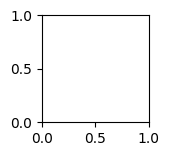

In [ ]:

data_dict, transformation_matrices = generate_n_examples_with_whitening(n=4, whitening_method=sphering)
def validate_whitening(data):
    # Compute the mean of the data
    mean = np.mean(data, axis=0)
    print(f"Mean: {mean}")

    # Compute the covariance matrix of the data
    cov_matrix = np.cov(data, rowvar=False)

    # Ideally, for whitened data, the covariance matrix should be an identity matrix.
    # We'll measure the difference between the covariance matrix and the identity matrix.
    difference = np.linalg.norm(cov_matrix - np.eye(cov_matrix.shape[0]))
    print(f"Difference from identity: {difference}")

# Example Usage:
for key, value in data_dict.items():
    print(f"Validating whitening for {key}:")
    validate_whitening(value)
    print("------------")

def plot_whitened_data(data_dict):
    rows = 4  # Modifying this to 4 to show two rows for each class
    cols = 8

    fig = plt.figure(figsize=(12, 8))
    # grid for pairs of subplots
    grid = plt.GridSpec(rows, cols, hspace=0.15, wspace=0.1)

    j = 0
    keys = list(data_dict.keys())

    for i, key in enumerate(keys):
        data = data_dict[key]
        for r in range(rows):
            gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[r, i], wspace=0.1)
            ax = fig.add_subplot(gs[0])
            ax.imshow(np.reshape(data[r], (8,8)), cmap="RdBu_r", vmin=-1, vmax=1)
            
            if r == 0:
                ax.set_title(key.replace(' ', '\n').replace('_', '\n'), fontdict = {'fontsize' : 10})
            
            if i == 0 and r == 0:
                ax.set_ylabel(f'Y=0\n', fontsize=12)
            elif i == 0 and r == 2:
                ax.set_ylabel(f'Y=1\n', fontsize=12)
                
            ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
            j += 1

    plt.subplots_adjust(wspace=0.2, hspace=0.2)  
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.115, 0.02, 0.76])
    fig.colorbar(ax.get_images()[0], cax=cbar_ax, ticks=[-1.0,0,1.0])

    plt.show()
plot_whitened_data(data_dict)


def validate_and_plot_whitening(data_dict):
    fig, axes = plt.subplots(nrows=len(data_dict), ncols=2, figsize=(12, 4 * len(data_dict)))
    
    for ax_row, (key, data) in zip(axes, data_dict.items()):
        # Compute the mean and covariance of the data
        mean = np.mean(data, axis=0)
        cov_matrix = np.cov(data, rowvar=False)

        # Plot mean
        ax_row[0].bar(range(len(mean)), mean)
        ax_row[0].set_title(f"Mean of {key}")
        ax_row[0].set_ylim([-0.1, 0.1])  # Setting y-limits for better visualization

        # Plot covariance matrix
        cax = ax_row[1].matshow(cov_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
        ax_row[1].set_title(f"Covariance of {key}")
        
        # Add colorbar for the covariance heatmap
        plt.colorbar(cax, ax=ax_row[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
validate_and_plot_whitening(data_dict)

Validating whitening for Linear Uncorrelated:
Mean: [ 0.14690073+1.61596849e-18j -0.71900657+1.92675492e-16j
  0.63114469+2.85227601e-16j  3.27475263-1.18559629e-16j
  1.31869336+3.68615084e-16j -5.62107686-1.67106265e-16j
  2.46293987-1.22747844e-16j -5.25519939+1.22288195e-17j
 -2.91686335-2.04824513e-16j -0.24563189+1.77656585e-16j
  0.2705942 +4.18481180e-16j  3.27862567+4.33078898e-17j
 -0.44655859+1.42601714e-16j  0.4512623 -1.19121408e-16j
 -0.09112486-6.92371942e-17j  0.673177  +2.31608800e-16j
  0.60927225+5.87753615e-17j -0.46687125-3.57289525e-16j
 -0.40986306-3.09462864e-18j  2.08724966+4.02611075e-16j
  1.11822695+2.04657660e-16j  0.43819819-3.20403041e-17j
  0.60348259+4.17102095e-17j  2.60037967-3.90961909e-16j
 -0.20583873-2.62680405e-16j -0.60884863-1.67164159e-16j
  1.1366656 +1.81199350e-16j -0.39024115+3.78613682e-17j
  0.7341665 +9.88438045e-17j  4.37958108+8.28459575e-17j
  0.66799022+5.47679816e-18j  0.29840025-3.48097510e-17j
  0.34875908+3.01442399e-17j  0.1725

TypeError: Image data of dtype complex128 cannot be converted to float

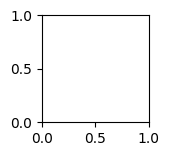

In [ ]:

data_dict, transformation_matrices = generate_n_examples_with_whitening(n=4, whitening_method=optimal_signal_preserving_whitening)
def validate_whitening(data):
    # Compute the mean of the data
    mean = np.mean(data, axis=0)
    print(f"Mean: {mean}")

    # Compute the covariance matrix of the data
    cov_matrix = np.cov(data, rowvar=False)

    # Ideally, for whitened data, the covariance matrix should be an identity matrix.
    # We'll measure the difference between the covariance matrix and the identity matrix.
    difference = np.linalg.norm(cov_matrix - np.eye(cov_matrix.shape[0]))
    print(f"Difference from identity: {difference}")

# Example Usage:
for key, value in data_dict.items():
    print(f"Validating whitening for {key}:")
    validate_whitening(value)
    print("------------")

def plot_whitened_data(data_dict):
    rows = 4  # Modifying this to 4 to show two rows for each class
    cols = 8

    fig = plt.figure(figsize=(12, 8))
    # grid for pairs of subplots
    grid = plt.GridSpec(rows, cols, hspace=0.15, wspace=0.1)

    j = 0
    keys = list(data_dict.keys())

    for i, key in enumerate(keys):
        data = data_dict[key]
        for r in range(rows):
            gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[r, i], wspace=0.1)
            ax = fig.add_subplot(gs[0])
            ax.imshow(np.reshape(data[r], (8,8)), cmap="RdBu_r", vmin=-1, vmax=1)
            
            if r == 0:
                ax.set_title(key.replace(' ', '\n').replace('_', '\n'), fontdict = {'fontsize' : 10})
            
            if i == 0 and r == 0:
                ax.set_ylabel(f'Y=0\n', fontsize=12)
            elif i == 0 and r == 2:
                ax.set_ylabel(f'Y=1\n', fontsize=12)
                
            ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
            j += 1

    plt.subplots_adjust(wspace=0.2, hspace=0.2)  
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.115, 0.02, 0.76])
    fig.colorbar(ax.get_images()[0], cax=cbar_ax, ticks=[-1.0,0,1.0])

    plt.show()
plot_whitened_data(data_dict)


def validate_and_plot_whitening(data_dict):
    fig, axes = plt.subplots(nrows=len(data_dict), ncols=2, figsize=(12, 4 * len(data_dict)))
    
    for ax_row, (key, data) in zip(axes, data_dict.items()):
        # Compute the mean and covariance of the data
        mean = np.mean(data, axis=0)
        cov_matrix = np.cov(data, rowvar=False)

        # Plot mean
        ax_row[0].bar(range(len(mean)), mean)
        ax_row[0].set_title(f"Mean of {key}")
        ax_row[0].set_ylim([-0.1, 0.1])  # Setting y-limits for better visualization

        # Plot covariance matrix
        cax = ax_row[1].matshow(cov_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
        ax_row[1].set_title(f"Covariance of {key}")
        
        # Add colorbar for the covariance heatmap
        plt.colorbar(cax, ax=ax_row[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
validate_and_plot_whitening(data_dict)

Validating whitening for Linear Uncorrelated:
Mean: [ 8.67361738e-17 -3.46944695e-18  2.77555756e-17  2.42861287e-17
  4.16333634e-17 -8.32667268e-17 -9.19403442e-17  3.46944695e-17
 -1.04083409e-17  1.42247325e-16 -5.98479599e-17  8.32667268e-17
 -1.40512602e-16 -9.02056208e-17 -9.02056208e-17  4.68375339e-17
 -2.42861287e-17 -2.74953671e-16  7.77156117e-16 -1.78676518e-16
 -6.93889390e-17  1.04083409e-17 -1.20563282e-16  1.04083409e-17
 -1.21430643e-17  2.22044605e-16 -1.26634814e-16  1.14491749e-16
 -2.08166817e-16  0.00000000e+00 -3.30817188e-17 -1.73472348e-18
 -4.16333634e-17  8.50014503e-17  1.79977561e-17 -3.46944695e-17
  1.56125113e-17  2.77555756e-17 -7.97972799e-17 -4.16333634e-17
  1.11022302e-16 -2.60208521e-17 -5.63785130e-18  1.04083409e-16
  1.80411242e-16 -6.93889390e-18  2.15105711e-16  4.85722573e-17
  1.04083409e-16  6.93889390e-18 -1.38777878e-16 -8.67361738e-18
 -3.59955121e-17 -2.08166817e-16  2.08166817e-17  1.38777878e-16
 -1.78676518e-16 -9.54097912e-18 -3.08

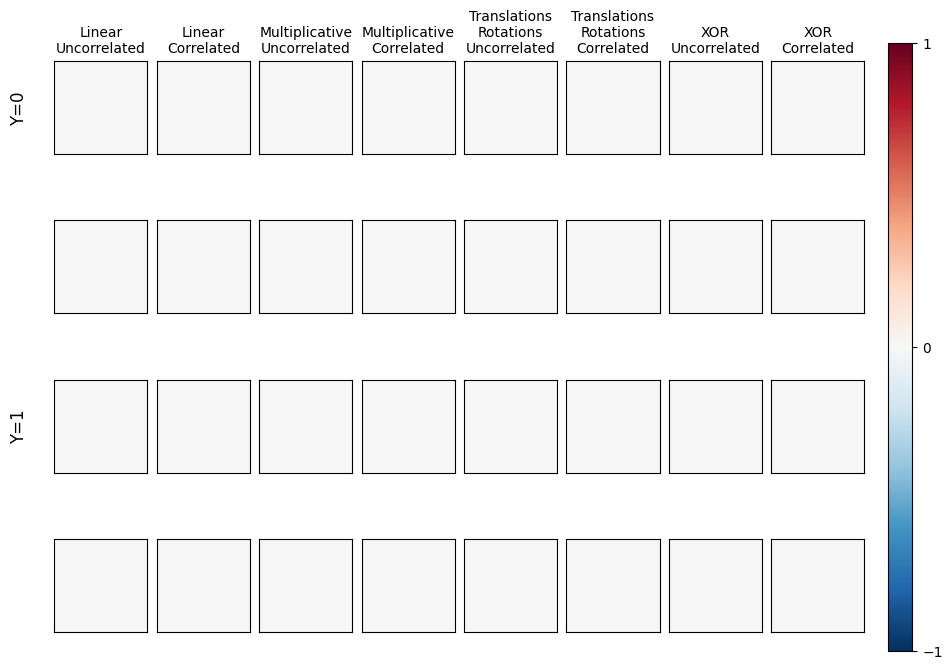

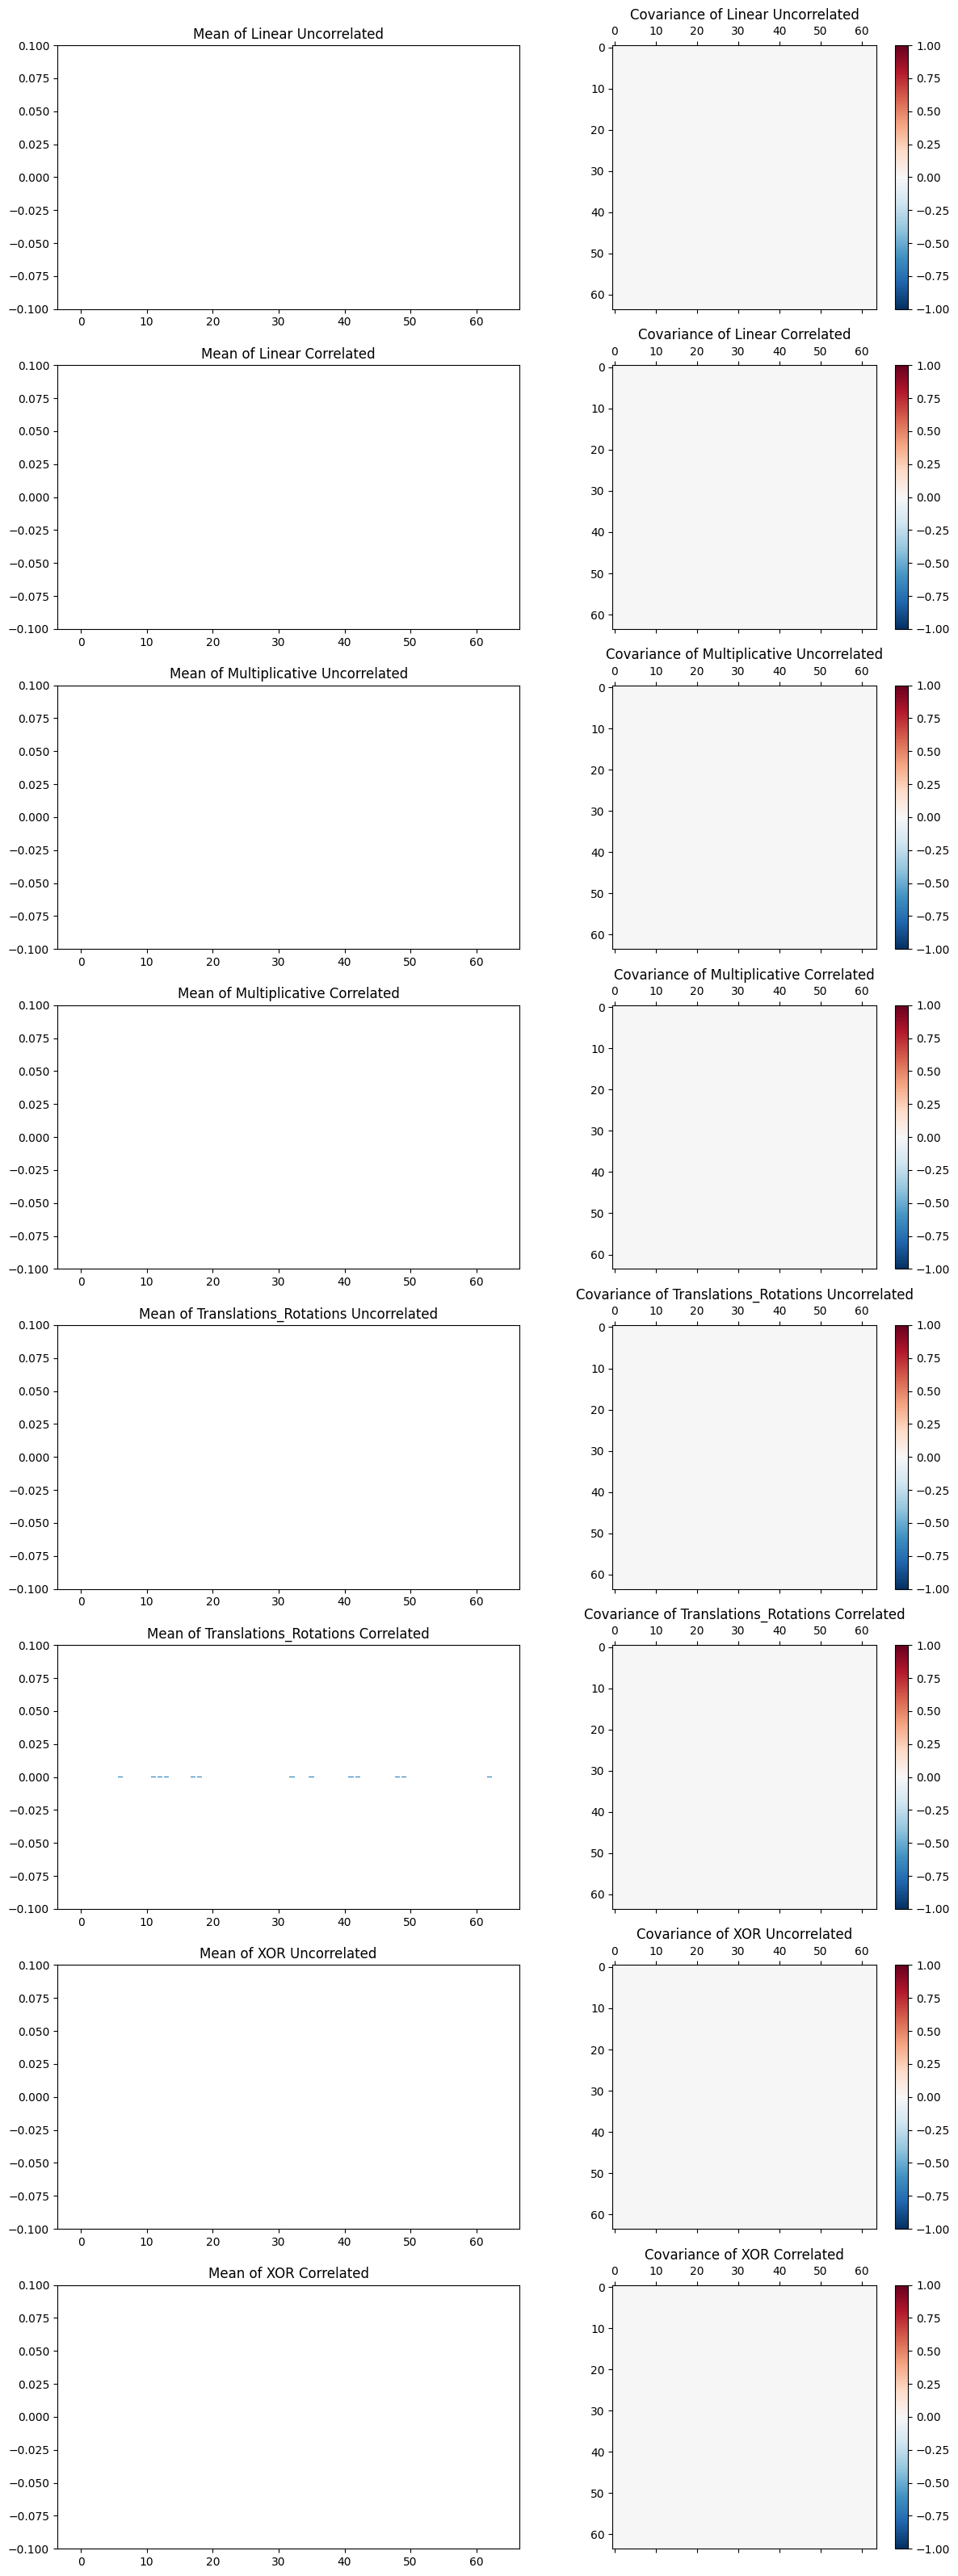

In [ ]:

data_dict, transformation_matrices = generate_n_examples_with_whitening(n=4, whitening_method=partial_regression)
def validate_whitening(data):
    # Compute the mean of the data
    mean = np.mean(data, axis=0)
    print(f"Mean: {mean}")

    # Compute the covariance matrix of the data
    cov_matrix = np.cov(data, rowvar=False)

    # Ideally, for whitened data, the covariance matrix should be an identity matrix.
    # We'll measure the difference between the covariance matrix and the identity matrix.
    difference = np.linalg.norm(cov_matrix - np.eye(cov_matrix.shape[0]))
    print(f"Difference from identity: {difference}")

# Example Usage:
for key, value in data_dict.items():
    print(f"Validating whitening for {key}:")
    validate_whitening(value)
    print("------------")

def plot_whitened_data(data_dict):
    rows = 4  # Modifying this to 4 to show two rows for each class
    cols = 8

    fig = plt.figure(figsize=(12, 8))
    # grid for pairs of subplots
    grid = plt.GridSpec(rows, cols, hspace=0.15, wspace=0.1)

    j = 0
    keys = list(data_dict.keys())

    for i, key in enumerate(keys):
        data = data_dict[key]
        for r in range(rows):
            gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[r, i], wspace=0.1)
            ax = fig.add_subplot(gs[0])
            ax.imshow(np.reshape(data[r], (8,8)), cmap="RdBu_r", vmin=-1, vmax=1)
            
            if r == 0:
                ax.set_title(key.replace(' ', '\n').replace('_', '\n'), fontdict = {'fontsize' : 10})
            
            if i == 0 and r == 0:
                ax.set_ylabel(f'Y=0\n', fontsize=12)
            elif i == 0 and r == 2:
                ax.set_ylabel(f'Y=1\n', fontsize=12)
                
            ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
            j += 1

    plt.subplots_adjust(wspace=0.2, hspace=0.2)  
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.115, 0.02, 0.76])
    fig.colorbar(ax.get_images()[0], cax=cbar_ax, ticks=[-1.0,0,1.0])

    plt.show()
plot_whitened_data(data_dict)


def validate_and_plot_whitening(data_dict):
    fig, axes = plt.subplots(nrows=len(data_dict), ncols=2, figsize=(12, 4 * len(data_dict)))
    
    for ax_row, (key, data) in zip(axes, data_dict.items()):
        # Compute the mean and covariance of the data
        mean = np.mean(data, axis=0)
        cov_matrix = np.cov(data, rowvar=False)

        # Plot mean
        ax_row[0].bar(range(len(mean)), mean)
        ax_row[0].set_title(f"Mean of {key}")
        ax_row[0].set_ylim([-0.1, 0.1])  # Setting y-limits for better visualization

        # Plot covariance matrix
        cax = ax_row[1].matshow(cov_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
        ax_row[1].set_title(f"Covariance of {key}")
        
        # Add colorbar for the covariance heatmap
        plt.colorbar(cax, ax=ax_row[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
validate_and_plot_whitening(data_dict)

Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Applied Cholesky whitening. Matrix shape: (4, 64)
Validating whitening for Linear Uncorrelated:
Mean: [-5.94330634e+01 -1.42214821e+01  7.36960164e+01 -5.29023193e+01
 -9.38344117e+01 -5.27100216e+01  9.23744812e+01 -1.18243254e+02
 -3.17854841e+01  3.21286218e+02  1.08786867e+02 -1.92711808e+02
 -2.32488391e+01 -7.66857533e+01  8.95267317e+01 -1.18688272e+02
  5.62591035e+01  1.92597158e+02  2.32311027e+02 -2.99905807e+01
 -6.69727617e+01  3.19255803e+01  9.92036008e+01 -9.45181436e+01
 -3.62593486e+01 -2.20044765e+02 -1.16963831e+02 -5.88643642e+00
  1.80094405e+01  6.10317255e+01  1.25887344e+01  2.85089380e+01
 -3.05618625e+01 -8.54602196

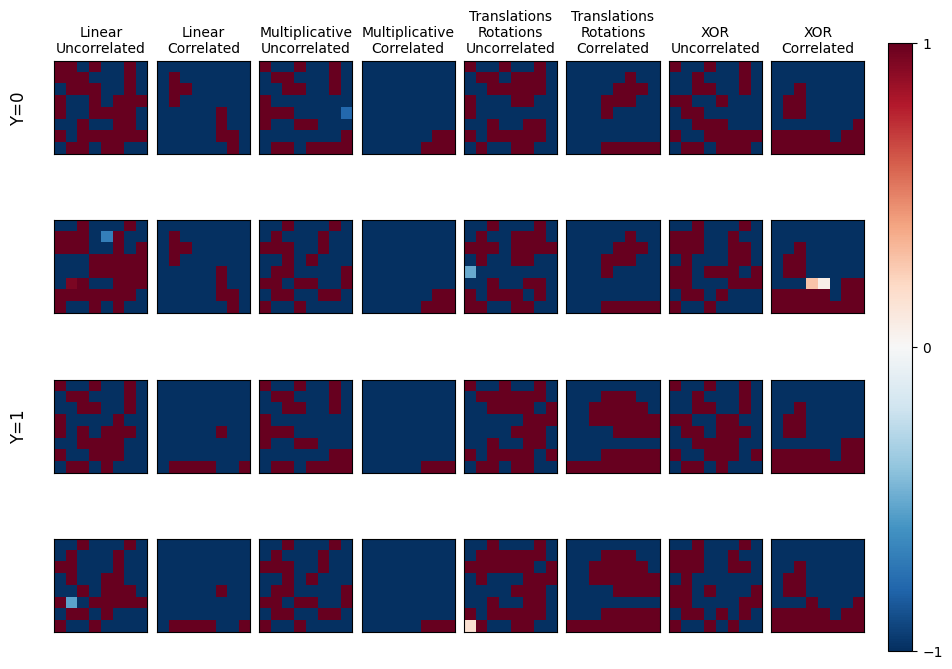

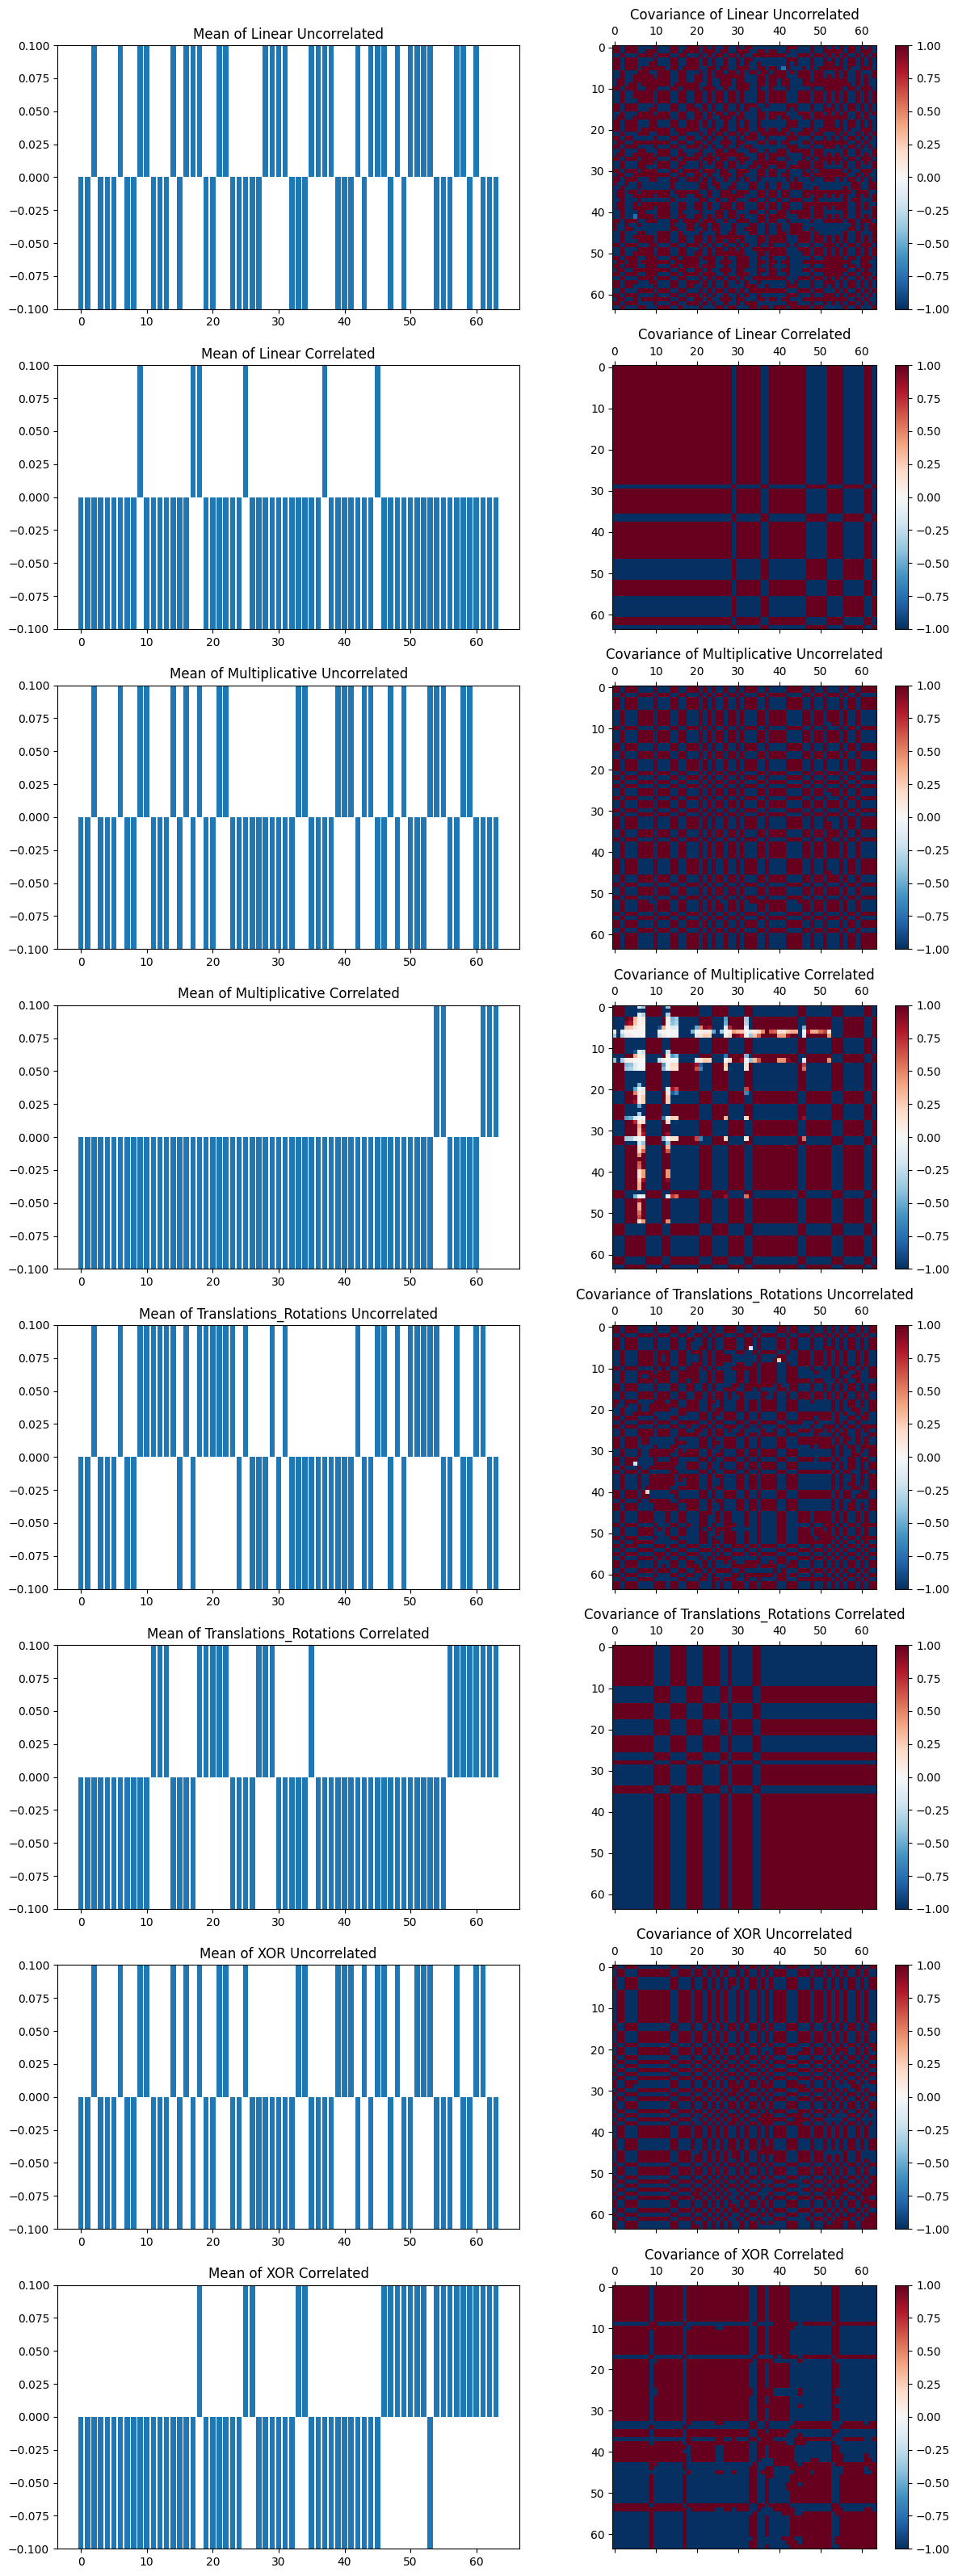

In [ ]:

data_dict, transformation_matrices = generate_n_examples_with_whitening(n=4, whitening_method=cholesky_whitening)
def validate_whitening(data):
    # Compute the mean of the data
    mean = np.mean(data, axis=0)
    print(f"Mean: {mean}")

    # Compute the covariance matrix of the data
    cov_matrix = np.cov(data, rowvar=False)

    # Ideally, for whitened data, the covariance matrix should be an identity matrix.
    # We'll measure the difference between the covariance matrix and the identity matrix.
    difference = np.linalg.norm(cov_matrix - np.eye(cov_matrix.shape[0]))
    print(f"Difference from identity: {difference}")

# Example Usage:
for key, value in data_dict.items():
    print(f"Validating whitening for {key}:")
    validate_whitening(value)
    print("------------")

def plot_whitened_data(data_dict):
    rows = 4  # Modifying this to 4 to show two rows for each class
    cols = 8

    fig = plt.figure(figsize=(12, 8))
    # grid for pairs of subplots
    grid = plt.GridSpec(rows, cols, hspace=0.15, wspace=0.1)

    j = 0
    keys = list(data_dict.keys())

    for i, key in enumerate(keys):
        data = data_dict[key]
        for r in range(rows):
            gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[r, i], wspace=0.1)
            ax = fig.add_subplot(gs[0])
            ax.imshow(np.reshape(data[r], (8,8)), cmap="RdBu_r", vmin=-1, vmax=1)
            
            if r == 0:
                ax.set_title(key.replace(' ', '\n').replace('_', '\n'), fontdict = {'fontsize' : 10})
            
            if i == 0 and r == 0:
                ax.set_ylabel(f'Y=0\n', fontsize=12)
            elif i == 0 and r == 2:
                ax.set_ylabel(f'Y=1\n', fontsize=12)
                
            ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
            j += 1

    plt.subplots_adjust(wspace=0.2, hspace=0.2)  
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.115, 0.02, 0.76])
    fig.colorbar(ax.get_images()[0], cax=cbar_ax, ticks=[-1.0,0,1.0])

    plt.show()
plot_whitened_data(data_dict)


def validate_and_plot_whitening(data_dict):
    fig, axes = plt.subplots(nrows=len(data_dict), ncols=2, figsize=(12, 4 * len(data_dict)))
    
    for ax_row, (key, data) in zip(axes, data_dict.items()):
        # Compute the mean and covariance of the data
        mean = np.mean(data, axis=0)
        cov_matrix = np.cov(data, rowvar=False)

        # Plot mean
        ax_row[0].bar(range(len(mean)), mean)
        ax_row[0].set_title(f"Mean of {key}")
        ax_row[0].set_ylim([-0.1, 0.1])  # Setting y-limits for better visualization

        # Plot covariance matrix
        cax = ax_row[1].matshow(cov_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
        ax_row[1].set_title(f"Covariance of {key}")
        
        # Add colorbar for the covariance heatmap
        plt.colorbar(cax, ax=ax_row[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
validate_and_plot_whitening(data_dict)

Validating whitening for Linear Uncorrelated:
Mean: [ 0.3335616  -0.03597587 -0.0391665  -0.23761934  0.09827679 -0.00964029
  0.1096019  -0.14431812 -0.04723356  0.43325498  0.3267904  -0.10806267
  0.05096361  0.17349526 -0.12595741  0.08805157  0.15722137  0.40717359
  0.33444496  0.09181201 -0.0662045  -0.04052489  0.22864751 -0.06260515
  0.11744609  0.42731769  0.18073891  0.14880794  0.29410373  0.04221486
  0.12990765  0.12311367 -0.11054311  0.13828336  0.17182307  0.006477
  0.2029477   0.40501428 -0.21603171 -0.04865846  0.01200909  0.09736159
 -0.1986701  -0.1237863  -0.06341903  0.49392437 -0.06969209  0.34032677
  0.10465559  0.06394171  0.03473027 -0.00260607  0.24021087  0.5101704
  0.33544728  0.09668883 -0.05820835 -0.08095516  0.12392088 -0.10806071
 -0.17431907  0.21966874  0.06847431 -0.0243847 ]
Difference from identity: 7.95278096962482
------------
Validating whitening for Linear Correlated:
Mean: [0.264046   0.29532259 0.26405302 0.25904868 0.25891218 0.2588750

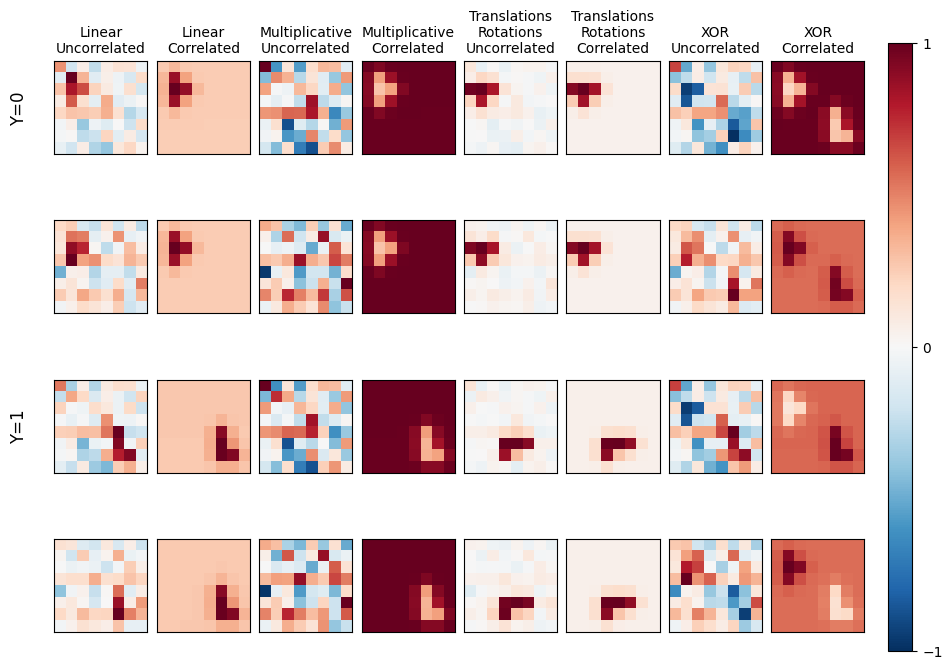

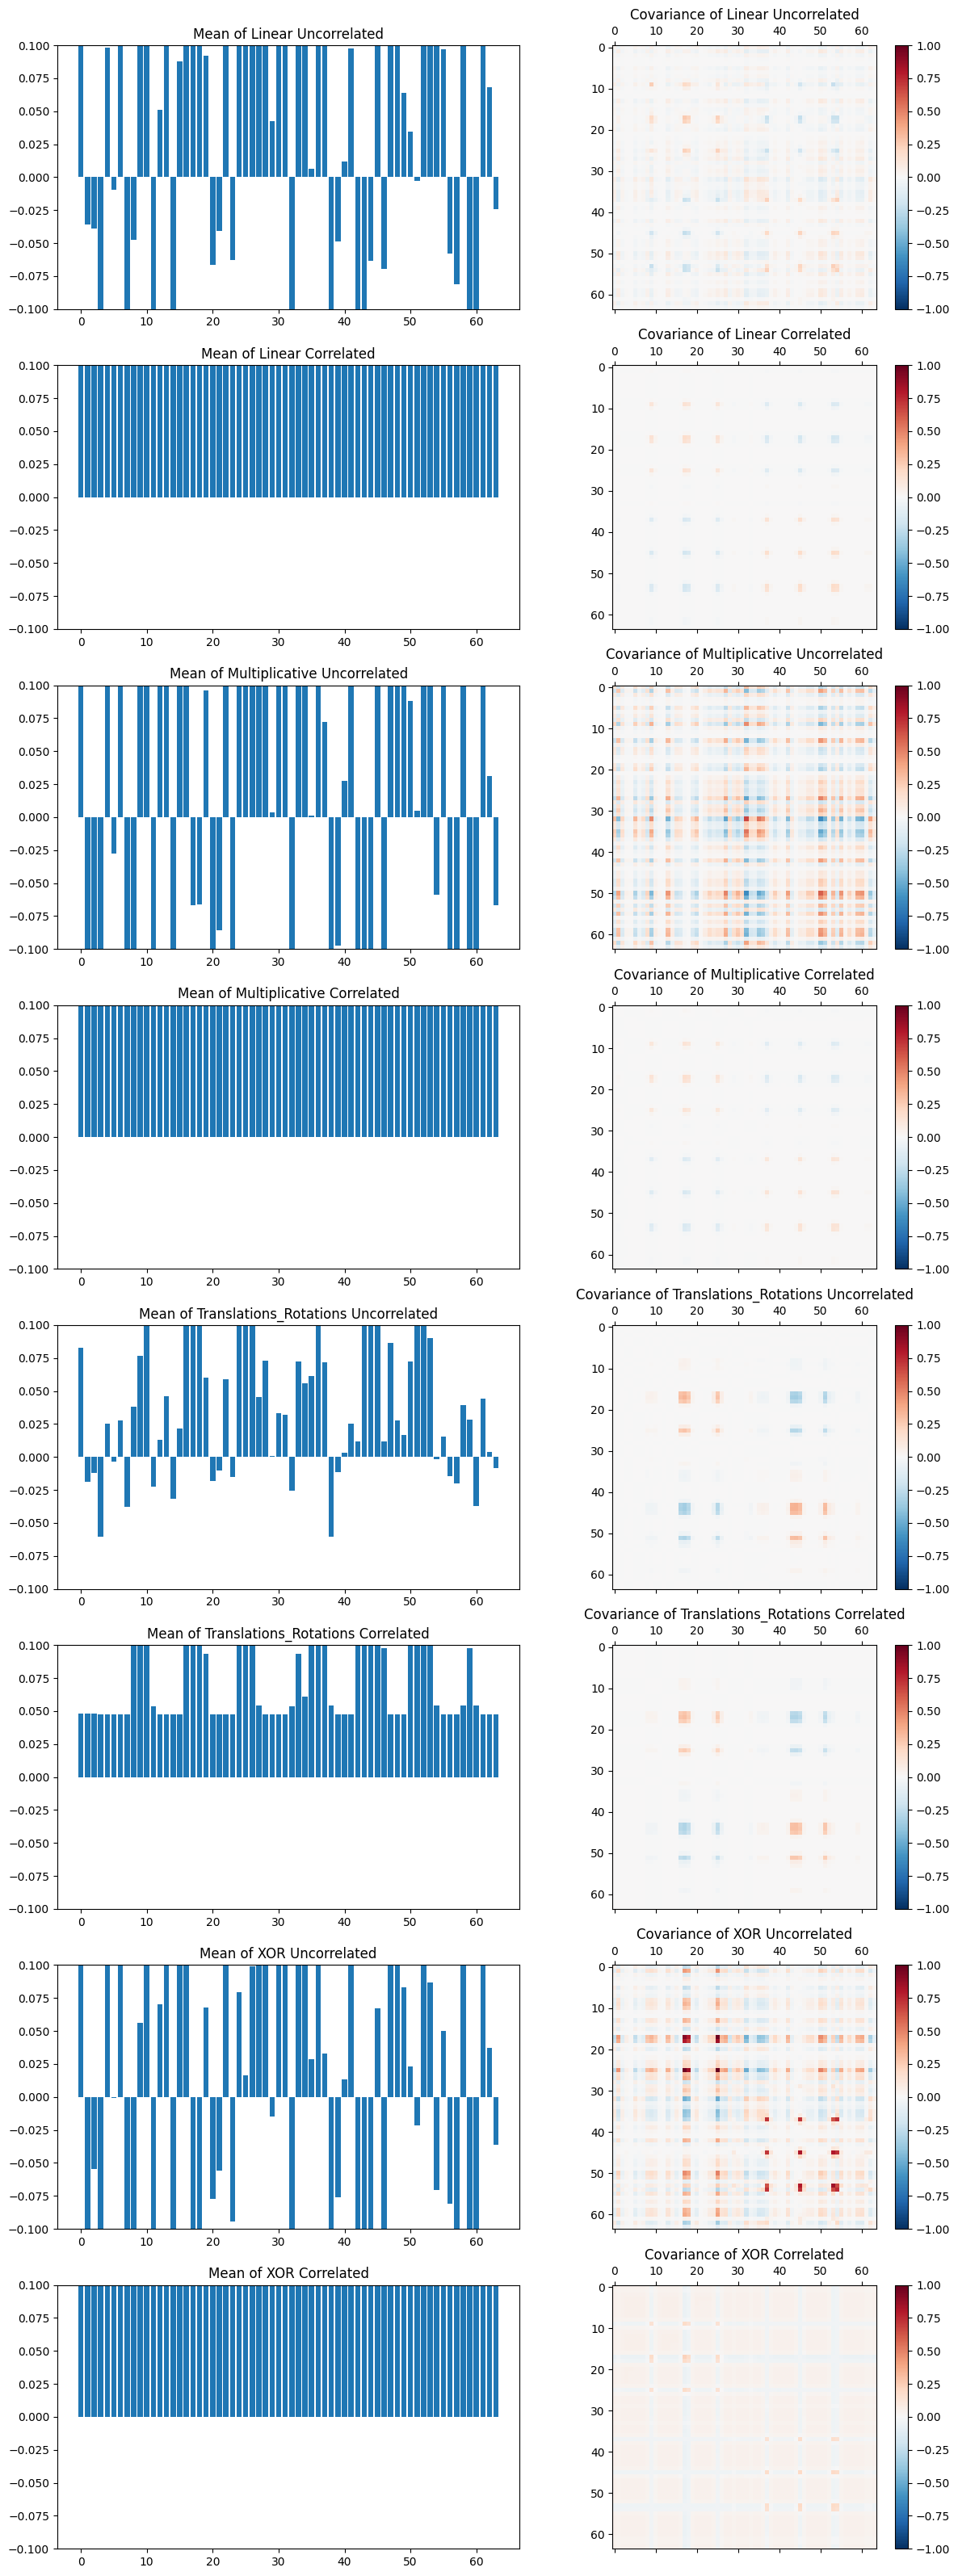

In [ ]:

data_dict, transformation_matrices = generate_n_examples_with_whitening(n=4)
def validate_whitening(data):
    # Compute the mean of the data
    mean = np.mean(data, axis=0)
    print(f"Mean: {mean}")

    # Compute the covariance matrix of the data
    cov_matrix = np.cov(data, rowvar=False)

    # Ideally, for whitened data, the covariance matrix should be an identity matrix.
    # We'll measure the difference between the covariance matrix and the identity matrix.
    difference = np.linalg.norm(cov_matrix - np.eye(cov_matrix.shape[0]))
    print(f"Difference from identity: {difference}")

# Example Usage:
for key, value in data_dict.items():
    print(f"Validating whitening for {key}:")
    validate_whitening(value)
    print("------------")

def plot_whitened_data(data_dict):
    rows = 4  # Modifying this to 4 to show two rows for each class
    cols = 8

    fig = plt.figure(figsize=(12, 8))
    # grid for pairs of subplots
    grid = plt.GridSpec(rows, cols, hspace=0.15, wspace=0.1)

    j = 0
    keys = list(data_dict.keys())

    for i, key in enumerate(keys):
        data = data_dict[key]
        for r in range(rows):
            gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[r, i], wspace=0.1)
            ax = fig.add_subplot(gs[0])
            ax.imshow(np.reshape(data[r], (8,8)), cmap="RdBu_r", vmin=-1, vmax=1)
            
            if r == 0:
                ax.set_title(key.replace(' ', '\n').replace('_', '\n'), fontdict = {'fontsize' : 10})
            
            if i == 0 and r == 0:
                ax.set_ylabel(f'Y=0\n', fontsize=12)
            elif i == 0 and r == 2:
                ax.set_ylabel(f'Y=1\n', fontsize=12)
                
            ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
            j += 1

    plt.subplots_adjust(wspace=0.2, hspace=0.2)  
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.115, 0.02, 0.76])
    fig.colorbar(ax.get_images()[0], cax=cbar_ax, ticks=[-1.0,0,1.0])

    plt.show()
plot_whitened_data(data_dict)


def validate_and_plot_whitening(data_dict):
    fig, axes = plt.subplots(nrows=len(data_dict), ncols=2, figsize=(12, 4 * len(data_dict)))
    
    for ax_row, (key, data) in zip(axes, data_dict.items()):
        # Compute the mean and covariance of the data
        mean = np.mean(data, axis=0)
        cov_matrix = np.cov(data, rowvar=False)

        # Plot mean
        ax_row[0].bar(range(len(mean)), mean)
        ax_row[0].set_title(f"Mean of {key}")
        ax_row[0].set_ylim([-0.1, 0.1])  # Setting y-limits for better visualization

        # Plot covariance matrix
        cax = ax_row[1].matshow(cov_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
        ax_row[1].set_title(f"Covariance of {key}")
        
        # Add colorbar for the covariance heatmap
        plt.colorbar(cax, ax=ax_row[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
validate_and_plot_whitening(data_dict)

In [ ]:
data_dict, data_array = generate_n_examples_with_whitening(n=4)
print(data_dict.keys())
print(len(data_array))
print(len(data_array[0]))

dict_keys(['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated', 'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated', 'XOR Uncorrelated', 'XOR Correlated'])
32
64


In [ ]:
def plot_whitened_data_fixed(data_array, method_name):
    rows = 4  # Modifying this to 4 to show two rows for each class
    cols = 8

    fig = plt.figure(figsize=(12, 8))
    # grid for pairs of subplots
    grid = plt.GridSpec(rows, cols, hspace=0.15, wspace=0.1)

    j = 0
    keys = ['LIN WHITE', 'LIN CORR', 'MULT WHITE', 'MULT CORR',
             'RIGID WHITE', 'RIGID CORR','XOR WHITE', 'XOR CORR']

    for i in range(cols):
        for r in range(rows):
            gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[r, i], wspace=0.1)
            ax = fig.add_subplot(gs[0])
            ax.imshow(np.reshape(data_array[j], (8,8)), cmap="RdBu_r", vmin=-1, vmax=1)
            if r == 0:
                ax.set_title(keys[i].replace(' ', '\n').replace('_', '\n'), fontdict = {'fontsize' : 10})
            
            if i == 0 and r == 0:
                ax.set_ylabel(f'Y=0\n', fontsize=12)
            elif i == 0 and r == 2:
                ax.set_ylabel(f'Y=1\n', fontsize=12)
                
            ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
            j += 1

    plt.subplots_adjust(wspace=0.2, hspace=0.2)  
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.115, 0.02, 0.76])
    fig.colorbar(ax.get_images()[0], cax=cbar_ax, ticks=[-1.0,0,1.0])

    plt.suptitle(f"Whitening Method: {method_name}", y=1.02, fontsize=14)
    plt.show()

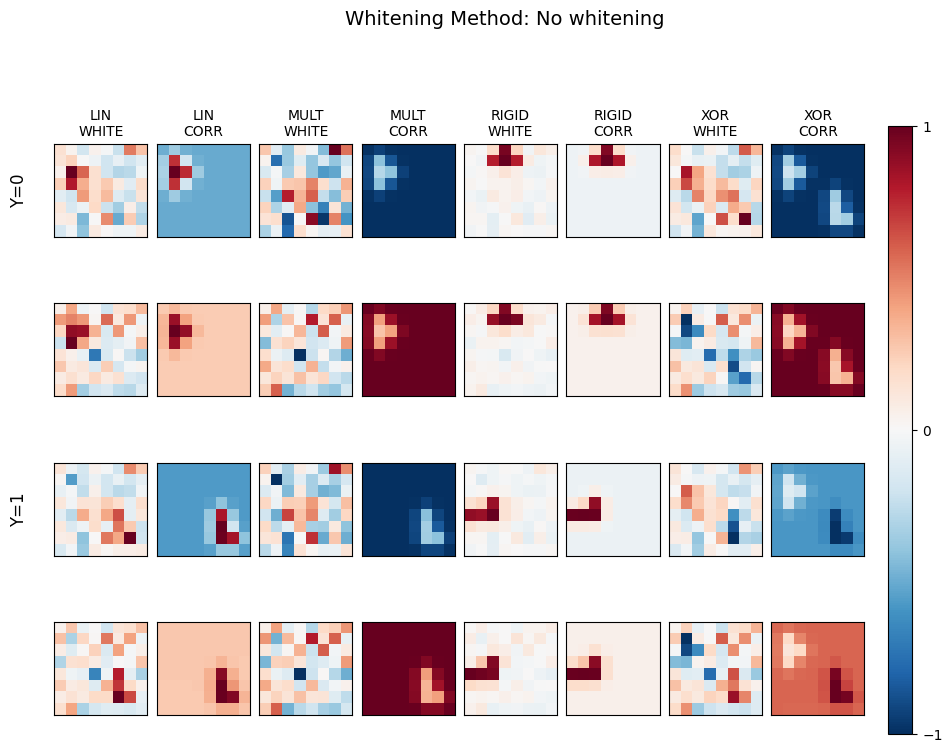

In [ ]:
plot_whitened_data_fixed(data_array, "No whitening")

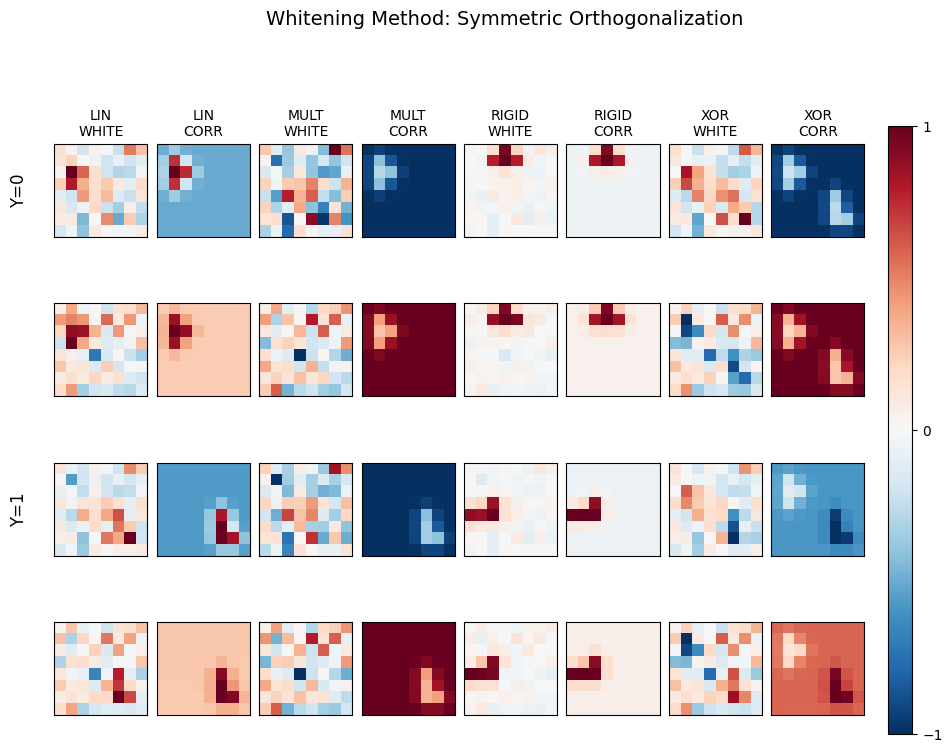

In [ ]:
plot_whitened_data_fixed(data_array, "Symmetric Orthogonalization")

In [ ]:
def validate_whitening(data):
    """
    Validate the whitening quality of the input data.
    
    Args:
    - data (ndarray): The whitened data of shape (samples, features).
    
    Returns:
    - mean_diag (float): Mean of the diagonal of the covariance matrix.
    - mean_abs_off_diag (float): Mean absolute value of the off-diagonal elements of the covariance matrix.
    """
    # Calculate the covariance matrix of the data
    covariance_matrix = np.cov(data, rowvar=False)
    
    # Calculate the mean of the diagonal
    mean_diag = np.mean(np.diag(covariance_matrix))
    
    # Calculate the mean absolute off-diagonal value
    mean_abs_off_diag = np.mean(np.abs(covariance_matrix - np.diag(np.diag(covariance_matrix))))
    
    return mean_diag, mean_abs_off_diag

# Validate the whitening quality of the entire whitened dataset
mean_diag, mean_abs_off_diag = validate_whitening(np.vstack(list(data_dict.values())))

print("Validation Results:")
print(f"Mean Diagonal: {mean_diag}")
print(f"Mean Absolute Off-Diagonal: {mean_abs_off_diag}")

Validation Results:
Mean Diagonal: 0.2697483219760891
Mean Absolute Off-Diagonal: 0.20425267874462233


In [ ]:
# To validate individual datasets, you can loop through the output_dict:
for key, value in data_dict.items():
    mean_diag, mean_abs_off_diag = validate_whitening(value)
    print(f"\nFor {key}:")
    print(f"Mean Diagonal: {mean_diag}")
    print(f"Mean Absolute Off-Diagonal: {mean_abs_off_diag}")


For Linear Uncorrelated:
Mean Diagonal: 0.06481488831707179
Mean Absolute Off-Diagonal: 0.025198217301798494

For Linear Correlated:
Mean Diagonal: 0.23689225159279576
Mean Absolute Off-Diagonal: 0.18152314536815814

For Multiplicative Uncorrelated:
Mean Diagonal: 0.08808285673187136
Mean Absolute Off-Diagonal: 0.05575455390850449

For Multiplicative Correlated:
Mean Diagonal: 1.22700179536898
Mean Absolute Off-Diagonal: 1.1775333674434676

For Translations_Rotations Uncorrelated:
Mean Diagonal: 0.03787753862030069
Mean Absolute Off-Diagonal: 0.007186004586404727

For Translations_Rotations Correlated:
Mean Diagonal: 0.0410433314652962
Mean Absolute Off-Diagonal: 0.009168710999701794

For XOR Uncorrelated:
Mean Diagonal: 0.10268450166067389
Mean Absolute Off-Diagonal: 0.036256410891434054

For XOR Correlated:
Mean Diagonal: 0.7918760448352856
Mean Absolute Off-Diagonal: 0.7327087298819683


In [ ]:
# Generate a simple test dataset
np.random.seed(0)
test_data = np.random.rand(100, 64)

# Apply the symmetric orthogonalization whitening method
whitened_test_data, _ = partial_regression(test_data)

# Validate the whitening quality of the test dataset
mean_diag, mean_abs_off_diag = validate_whitening(whitened_test_data)

print("Validation Results for Test Data:")
print(f"Mean Diagonal: {mean_diag}")
print(f"Mean Absolute Off-Diagonal: {mean_abs_off_diag}")


Validation Results for Test Data:
Mean Diagonal: 0.03253893511619202
Mean Absolute Off-Diagonal: 0.003988293316421743


In [ ]:
# Generate the whitened data using the function
output_dict, all_data = generate_n_examples_with_whitening(n=4, whitening_method=sphering)

# Validate the whitening quality of the entire whitened dataset
mean_diag, mean_abs_off_diag = validate_whitening(np.vstack(list(output_dict.values())))

print("Validation Results:")
print(f"Mean Diagonal: {mean_diag}")
print(f"Mean Absolute Off-Diagonal: {mean_abs_off_diag}")


Computing inverse square root...
Applied sphering. Matrix shape: (32, 64)
Validation Results:
Mean Diagonal: 0.17605957853192827
Mean Absolute Off-Diagonal: 0.024860174840147298


/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
# Generate the whitened data using the function
output_dict, all_data = generate_n_examples_with_whitening(n=4, whitening_method=cholesky_whitening)

# Validate the whitening quality of the entire whitened dataset
mean_diag, mean_abs_off_diag = validate_whitening(np.vstack(list(output_dict.values())))

print("Validation Results:")
print(f"Mean Diagonal: {mean_diag}")
print(f"Mean Absolute Off-Diagonal: {mean_abs_off_diag}")


Applied Cholesky whitening. Matrix shape: (32, 64)
Validation Results:
Mean Diagonal: 213695.71989938008
Mean Absolute Off-Diagonal: 105290.23094301124


In [ ]:
# Generate the whitened data using the function
output_dict, all_data = generate_n_examples_with_whitening(n=4, whitening_method=optimal_signal_preserving_whitening)

# Validate the whitening quality of the entire whitened dataset
mean_diag, mean_abs_off_diag = validate_whitening(np.vstack(list(output_dict.values())))

print("Validation Results:")
print(f"Mean Diagonal: {mean_diag}")
print(f"Mean Absolute Off-Diagonal: {mean_abs_off_diag}")


Validation Results:
Mean Diagonal: 0.18842740909427774
Mean Absolute Off-Diagonal: 0.026884002703476854


/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
# Generate the whitened data using the function
output_dict, all_data = generate_n_examples_with_whitening(n=4, whitening_method=partial_regression)

# Validate the whitening quality of the entire whitened dataset
mean_diag, mean_abs_off_diag = validate_whitening(np.vstack(list(output_dict.values())))

print("Validation Results:")
print(f"Mean Diagonal: {mean_diag}")
print(f"Mean Absolute Off-Diagonal: {mean_abs_off_diag}")

Validation Results:
Mean Diagonal: 3.0219202306490905e-23
Mean Absolute Off-Diagonal: 1.3271149199862426e-23


Computing inverse square root...
Applied sphering. Matrix shape: (32, 64)


/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


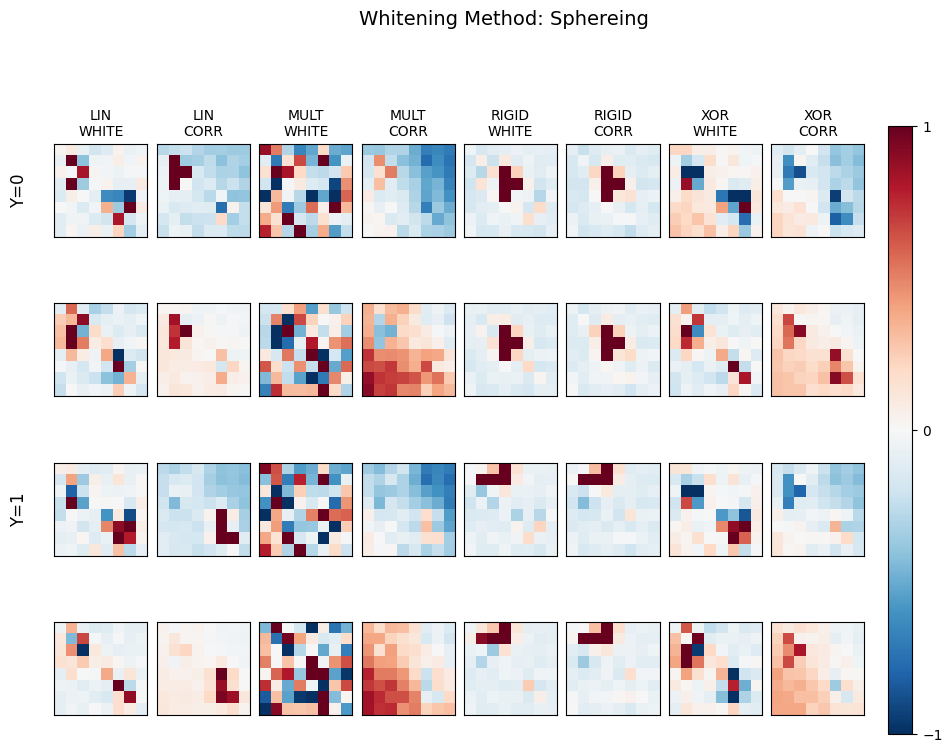

In [ ]:
_, data_array_whitened = generate_n_examples_with_whitening(n=4, whitening_method=sphering)
plot_whitened_data_fixed(data_array_whitened, "Sphereing")

Applied Cholesky whitening. Matrix shape: (32, 64)


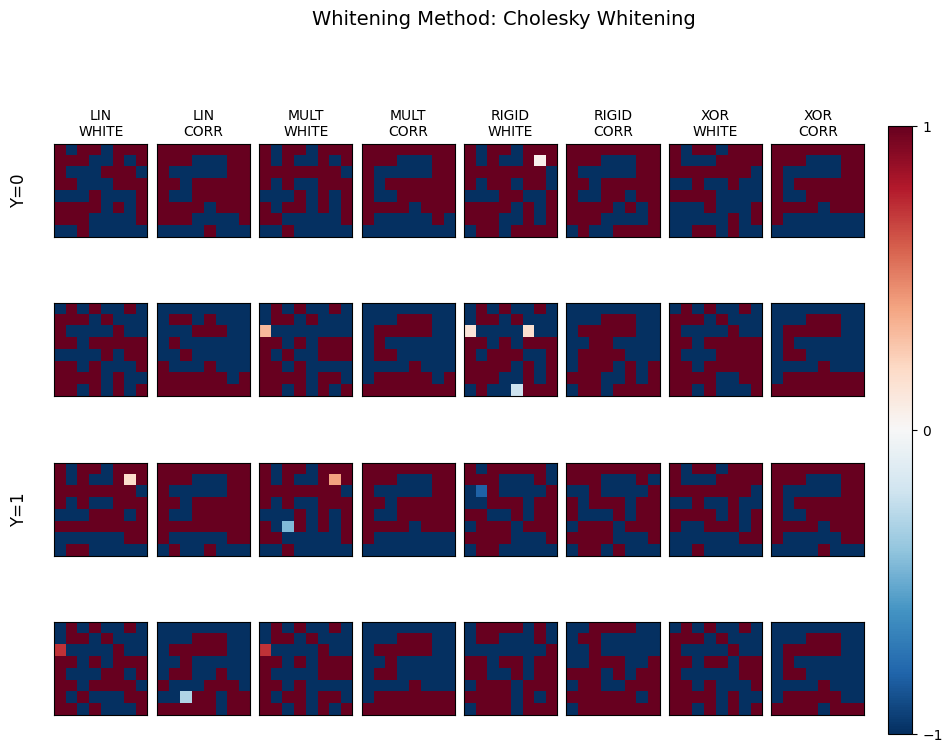

In [ ]:
_, data_array_whitened = generate_n_examples_with_whitening(n=4, whitening_method=cholesky_whitening)
plot_whitened_data_fixed(data_array_whitened, "Cholesky Whitening")

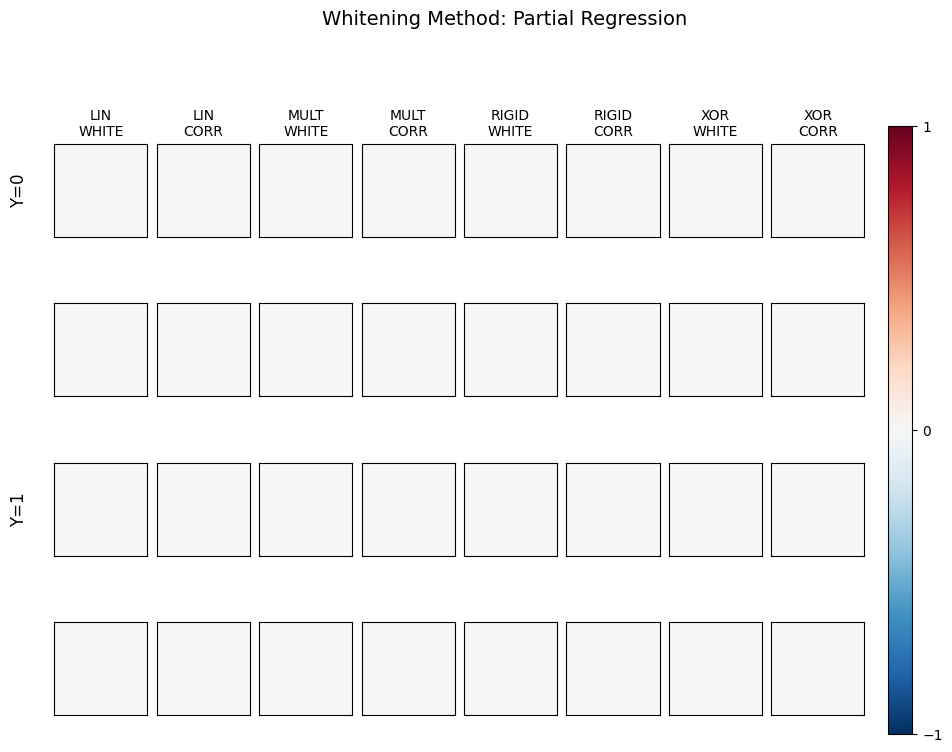

In [ ]:
_, data_array_whitened = generate_n_examples_with_whitening(n=4, whitening_method=partial_regression)
plot_whitened_data_fixed(data_array_whitened, "Partial Regression")

/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


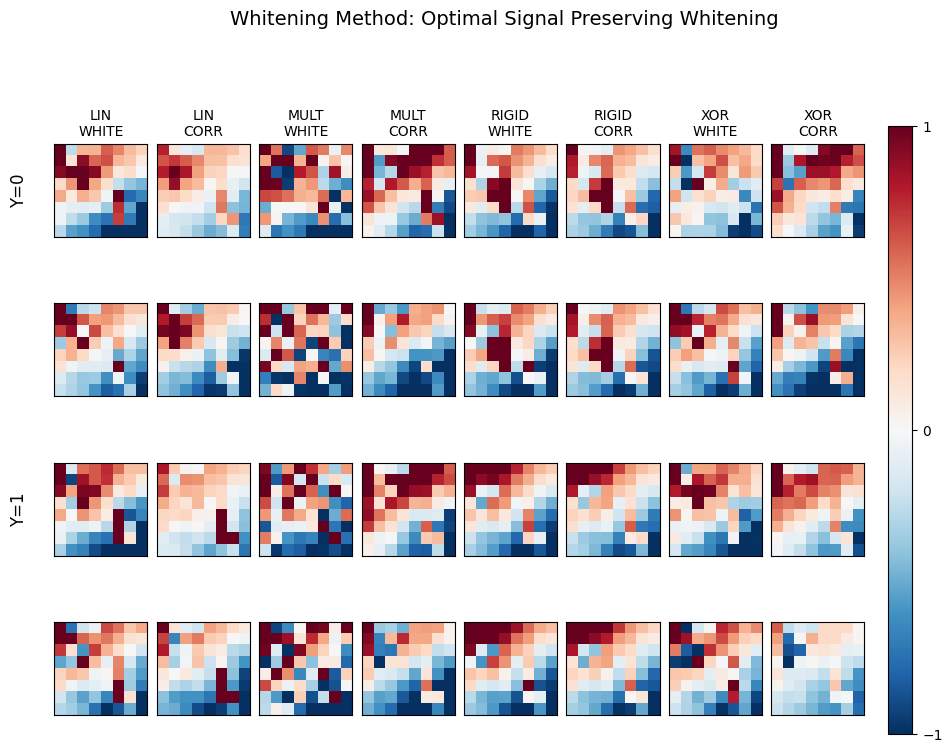

In [ ]:
_, data_array_whitened = generate_n_examples_with_whitening(n=4, whitening_method=optimal_signal_preserving_whitening)
plot_whitened_data_fixed(data_array_whitened, "Optimal Signal Preserving Whitening")

In [ ]:
# Show 2 examples from each (scenario, background) pair, 1 of each class
snrs = [0.5, 0.4, 0.5, 0.825, 0.825, 0.825, 0.5, 0.2, 0.5, 0.6, 0.2, 0.6]
# snrs = [0.4] * 8
def generate_n_examples(n=2, snrs=snrs):
    backgrounds = [generate_background(), generate_background()]
    smoothed_backgrounds = [gaussian_filter(backgrounds[0].copy(), 10), gaussian_filter(backgrounds[1].copy(), 10)]

    linear_0, linear_1 = generate_linear_pattern(0), generate_linear_pattern(1)
    mult_0, mult_1 = generate_multiplicative_pattern(0, snr=0.725), generate_multiplicative_pattern(1, snr=0.725)
    tr_0, tr_1 = generate_translations_rotations_pattern(0), generate_translations_rotations_pattern(1)
    xor_0, xor_1 = generate_xor_pattern(0), generate_xor_pattern(1)

    patterns = {
        'Linear': [linear_0, linear_1],
        'Multiplicative': [mult_0, mult_1],
        'Translations_Rotations': [tr_0, tr_1],
        'XOR': [xor_0, xor_1]
    }

    backgrounds_dict = {
        'Correlated': smoothed_backgrounds,
        'Uncorrelated': backgrounds,
    }

    keys = ['Linear Uncorrelated', 'Linear Correlated', 'Multiplicative Uncorrelated', 'Multiplicative Correlated',
            'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated','XOR Uncorrelated', 'XOR Correlated']
    data_dict = {}

    output_array = []
    for snr_ind, key in enumerate(keys):
        data = np.zeros((n,64))
        data_dict[key] = list()
        scenario, background_type = key.split(' ')
        bg = backgrounds_dict[background_type]
        ind = 0
        for j in range(2):
            for i in range(2):
                if 'XOR' in key and i == 1:
                    scalar = -1
                else:
                    scalar = 1
                pat = patterns[scenario][j] * scalar
                back = bg[i]
                if 'Multiplicative' in key:
                    pat_copy = 1 - snrs[snr_ind] * pat.copy()
                else:
                    pat_copy = pat.copy()

                normalised_patterns, normalised_backgrounds = normalise_data(np.reshape(pat_copy,(8,8)), np.reshape(back, (8,8)))
                if 'Multiplicative' in key:
                    data[ind] = np.reshape( normalised_patterns * normalised_backgrounds, (64))
                else:
                    data[ind] = np.reshape(snrs[snr_ind] * normalised_patterns + (1 - snrs[snr_ind]) * normalised_backgrounds, (64))
                data[ind] = scale_to_bound(data[ind], 1)
                output_array.append(data[ind])
                ind += 1
        data_dict[key] += [data]


    output_dict = {}
    for key, value in data_dict.items():
        output_dict[key] = np.vstack(value)
    return output_dict, output_array


/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


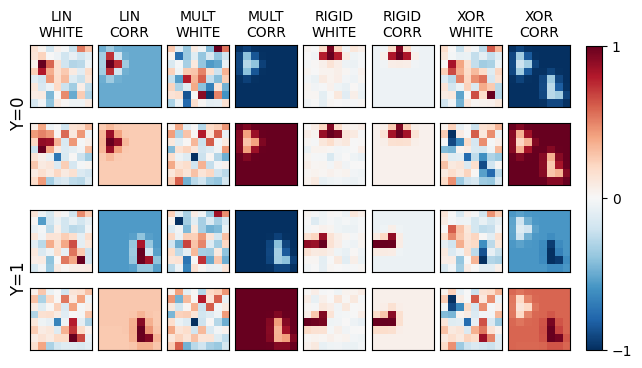

In [ ]:
rows = 2
cols = 8

fig = plt.figure(figsize=(8, 4))
# grid for pairs of subplots
grid = plt.GridSpec(rows, cols, hspace=0.15, wspace=0.1)

j = 0
keys = ['LIN WHITE', 'LIN CORR', 'MULT WHITE', 'MULT CORR',
         'RIGID WHITE', 'RIGID CORR','XOR WHITE', 'XOR CORR']

for i in range(cols):
    # create fake subplot just to title pair of subplots

    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid[i], wspace=0.1)

    ax = fig.add_subplot(gs[0])
    ax.imshow(np.reshape(data_array[j], (8,8)), cmap="RdBu_r", vmin=-1, vmax=1)
    ax.set_title(keys[i].replace(' ', '\n').replace('_', '\n'), fontdict = {'fontsize' : 10})

    ax2 = fig.add_subplot(gs[1], sharey=ax)
    ax2.imshow(np.reshape(data_array[j+1], (8,8)), cmap="RdBu_r", vmin=-1, vmax=1)

    for axs in [ax, ax2]:
        axs.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid[i+8], wspace=0.1)

    ax3 = fig.add_subplot(gs[0])
    ax3.imshow(np.reshape(data_array[j+2], (8,8)), cmap="RdBu_r", vmin=-1, vmax=1)

    ax4 = fig.add_subplot(gs[1], sharey=ax3)
    im = ax4.imshow(np.reshape(data_array[j+3], (8,8)), cmap="RdBu_r", vmin=-1, vmax=1)

    if i == 0:
        ax.set_ylabel(f'Y=0\n', fontsize=12, y=0.7)
        ax.yaxis.set_label_coords(0.3,-0.10)
        ax3.set_ylabel(f'Y=1\n', fontsize=12, y=0.7)
        ax3.yaxis.set_label_coords(0.3, -0.10)


    j+=4
#     j+=2
    # hide ticks and labels
    for axs in [ax3, ax4]:
        axs.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

plt.subplots_adjust(wspace=0.2, hspace=0.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.115, 0.02, 0.76])
fig.colorbar(im, cax=cbar_ax, ticks=[-1.0,0,1.0])

fig.tight_layout()

out_folder_path = f'./figures/'
Path(f'{out_folder_path}').mkdir(parents=True, exist_ok=True)
plt.savefig('./figures/data_plot_corrected_5.png', bbox_inches='tight', dpi=300)


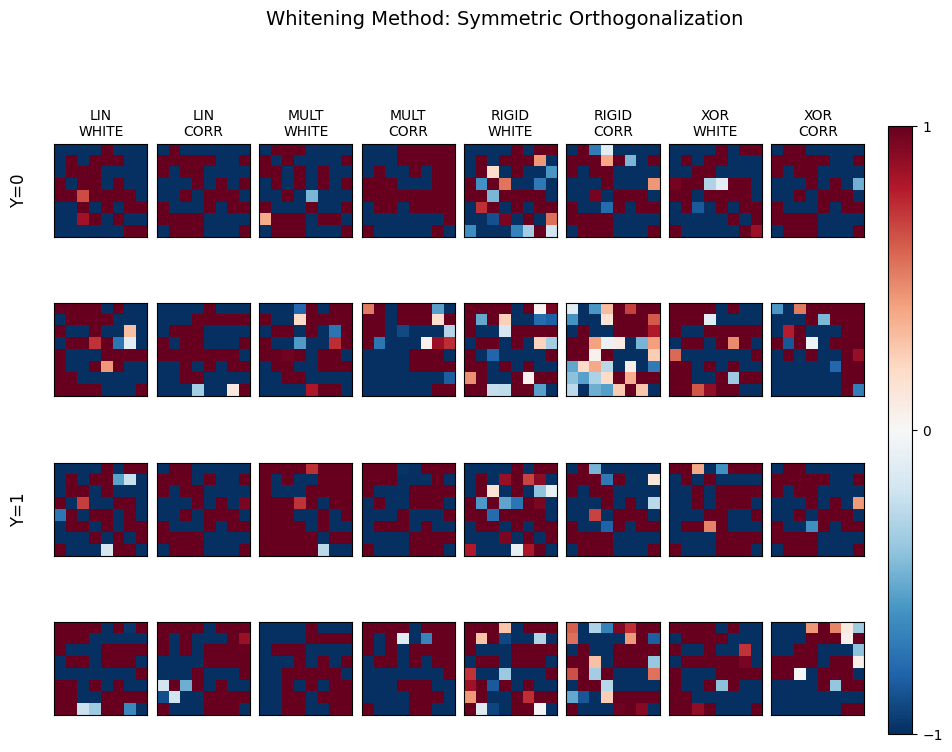

In [ ]:
_, data_array_whitened = generate_n_examples_with_whitening(n=4, whitening_method=symmetric_orthogonalization)
plot_whitened_data_fixed(data_array_whitened, "Symmetric Orthogonalization")

Applied Cholesky whitening. Matrix shape: (32, 64)


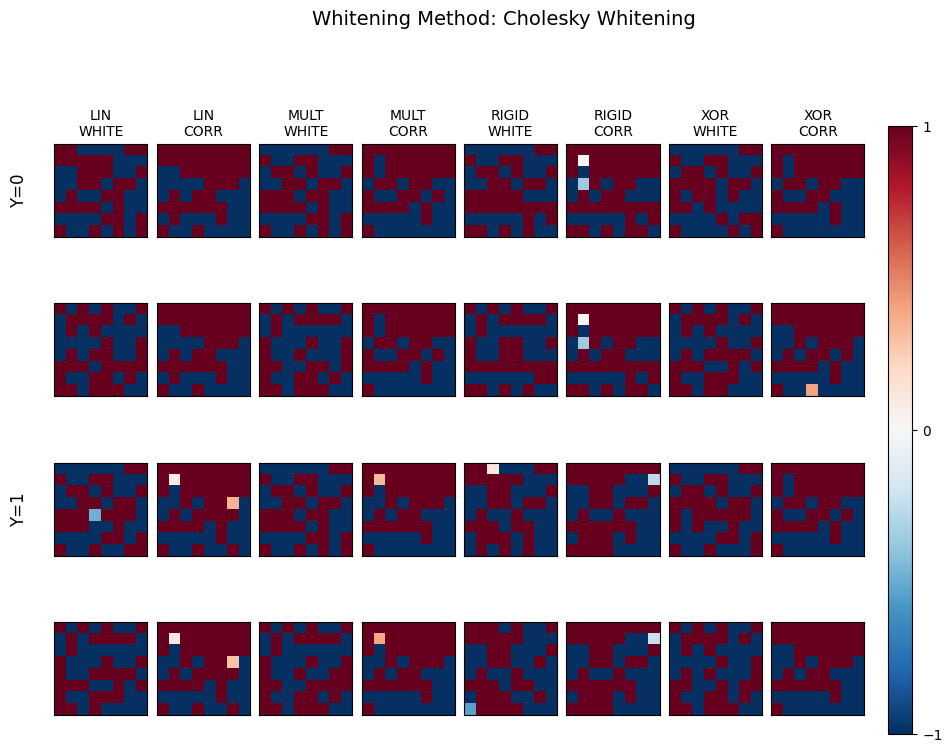

In [ ]:
_, data_array_whitened = generate_n_examples_with_whitening(n=4, whitening_method=cholesky_whitening)
plot_whitened_data_fixed(data_array_whitened, "Cholesky Whitening")

Computing inverse square root...
Applied sphering. Matrix shape: (32, 64)


/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


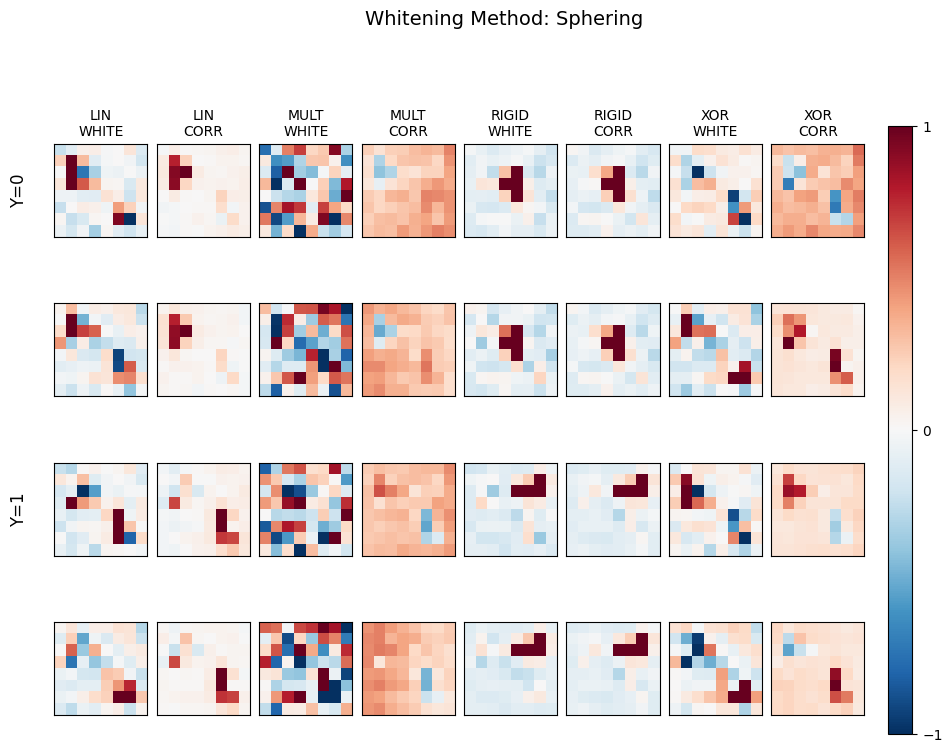

In [ ]:
_, data_array_whitened = generate_n_examples_with_whitening(n=4, whitening_method=sphering)
plot_whitened_data_fixed(data_array_whitened, "Sphering")

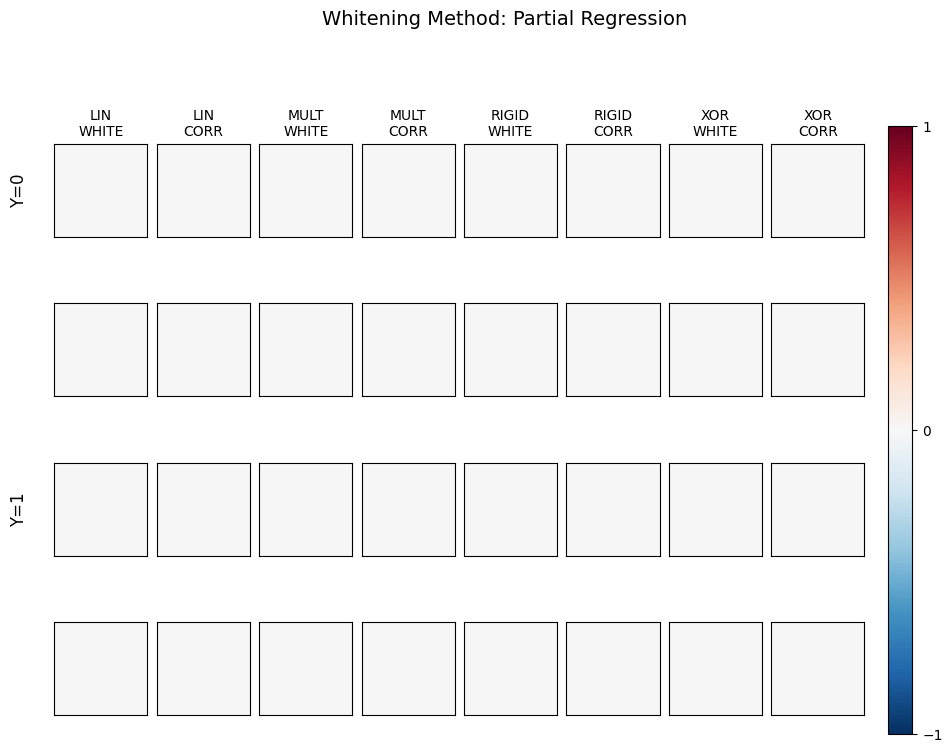

In [ ]:
_, data_array_whitened = generate_n_examples_with_whitening(n=4, whitening_method=partial_regression)
plot_whitened_data_fixed(data_array_whitened, "Partial Regression")

/Users/stoyankaras/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


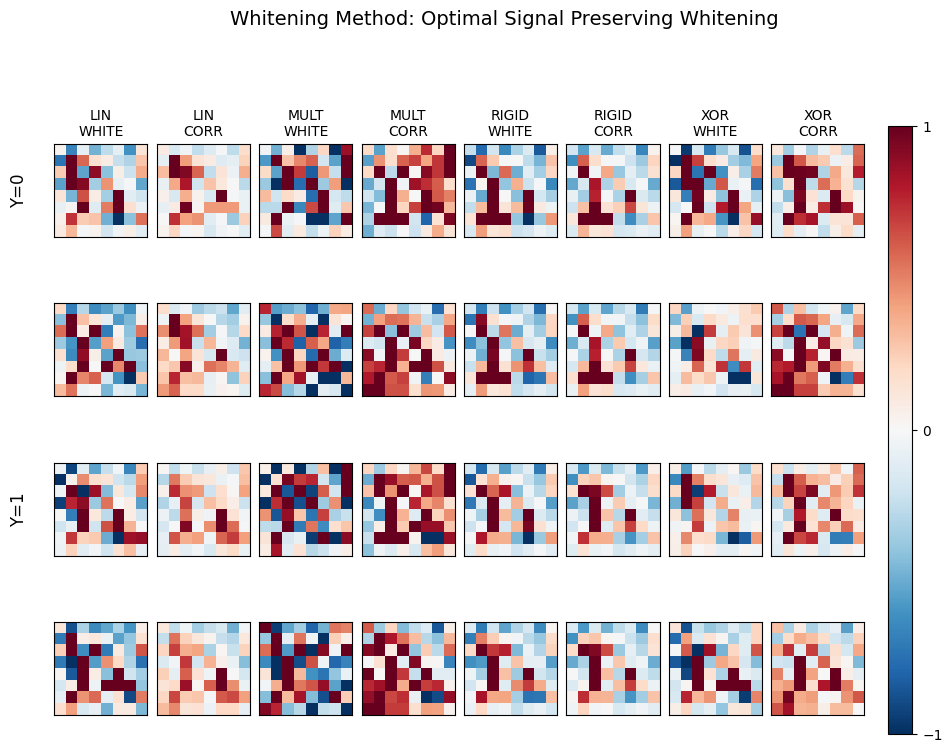

In [ ]:
_, data_array_whitened = generate_n_examples_with_whitening(n=4, whitening_method=optimal_signal_preserving_whitening)
plot_whitened_data_fixed(data_array_whitened, "Optimal Signal Preserving Whitening")